In [1]:
# Импорт необходимых библиотек
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, PowerTransformer, 
                                  QuantileTransformer, TargetEncoder,
                                  LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif
from sklearn.pipeline import Pipeline
from sklearn.cluster import MiniBatchKMeans
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn import metrics
from sklearn.metrics import matthews_corrcoef
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from lightgbm import LGBMClassifier
import xgboost as xgb
from imblearn.under_sampling import TomekLinks, NearMiss, RandomUnderSampler, 
                                    AllKNN, OneSidedSelection, 
                                    NeighbourhoodCleaningRule, InstanceHardnessThreshold,
                                    EditedNearestNeighbours
from imblearn.over_sampling import SMOTENC, ADASYN, BorderlineSMOTE, KMeansSMOTE
import optuna
import gc
from tqdm import tqdm
from sklearn.ensemble import StackingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import tensorflow as tf
import keras
import keras.models as M
import keras.layers as L
import keras.backend as K
from keras.models import Sequential
from keras.optimizers import RMSprop
from keras.layers import Conv2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Input
import warnings
np.warnings = warnings

pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')
%matplotlib inline

# фиксируем RANDOM_SEED
RANDOM_STATE = 42

In [2]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

# 0. Постановка задачи

Проблема - отбор случаев оказанной медицинской помощи, оплаченной по обязательному медицинскому страхованию на медикоэкономическую экспертизу и экспертизу контроля качества в объёмах, определенных Приказом Министерства здравоохранения от 19 марта 2021 г. N 231н "Об утверждении порядка проведения контроля объемов, сроков, качества и условий предоставления медицинской помощи по обязательному медицинскому страхованию застрахованным лицам, а также ее финансового обеспечения".

**Объем ежемесячных медико-экономических экспертиз:**
1) при оказании медицинской помощи вне медицинской организации - 2%;
2) при оказании медицинской помощи амбулаторно - 0,5%;
3) при оказании медицинской помощи в дневном стационаре - 6%;
4) при оказании медицинской помощи стационарно - 6%.

Задача: необходимо разработать систему которая среди случаев медицинской помощи, оплаченных за заданный период. Отбирает случаи в которых вероятность дефектов оказания медицинской помощи наибольшая в рамках заданных объёмов. 

В данной задаче 2 целевые переменные: 
- подозрение на наличие дефекта медикоэкономической экспертизы (далее МЭЭ)
- подозрение на наличие дефекта экспертизы контроля качества (далее ЭКМП)

Поставленная задача - задача классификации.

### Служебные процедуры

In [3]:
# функция для конвертации признаков
def group_omu_convert(item):
    """ Функция для конвертации значений GROUP_OMU

    Args:
        - item: значение поля для обработки
    Returns:
        - значение для нового признака
    """
    if item is np.nan:
        return 'NO_OMU'
    if item in ['91', '92', '93']:
        return 8
    if item in ['98', '99']:
        return 9
    else:
        return item[0]


def ds0_ds1(x):
    """ Функция для оценки расхождения диагнозов

    Args:
        - x: строка по отобранным столбцам датафрейма
    Returns:
        - значение для нового признака
    """
    if x['DS0'] is np.nan:
        return -1
    if x['DS1'] == x['DS0']:
        return 1
    else:
        return 0


def diff_dates(x):
    """ Функция для определения различия даты направления 
    на лечения и даты начала лечения

    Args:
        - x: строка по отобранным столбцам датафрейма
    Returns:
        - значение для нового признака
    """
    if x['NPR_DATE'] == x['DATE_1']:
        return 0
    else:
        return 1


# функция для статистического анализа
def decision_hypothesis(p, alpha):
    """ Функция для принятия решения об отклонении нулевой гипотезы

    Args:
        - p: p-value
        - alpha: уровень значимости
    Returns:
        - результат не возвращается
    """
    if p <= alpha:
        print(
            'p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу.\n'.format(alpha))
    else:
        print(
            'p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.\n'.format(alpha))


def outliers_z_score(data, feature, left=3, right=3, log_scale=False):
    """ Функция для оценки наличия выбросов и их количества методом z-отклонения

    Args:
        - data: исходный датафрейм
        - feature: признак
        - left: левый коэффициент сигмы
        - right: правый коэффициент сигмы
        - log_scale: признак логарифмирования признака перед оценкой
    Returns:
        - результат не возвращается
    """
    if log_scale:
        x = np.log(data[feature]+1)
    else:
        x = data[feature]
    mu = x.mean()
    sigma = x.std()
    lower_bound = mu - left * sigma
    upper_bound = mu + right * sigma
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x > lower_bound) & (x < upper_bound)]
    return outliers, cleaned


# функции для конвертации типов данных
def type_converter(df, columns_dict):
    """ Функция преобразующая типы данных датафрейма

    Args:
        - df: исходный датафрейм
        - columns_dict: словарь с ключами - целевыми типами данных
          и списками полей в качестве значений
    Returns:
        - датафрейм с изменениями
    """
    for item in columns_dict:
        for column in columns_dict[item]:
            df[column] = df[column].astype(item)
    return df


def trans_dict_gen(df, col_name=''):
    """ Функция формирующая справочник для конвертаци типов данных 

    Args:
        - df: исходный датафрейм
        - col_name: наименование колонки, котрую необходимо не включать в справочник
    Returns:
        - справочник вида "тип данных":[список колонок]
    """
    temp_dict = dict()
    all_columns = df.columns
    for column in all_columns:
        temp = []
        if column != col_name:
            col_type = str(df[column].dtypes)
            if temp_dict.get(col_type) == None:
                temp_dict[col_type] = [column]
            else:
                temp = temp_dict[col_type]
                temp.append(column)
                temp_dict[col_type] = temp
    return temp_dict


# функции для построения графиков
def cat_graf_build(data, column_list, rotation_column=[], height=4, signature=1):
    """ Функция строящая графики countplot по заданным параметрам

    Args:
        - data: исходный датафрейм
        - column_list: список фичей для построения графиков 
        - rotation_column: наименование фичи для которой нужно повернуть подписи столбцов графика
        - height: высота одного графика
        - signature: подпись значений над столбцом графика
    Returns:
        - графики
    """
    total_axes = len(column_list)
    fig = plt.figure(figsize=(18, total_axes*height))
    subplt = 1
    for _, column in enumerate(column_list):
        axes = fig.add_subplot(total_axes, 3, subplt)
        feature_plot = sns.countplot(data=data,
                                     x=column,
                                     ax=axes)
        feature_plot.set(xlabel='', ylabel='Количество')
        if column in rotation_column:
            plt.xticks(rotation=75, fontsize=8)
        else:
            plt.xticks(fontsize=8)
        plt.title(
            f'Соотношение количества значений признака {column}', fontsize=8)
        if signature == 1:
            for p in feature_plot.patches:
                feature_plot.annotate('{:.0f}'.format(p.get_height()),
                                      (p.get_x()+0.4, p.get_height()+0.1),
                                      ha='center',
                                      va='bottom',
                                      fontsize=8)
        subplt += 1

        axes1 = fig.add_subplot(total_axes, 3, subplt)
        feature_plot1 = sns.countplot(data=data[data['MEE'] != -1],
                                      x=column,
                                      ax=axes1)
        feature_plot1.set(xlabel='', ylabel='Количество')
        if column in rotation_column:
            plt.xticks(rotation=75, fontsize=8)
        else:
            plt.xticks(fontsize=8)
        plt.title(
            f'Соотношение количества значений признака {column} для МЕЕ', fontsize=8)
        if signature == 1:
            for p in feature_plot1.patches:
                feature_plot1.annotate('{:.0f}'.format(p.get_height()),
                                       (p.get_x()+0.4, p.get_height()+0.1),
                                       ha='center',
                                       va='bottom',
                                       fontsize=8)
        subplt += 1

        axes2 = fig.add_subplot(total_axes, 3, subplt)
        feature_plot2 = sns.countplot(data=data[data['EKMP'] != -1],
                                      x=column,
                                      ax=axes2)
        feature_plot2.set(xlabel='', ylabel='Количество')
        if column in rotation_column:
            plt.xticks(rotation=75, fontsize=8)
        else:
            plt.xticks(fontsize=8)
        plt.title(
            f'Соотношение количества значений признака {column} для EKMP', fontsize=8)
        if signature == 1:
            for p in feature_plot2.patches:
                feature_plot2.annotate('{:.0f}'.format(p.get_height()),
                                       (p.get_x()+0.4, p.get_height()+0.1),
                                       ha='center',
                                       va='bottom',
                                       fontsize=8)
        subplt += 1
    plt.tight_layout()
    plt.show()


def stat_graf_bild(data, num_cols):
    '''Функция строит гистограмму и диаграмму распределения для, 
    переданных в списке, колонок датафрейма

    Args:
        - data: исходный датафрейм
        - num_cols (list): список колонок

    Returns: графики 
    '''
    total_axes = len(num_cols)
    fig = plt.figure(figsize=(10, total_axes*3))
    subplt = 1
    for column in num_cols:
        axes = fig.add_subplot(total_axes, 2, subplt)
        sns.histplot(data=data[column],
                     bins=20,
                     ax=axes,
                     kde=True)
        axes.set_title('Распределение признака {} (гистограмма)'.format(column),
                       fontsize=12)
        axes.set_xlabel('')
        axes.set_ylabel('Количество')
        subplt += 1

        axes1 = fig.add_subplot(total_axes, 2, subplt)
        sns.boxplot(data[column],
                    ax=axes1,
                    orient='h',
                    flierprops={"marker": "*"},
                    medianprops={"color": "yellow",
                                 "linestyle": '--'})
        axes1.set(ylabel='')
        axes1.set_title('(диаграмма размаха)'.format(column),
                        fontsize=12)
        axes1.set_xlabel('')
        plt.scatter(data[column].max(),
                    0, marker='*',
                    s=20,
                    color='black',
                    label='Выбросы')
        plt.scatter(data[column].mean(),
                    0,
                    marker='o',
                    s=20,
                    color='red',
                    edgecolors='black',
                    label='Среднее')
        axes1.axvline(data[column].mean(),
                      color='red',
                      linestyle='--',
                      linewidth=2)
        plt.legend()
        subplt += 1

    plt.tight_layout()
    plt.show()


def stat_graf_target_boxplot(data, num_cols):
    '''Функция строит диаграммы boxplot для, основного распределения и в 
    приложении к целевым переменным

    Args:
        - data: исходный датафрейм
        - num_cols (list): список колонок

    Returns: графики 
    '''
    total_axes = len(num_cols)
    fig = plt.figure(figsize=(12, total_axes*3))
    subplt = 1
    for column in num_cols:
        axes = fig.add_subplot(total_axes, 3, subplt)
        sns.boxplot(data[column],
                    ax=axes,
                    orient='h',
                    flierprops={"marker": "*"},
                    medianprops={"color": "yellow",
                                 "linestyle": '--'})
        axes.set(ylabel='')
        axes.set_title('Основное распределение признак {}'.format(column),
                       fontsize=12)
        axes.set_xlabel('')
        subplt += 1

        axes1 = fig.add_subplot(total_axes, 3, subplt)
        sns.boxplot(data=data,
                    x=column,
                    y='MEE',
                    ax=axes1,
                    orient='h',
                    flierprops={"marker": "*"},
                    medianprops={"color": "yellow",
                                 "linestyle": '--'})
        axes1.set(ylabel='')
        axes1.set_title('МЕЕ'.format(column),
                        fontsize=12)
        axes1.set_xlabel('')
        subplt += 1

        axes2 = fig.add_subplot(total_axes, 3, subplt)
        sns.boxplot(data=data,
                    x=column,
                    y='EKMP',
                    ax=axes2,
                    orient='h',
                    flierprops={"marker": "*"},
                    medianprops={"color": "yellow",
                                 "linestyle": '--'})
        axes2.set(ylabel='')
        axes2.set_title('ЕКМП'.format(column),
                        fontsize=12)
        axes2.set_xlabel('')
        subplt += 1

    plt.tight_layout()
    plt.show()

    # Функции для обучения и расчёта метрик


def xgb_calc(X_train, y_train, X_valid, y_valid):
    '''Функция строит модель XGBClassifier, выполняет предсказание на тестовых данных, 
    расчитывает и распечатывает метрики.
    Args:
        - X_train: обучающий датафрейм
        - y_train: целевая перменная для обучающей выборки
        - X_valid: валидационный датафрейм
        - y_valid: целевая перменная для валидационной выборки

    Returns: словарь с метриками
    '''
    model_xgb = xgb.XGBClassifier(tree_method="hist",
                                  gamma=1,
                                  learning_rate=0.05,
                                  n_estimators=500,
                                  max_depth=10,
                                  objective='multi:softprob',
                                  max_bin=512,
                                  eval_metric='auc',
                                  n_job=-1
                                  )
    model_xgb.fit(X_train, y_train)
    y_pred = model_xgb.predict(X_valid)
    print(metrics.classification_report(y_valid, y_pred))
    return metrics.classification_report(y_valid, y_pred, output_dict=True)


def lgbm_calc(X_train, y_train, X_valid, y_valid):
    '''Функция строит модель XGBClassifier, выполняет предсказание на тестовых данных, 
    расчитывает и распечатывает метрики.
    Args:
        - X_train: обучающий датафрейм
        - y_train: целевая перменная для обучающей выборки
        - X_valid: валидационный датафрейм
        - y_valid: целевая перменная для валидационной выборки

    Returns: значения не возвращаются
    '''
    model = LGBMClassifier()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_valid)
    print(metrics.classification_report(y_valid, y_pred))


def discret_calc(model, X_train, y_train):
    '''Функция разделяет входные данные на фрагменты, выполняет преобразование 
    овер и/или андесемплинга по частями и объединяет полученные данные.
    Args:
        - X_train: обучающий датафрейм
        - y_train: целевая перменная для обучающей выборки
        - model: модель для преобразования

    Returns: преобразованные файлы
    '''
    all_df_X = pd.DataFrame()
    all_df_y = pd.DataFrame()
    test_size = 0
    columns_dict = trans_dict_gen(X_train)
    for i in range(8, 0, -1):
        test_size = 1/i
        if i > 1:
            _, X_temp, _, y_temp = train_test_split(X_train,
                                                    y_train,
                                                    stratify=y_train,
                                                    random_state=RANDOM_STATE,
                                                    test_size=test_size)
        else:
            X_temp = X_train
            y_temp = y_train
        X_train = X_train.drop(index=X_temp.index, axis=0)
        y_train = y_train.drop(index=y_temp.index, axis=0)
        X_temp_s, y_temp_s = model.fit_resample(X_temp, y_temp)
        all_df_X = pd.concat([all_df_X, X_temp_s], axis=0, ignore_index=True)
        all_df_X = type_converter(all_df_X, columns_dict)
        all_df_y = pd.concat([all_df_y, y_temp_s], axis=0, ignore_index=True)
        all_df_y = type_converter(all_df_y, {'int8': [0]})

    return all_df_X, all_df_y


def get_train_valid_file(X, y, imp_cat, imp_num, threshold, test_size):
    '''Функция удаляет признаки с низкой значимостью, 
    разделяет датафрейм с данныеми и датафрейм с целевой переменной на 
    тренировочные и валидационные датафреймы с учётом полученного 
    размера тестовой выборки.
    Args:
        - X: обучающий датафрейм
        - y: целевая перменная для обучающей выборки
        - imp_cat: список категориальных признаков
        - imp_num: список числовых признаков
        - test_size: размер тестовой выборки

    Returns: тренировочные и валидационные датафреймы с данными и целевой переменной
    '''
    drop_list_cat = list(imp_cat[imp_cat < threshold].index)
    drop_list_num = list(imp_num[imp_num < threshold].index)
    drop_list = drop_list_cat + drop_list_num

    X_drop_imp = X.drop(drop_list, axis=1)
    X_train, X_valid, y_train, y_valid = train_test_split(X_drop_imp,
                                                          y,
                                                          stratify=y,
                                                          random_state=RANDOM_STATE,
                                                          test_size=test_size)
    return X_train, X_valid, y_train, y_valid


def calc_metrix(metod, report_df, X_res, y_res, X_valid, y_valid):
    '''Функция разделяет входные данные на фрагменты, выполняет преобразование 
    овер и/или андесемплинга по частями и объединяет полученные данные.
    Args:
        - metod: наименование метода андер/оверсемплинга
        - report_df: датафрейм с результатами расчёта метрик
        - X_res: обучающий датафрейм
        - y_res: целевая перменная для обучающей выборки
        - X_valid: валидационный датафрейм
        - y_valid: целевая перменная для валидационной выборки

    Returns: датафрейм с результатами расчёта метрик
    '''
    metrics_dict = xgb_calc(X_res, y_res, X_valid, y_valid)
    report_df.loc[len(report_df.index)] = [metod,
                                           metrics_dict['0']['precision'],
                                           metrics_dict['0']['recall'],
                                           metrics_dict['0']['f1-score'],
                                           metrics_dict['1']['precision'],
                                           metrics_dict['1']['recall'],
                                           metrics_dict['1']['f1-score'],
                                           metrics_dict['2']['precision'],
                                           metrics_dict['2']['recall'],
                                           metrics_dict['2']['f1-score']]
    return report_df


def df_to_disc(X_res, y_res, ower, metod):
    '''Функция записывает переданные датафреймы в csv файлы.
    Args:

        - X_res: обучающий датафрейм
        - y_res: целевая перменная для обучающей выборки
        - ower: наименование метода оверсемплинга
        - metod: наименование метода андерсемплинга

    Returns: значения не возвращаются
    '''
    X_res.to_csv(str('data/X_res_'+ower+' + '+metod+'.csv'), index=False)
    y_res.to_csv(str('data/y_res_'+ower+' + '+metod+'.csv'), index=False)


def under_calc(ower, under, report_df, X_train, y_train, X_valid, y_valid, save_df, calc_metrix_sign):
    '''Функция выполняет преобразование андерсемплинга по списку, 
    по значению признака записи сохраняет результат, расчитывает и распечатывает метрики.
    Args:
        - ower: наименование метода оверсемплинга
        - under: список методов андерсемплинга для выполнения преобразований
        - report_df: датафрейм с результатами расчёта метрик
        - X_train: обучающий датафрейм
        - y_train: целевая перменная для обучающей выборки
        - X_valid: валидационный датафрейм
        - y_valid: целевая перменная для валидационной выборки
        - save_df: признак записи результатов обработки в csv файл
        - calc_metrix_sign: признак необходимости расчёта метрик

    Returns: датафрейм с результатами расчёта метрик
    '''
    for metod in under:
        if metod == 'TomekLinks':
            print(metod)
            tl = TomekLinks()
            X_res, y_res = discret_calc(tl, X_train, y_train)
            if calc_metrix_sign == 1:
                report_df = calc_metrix(
                    str(ower+' + '+metod), report_df, X_res, y_res, X_valid, y_valid)
            if save_df == 1:
                df_to_disc(X_res, y_res, ower, metod)
            del X_res, y_res
            gc.collect()
        elif metod == 'NearMiss':
            print(metod)
            nm = NearMiss()
            X_res, y_res = discret_calc(nm, X_train, y_train)
            if calc_metrix_sign == 1:
                report_df = calc_metrix(
                    str(ower+' + '+metod), report_df, X_res, y_res, X_valid, y_valid)
            if save_df == 1:
                df_to_disc(X_res, y_res, ower, metod)
            del X_res, y_res
            gc.collect()
        elif metod == 'AllKNN':
            print(metod)
            allknn = AllKNN()
            X_res, y_res = discret_calc(allknn, X_train, y_train)
            if calc_metrix_sign == 1:
                report_df = calc_metrix(
                    str(ower+' + '+metod), report_df, X_res, y_res, X_valid, y_valid)
            if save_df == 1:
                df_to_disc(X_res, y_res, ower, metod)
            del X_res, y_res
            gc.collect()
        elif metod == 'OneSidedSelection':
            print(metod)
            oss = OneSidedSelection(random_state=RANDOM_STATE)
            X_res, y_res = discret_calc(oss, X_train, y_train)
            if calc_metrix_sign == 1:
                report_df = calc_metrix(
                    str(ower+' + '+metod), report_df, X_res, y_res, X_valid, y_valid)
            if save_df == 1:
                df_to_disc(X_res, y_res, ower, metod)
            del X_res, y_res
            gc.collect()
        elif metod == 'InstanceHardnessThreshold':
            print(metod)
            iht = InstanceHardnessThreshold(random_state=RANDOM_STATE)
            X_res, y_res = discret_calc(iht, X_train, y_train)
            if calc_metrix_sign == 1:
                report_df = calc_metrix(
                    str(ower+' + '+metod), report_df, X_res, y_res, X_valid, y_valid)
            if save_df == 1:
                df_to_disc(X_res, y_res, ower, metod)
            del X_res, y_res
            gc.collect()
        elif metod == 'NeighbourhoodCleaningRule':
            print(metod)
            ncr = NeighbourhoodCleaningRule()
            X_res, y_res = discret_calc(ncr, X_train, y_train)
            if calc_metrix_sign == 1:
                report_df = calc_metrix(
                    str(ower+' + '+metod), report_df, X_res, y_res, X_valid, y_valid)
            if save_df == 1:
                df_to_disc(X_res, y_res, ower, metod)
            del X_res, y_res
            gc.collect()
        elif metod == 'EditedNearestNeighbours':
            print(metod)
            enn = EditedNearestNeighbours(n_neighbors=5,
                                          n_jobs=-1)
            X_res, y_res = discret_calc(enn, X_train, y_train)
            if calc_metrix_sign == 1:
                report_df = calc_metrix(
                    str(ower+' + '+metod), report_df, X_res, y_res, X_valid, y_valid)
            print(save_df)
            if save_df == 1:
                df_to_disc(X_res, y_res, ower, metod)
            del X_res, y_res
            gc.collect()

    return report_df


def under_ower_test(ower_under_dict, report_df, X_train, y_train, X_valid, y_valid, save_df=0, calc_metrix_sign=1):
    '''Функция выполняет по словарб преобразования оверсеплинга, при наличии в списке оверсемплинга
    значений - вызывает метод расчёта андерсемплингов, по значению признака записи сохраняет результат,
    расчитывает и распечатывает метрики.
    Args:
        - ower_under_dict: словарь с ключами - наименованиями методов оверсемплинга,
        значениями списками методов андерсемплинга
        - report_df: датафрейм с результатами расчёта метрик
        - X_train: обучающий датафрейм
        - y_train: целевая перменная для обучающей выборки
        - X_valid: валидационный датафрейм
        - y_valid: целевая перменная для валидационной выборки
        - save_df: признак записи результатов обработки в csv файл
        - calc_metrix_sign: признак необходимости расчёта метрик

    Returns: датафрейм с результатами расчёта метрик
    '''

    for ower, under in ower_under_dict.items():
        if ower == 'RandomUnderSampler':
            print(ower)
            rus = RandomUnderSampler(
                random_state=RANDOM_STATE, sampling_strategy='majority')
            X_res, y_res = discret_calc(rus, X_train, y_train)
            if calc_metrix_sign == 1:
                report_df = calc_metrix(
                    ower, report_df, X_res, y_res, X_valid, y_valid)
            if len(under) > 0:
                report_df = under_calc(
                    ower, under, report_df, X_res, y_res, X_valid, y_valid, save_df, calc_metrix_sign)
            if save_df == 1:
                df_to_disc(X_res, y_res, ower, '')
            del X_res, y_res
            gc.collect()
        elif ower == 'SMOTENC':
            print(ower)
            cat_over_list = []
            for i, col in enumerate(X_train.columns):
                if X_train[col].dtypes == 'int8':
                    cat_over_list.append(i)
            sm = SMOTENC(random_state=42,
                         categorical_features=cat_over_list,
                         n_jobs=-1
                         )
            X_res, y_res = discret_calc(sm, X_train, y_train)
            if calc_metrix_sign == 1:
                report_df = calc_metrix(
                    ower, report_df, X_res, y_res, X_valid, y_valid)
            if len(under) > 0:
                report_df = under_calc(
                    ower, under, report_df, X_res, y_res, X_valid, y_valid, save_df, calc_metrix_sign)
            if save_df == 1:
                df_to_disc(X_res, y_res, ower, '')
            del X_res, y_res
            gc.collect()
        elif ower == 'ADASYN':
            print(ower)
            ada = ADASYN(random_state=RANDOM_STATE,
                         n_jobs=-1)
            X_res, y_res = discret_calc(ada, X_train, y_train)
            if calc_metrix_sign == 1:
                report_df = calc_metrix(
                    ower, report_df, X_res, y_res, X_valid, y_valid)
            if len(under) > 0:
                report_df = under_calc(
                    ower, under, report_df, X_res, y_res, X_valid, y_valid, save_df, calc_metrix_sign)
            if save_df == 1:
                df_to_disc(X_res, y_res, ower, '')
            del X_res, y_res
            gc.collect()
        elif ower == 'BorderlineSMOTE':
            print(ower)
            bsm = BorderlineSMOTE(random_state=RANDOM_STATE,
                                  n_jobs=-1)
            X_res, y_res = discret_calc(bsm, X_train, y_train)
            if calc_metrix_sign == 1:
                report_df = calc_metrix(
                    ower, report_df, X_res, y_res, X_valid, y_valid)
            if len(under) > 0:
                report_df = under_calc(
                    ower, under, report_df, X_res, y_res, X_valid, y_valid, save_df, calc_metrix_sign)
            if save_df == 1:
                df_to_disc(X_res, y_res, ower, '')
            del X_res, y_res
            gc.collect()
        elif ower == 'KMeansSMOTE':
            print(ower)
            kms = KMeansSMOTE(kmeans_estimator=MiniBatchKMeans(random_state=RANDOM_STATE),
                              random_state=RANDOM_STATE,
                              cluster_balance_threshold=0.0001)
            X_res, y_res = discret_calc(kms, X_train, y_train)
            if calc_metrix_sign == 1:
                report_df = calc_metrix(
                    ower, report_df, X_res, y_res, X_valid, y_valid)
            if len(under) > 0:
                report_df = under_calc(
                    ower, under, report_df, X_res, y_res, X_valid, y_valid, save_df, calc_metrix_sign)
            if save_df == 1:
                df_to_disc(X_res, y_res, ower, '')
            del X_res, y_res
            gc.collect()

    return report_df


def pred_opt(test_pred_proba, threshold_opt):
    """ Функция для подбора порогового значения при определении 
    принадлежности к классам. Перобразует переданную матрицу с вероятностями
    принадлежности к классам в список предсказанных классов.

    Args:
        - test_pred_proba: матрица с вероятностями
        - threshold_opt: пороговое значение
    Returns:
        - ret_pred: список предсказанных классов
    """
    ret_pred = []
    for _, item in enumerate(test_pred_proba):
        if item[0] > threshold_opt:
            ret_pred.append(0)
        elif item[1] > threshold_opt:
            ret_pred.append(1)
        else:
            ret_pred.append(2)
    return ret_pred

# 1. Загрузка и первичный анализ данных

Загрузим датасет с информацией об оказанной медицинской помощи по данным реестров счетов и результатами проведенных экспертиз, полученный из базы данных персонализированного учёта оказанной медицинской помощи.

In [4]:
# загрузим основной массив данных с информацией о случаях оказания медицинской помощи и проведения экспертиз
columns = ['UUID', 'month', 'SMO', 'FILENAME', 'MO', 'TYPE_MO', 'NPR_DATE',
           'VIDPOM', 'USL_OK', 'FOR_POM', 'P_CEL', 'DS_ONK', 'C_ZAB', 'PROFIL',
           'BED_PROFILE', 'SPEC_CODE', 'DS0', 'DS1', 'DS1_PR', 'DS2', 'DS3',
           'CODE_USL', 'KOL_USL', 'GROUP_OMU', 'ORIT', 'REAB', 'R_ISDENT',
           'NPR_MO', 'IDDOKT', 'TYPE_DOC', 'KD', 'CODE_OTD', 'NHISTORY', 'DN',
           'TAL_P', 'DET', 'ED_COL', 'VPOLIS', 'NOVOR', 'PERSCODE', 'BIRTHDAY',
           'SEX', 'AGE', 'COUNTRY', 'DATE_1', 'DATE_2', 'ISHOD', 'RSLT', 'TARIF',
           'SUMV', 'OPLATA', 'KSLP', 'CRIT', 'IDSP', 'VBR', 'MEE', 'EKMP']
data = pd.read_csv('data/2023.csv', names=columns, sep=';')
data.head(3)

UUID  month      SMO FILENAME      MO  \
0  6EDF3624-15E4-40CC-8F25-0519544203B9      1  83008.0        H  830020   
1  0D7A29A1-51A5-4861-BB35-00C0A95D7607      1  83001.0        H  830023   
2  6DC03752-744D-436B-B2F3-027809864C70      1  83008.0        H  830033   

  TYPE_MO    NPR_DATE  VIDPOM  USL_OK  FOR_POM P_CEL  DS_ONK  C_ZAB  PROFIL  \
0     CRB  01.01.2023       2       4        1   NaN       0      3      84   
1      GB  01.01.2023       2       4        1   NaN       0      3      84   
2    OTER  01.01.2023       2       4        1   NaN       0      3      84   

   BED_PROFILE  SPEC_CODE  DS0    DS1  DS1_PR  DS2  DS3 CODE_USL  KOL_USL  \
0  no_hospital        398  NaN  J06.9       0  NaN  NaN      NaN        0   
1  no_hospital        349  NaN  I15.8       0  NaN  NaN      NaN        0   
2  no_hospital        398  NaN    I10       0  NaN  NaN      NaN        0   

  GROUP_OMU  ORIT  REAB  R_ISDENT  NPR_MO       IDDOKT  TYPE_DOC  KD  \
0       NaN     0     0         0  830020  16767769746         1   1   
1       NaN     0     0         0  830023   6739348806         1   1   
2       NaN     0     0         0  830033   6159231048         1   1   

          CODE_OTD   NHISTORY  DN TAL_P  DET  ED_COL  VPOLIS  NOVOR  \
0  991700050008052   2_830020   0   NaN    0     1.0       3      0   
1  991900050001010  33_830023   0   NaN    0     1.0       3      0   
2  992400050002006  11_830033   0   NaN    0     1.0       3      0   

               PERSCODE    BIRTHDAY  SEX  AGE  COUNTRY      DATE_1  \
0  8394889737000276_МСД  12.05.2011    1   11    643.0  01.01.2023   
1  8378050892000078_ДТД  07.01.1949    2   73    643.0  01.01.2023   
2  8349020873000211_КОЮ  26.10.1979    2   43    643.0  01.01.2023   

       DATE_2  ISHOD  RSLT    TARIF     SUMV  OPLATA  KSLP CRIT  IDSP  VBR  \
0  01.01.2023    401   401  10961.0  10961.0       1   0.0  NaN    36    0   
1  01.01.2023    401   401  10961.0  10961.0       1   0.0  NaN    36    0   
2  01.01.2023    401   401  10961.0  10961.0       1   0.0  NaN    36    0   

   MEE  EKMP  
0   -1    -1  
1   -1    -1  
2   -1    -1

In [6]:
# загрузим информацию о медицинскоих организациях, оказывающих медицинскую помощ
data_MO = pd.read_excel(
    'data/MO.xlsx', names=['MO', 'OKFS', 'MO_level', 'attach', 'population'])
data_MO.head()

MO  OKFS  MO_level  attach  population
0  830001    13       3.2   53801       48693
1  830002    16       1.0       0      282900
2  830004    13       2.0   28004       30962
3  830005    13       1.0    9916       10037
4  830007    13       1.0    9498        9121

In [8]:
# объединим датасеты
data = data.merge(data_MO, how='left', on='MO')
data.sample(5)

UUID  month      SMO FILENAME  \
3673340  7CEA1372-EC9C-4C36-9068-E3EB745F832F     12      NaN        H   
3893272  720420FF-0883-4238-93BB-07833D6E9231     12  83008.0        H   
3953491  07439B89-8137-47E9-80D0-5B7AE8C4DD40     12  83008.0        H   
2560476  C64C332A-2CAE-4D2B-A5D0-9D29C5D0A19E      9  83005.0        H   
3073180  B01E0510-D8DA-4B36-86C0-A5E4D470AD9D     10  83001.0        H   

             MO TYPE_MO    NPR_DATE  VIDPOM  USL_OK  FOR_POM  \
3673340  830034    OTER  03.12.2023       2       4        2   
3893272  830009      GB  15.12.2023      31       1        1   
3953491  830020     CRB  23.12.2023      12       3        2   
2560476  830011      GB  08.09.2023      12       3        3   
3073180  830022      GB  04.10.2023      12       3        3   

                                       P_CEL  DS_ONK  C_ZAB  PROFIL  \
3673340                                  NaN       0      3      84   
3893272                                  NaN       0      3     112   
3953491         Посещениe в неотложной форме       0      1      97   
2560476  Посещение по другим обстоятельствам       0      3      97   
3073180             Посещение по заболеванию       0      3      97   

                      BED_PROFILE  SPEC_CODE  DS0    DS1  DS1_PR  DS2  DS3  \
3673340               no_hospital        349  NaN  J06.9       0  NaN  NaN   
3893272  хирургические (хирургия)        368  NaN  K43.0       0  NaN  NaN   
3953491               no_hospital        358  NaN  J06.9       0  NaN  NaN   
2560476               no_hospital        358  NaN  Z01.8       0  NaN  NaN   
3073180               no_hospital        358  NaN  I11.9       0  NaN  NaN   

            CODE_USL  KOL_USL GROUP_OMU  ORIT  REAB  R_ISDENT  NPR_MO  \
3673340          NaN        0       NaN     0     0         0  830034   
3893272     st32.015        1       NaN     0     0         0  830009   
3953491  B01.047.001        1       NaN     0     0         0  830020   
2560476  B04.047.002        1       NaN     0     0         0  830011   
3073180  B01.047.001        1       NaN     0     0         0  830022   

              IDDOKT  TYPE_DOC  KD         CODE_OTD        NHISTORY  DN TAL_P  \
3673340  15104948645         1   1  992500050001002    28601_830034   0   NaN   
3893272   4846990205         1   4  990800020026061   104026_830009   0   NaN   
3953491  14030707808         1   1  991700011018019   908912_830020   0   NaN   
2560476  13909091877         1   1  991000011128039  1285328_830011   0   NaN   
3073180  16307915768         1   1  991800011019023   577398_830022   0   NaN   

         DET  ED_COL  VPOLIS  NOVOR              PERSCODE    BIRTHDAY  SEX  \
3673340    0     1.0       3      0  0550300841000118_САЗ  08.09.1996    1   
3893272    0     4.0       3      0  8357510877000299_БАФ  22.02.1984    2   
3953491    0     1.0       3      0  8357820826000278_ЛВН  23.02.1971    1   
2560476    0     1.0       3      0  0593799786000067_ТАА  13.06.2002    2   
3073180    0     1.0       3      0  8354120886000323_АОВ  13.05.1978    2   

         AGE  COUNTRY      DATE_1      DATE_2  ISHOD  RSLT     TARIF  \
3673340   27    643.0  03.12.2023  03.12.2023    402   417   10961.0   
3893272   39    643.0  15.12.2023  19.12.2023    102   101  213460.0   
3953491   52    643.0  23.12.2023  23.12.2023    304   301    2045.0   
2560476   21    643.0  08.09.2023  08.09.2023    304   301     770.0   
3073180   45    643.0  18.10.2023  18.10.2023    304   315     770.0   

             SUMV  OPLATA  KSLP CRIT  IDSP  VBR  MEE  EKMP  OKFS  MO_level  \
3673340   10961.0       1   0.0  NaN    24    0   -1    -1    13       1.0   
3893272  213460.0       1   0.0  NaN    33    0   -1    -1    13       3.2   
3953491    2045.0       1   0.0  NaN    29    0   -1    -1    13       2.0   
2560476     770.0       1   0.0  NaN    29    0   -1    -1    13       3.1   
3073180     770.0       1   0.0  NaN    29    0   -1    -1    13       2.0   

         attach  p

Предварительно можно сказать, что в полученном датасете присутствуют пропуски, основная масса признаков вероятно относятся к бинарным или категориальным, так же присутствуют даты, идентификаторы и числовые значения в меньшем количестве. Посмотрим к каким типам данных были отнесены признаки при загрузке.

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4040925 entries, 0 to 4040924
Data columns (total 61 columns):
 #   Column       Dtype  
---  ------       -----  
 0   UUID         object 
 1   month        int64  
 2   SMO          float64
 3   FILENAME     object 
 4   MO           int64  
 5   TYPE_MO      object 
 6   NPR_DATE     object 
 7   VIDPOM       int64  
 8   USL_OK       int64  
 9   FOR_POM      int64  
 10  P_CEL        object 
 11  DS_ONK       int64  
 12  C_ZAB        int64  
 13  PROFIL       int64  
 14  BED_PROFILE  object 
 15  SPEC_CODE    int64  
 16  DS0          object 
 17  DS1          object 
 18  DS1_PR       int64  
 19  DS2          object 
 20  DS3          object 
 21  CODE_USL     object 
 22  KOL_USL      int64  
 23  GROUP_OMU    object 
 24  ORIT         int64  
 25  REAB         int64  
 26  R_ISDENT     int64  
 27  NPR_MO       int64  
 28  IDDOKT       int64  
 29  TYPE_DOC     int64  
 30  KD           int64  
 31  CODE_OTD     int64  
 32

Большинство признаков отнесено к числовым, что очевидно не соответстсвует реальному положению вещей. Так же нужно отметить большой объём занимаемой памяти.

Проверим данные на наличие дубликатов.

In [11]:
print('Количество дубликатов: {}'.format(data[data.duplicated()].shape[0]))

Количество дубликатов: 6780


Удалим обнаруженные

In [12]:
data = data.drop_duplicates()
# проверим результат
print('Количество дубликатов: {}'.format(data[data.duplicated()].shape[0]))
print('Размер таблицы после удаления дубликатов: {}'.format(
      data.shape))

Количество дубликатов: 0
Размер таблицы после удаления дубликатов: (4034145, 61)


### 1.1. Выявим пропуски в данных и проведем предварительный анализ датасета.

In [13]:
# посчитаем количество пропусков в процентах
temp_null = data.isnull().mean()*100
data_null = temp_null[temp_null > 0].sort_values(ascending=False)
data_null

TAL_P        99.966660
DS3          99.800701
CRIT         99.673809
DS2          94.824827
GROUP_OMU    93.465852
DS0          87.448270
P_CEL        14.757650
CODE_USL      3.006982
SMO           1.831714
COUNTRY       1.017142
PERSCODE      0.003470
dtype: float64

Визуализируем полученный результат

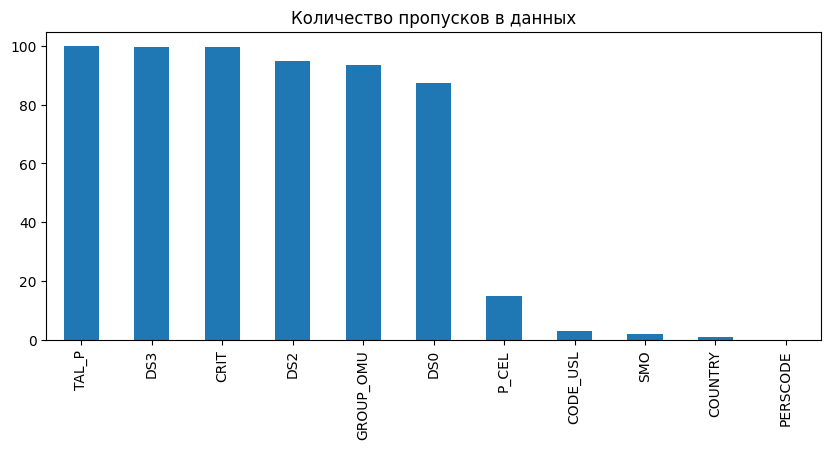

In [15]:
data_null.plot(
    kind='bar',
    figsize=(10, 4),
    title='Количество пропусков в данных'
)

Всего пропуски содержат 10 признаков, у 6-и их количество очень велико, что наводит мысль на их удаление, однако целесообразно предварительно оценить характе данных в этих признаках и их взаимосвязь с целевыми переменными и другими признаками. Попробуем сначала классифицировать признаки по типам переменных и оценить признаки с пропусками.

посчитаем количество уникальных значений признаков и попробуем их классифицировать.

In [16]:
data_columns = data.columns

for col in data_columns:
    num = 0
    num = data[col].nunique()
    print(col, num)

UUID 4029853
month 12
SMO 3
FILENAME 4
MO 43
TYPE_MO 6
NPR_DATE 686
VIDPOM 7
USL_OK 4
FOR_POM 3
P_CEL 9
DS_ONK 2
C_ZAB 3
PROFIL 55
BED_PROFILE 52
SPEC_CODE 56
DS0 3151
DS1 5749
DS1_PR 2
DS2 3035
DS3 638
CODE_USL 1163
KOL_USL 103
GROUP_OMU 27
ORIT 16
REAB 2
R_ISDENT 2
NPR_MO 65
IDDOKT 3505
TYPE_DOC 2
KD 403
CODE_OTD 677
NHISTORY 3477976
DN 4
TAL_P 338
DET 2
ED_COL 2108
VPOLIS 3
NOVOR 2
PERSCODE 461322
BIRTHDAY 30442
SEX 2
AGE 105
COUNTRY 21
DATE_1 598
DATE_2 414
ISHOD 17
RSLT 49
TARIF 3552
SUMV 7526
OPLATA 4
KSLP 26
CRIT 442
IDSP 7
VBR 1
MEE 3
EKMP 3
OKFS 4
MO_level 5
attach 15
population 17


Предварительно распределим признаки по группам

- числовые признаки **'KOL_USL','ORIT','KD','AGE','TARIF','SUMV','KSLP','population','attach'** 
- бинарные признаки **'DS_ONK','DS1_PR','REAB','R_ISDENT','DET','NOVOR','SEX','VBR'**
- категориальные признаки **'FILENAME','TYPE_MO','VIDPOM','USL_OK','FOR_POM','P_CEL','C_ZAB','DN','VPOLIS','OPLATA','IDSP','OKFS','MO_level','TYPE_DOC'**
- предположительно категориальные признаки **'month','MO','PROFIL','BED_PROFILE','SPEC_CODE','NPR_MO','IDDOKT','CODE_OTD','ISHOD','RSLT'**
- неопределенные признаки **'UUID','NPR_DATE','DS0','DS1','DS2','DS3','SMO','GROUP_OMU','NHISTORY','ED_COL','PERSCODE','BIRTHDAY','DATE_1','DATE_2','CRIT','CODE_USL','TAL_P','COUNTRY','VBR'**

Оценим удельную долю проведенных экспертиз в отношении всех случаев лечения, для получения представления о дисбалансе целевых переменных.

In [17]:
all_count = data['MEE'].count()
MEE_count = data[data['MEE'] != -1]['MEE'].count()
EKMP_count = data[data['EKMP'] != -1]['EKMP'].count()
print('Доля экспертиз МЭЭ  {}%'.format(round(MEE_count/all_count*100, 2)))
print('Доля экспертиз ЭКМП {}%'.format(round(EKMP_count/all_count*100, 2)))

Доля экспертиз МЭЭ  1.07%
Доля экспертиз ЭКМП 0.45%


Можно отметить резко выраженный дисбаланс целевых переменных.

Проанализируем прицельно неоднозначные признаки, отнесенные к группе *неопределенные признаки*.

признаки *UUID, NHISTORY, PERSCODE, BIRTHDAY* содеражт уникальные идентификаторы случаев медицинской помощи и пациентов. Мы видим, что пациентов существенно меньше чем случаев лечения, а так же количество номеров истории болезни меньше чем количество случаев. Таким образом один пациент, очевидно, мог лечиться несколько раз и в одну историю болезни может входить несколько случаев. А значит на основании признаков *NHISTORY и PERSCODE* можно создать новые признаки - количество случаев лечения для пациента и количество случаев для истории болезни, после чего удалим исходные признаки.

In [18]:
convert_dict_PERSCODE = data.groupby(['PERSCODE'])['UUID'].count().to_dict()
convert_dict_NHISTORY = data.groupby(['NHISTORY'])['UUID'].count().to_dict()

data['number_of_cases'] = data['PERSCODE'].map(
    lambda x: convert_dict_PERSCODE.get(x, x))
data['count_number_history'] = data['NHISTORY'].map(
    lambda x: convert_dict_NHISTORY.get(x, x))

drop_list = ['UUID', 'NHISTORY', 'PERSCODE', 'BIRTHDAY']

проанализируем признак *TAL_P*.

In [19]:
data[data['TAL_P'].isnull()]['FILENAME'].value_counts()

FILENAME
H    3650276
D     331323
C      51201
Name: count, dtype: int64

Здесь мы можем увидеть, что ожидаемо, даты планируемой госпитализации по ВМП (высоко технологическая медицинская помощь) нет в случаях, не относящихся к ВМП. Информация о принадлежности случая к ВМП содержится в поле **FILENAME**, а о дате направления на лечение в поле **NPR_DATE**. Таким образом признак не несёт новой информации и вероятно будет линейно зависим с выше упомянутыми признаками, поэтому удалим его.

In [21]:
drop_list.append('TAL_P')


Логически связанными являются так же поля **"DS0"** - диагноз направления, **"DS2"** - сопутствующий диагноз, **"DS3"** - диагноз осложнения, пропущенные в подавляющем количестве случаев. Пропуски в даном случае означаю отсутствие диагноза, таким образом их можно преобразовать в бинарные переменные - наличие/отсутствие признака. Так же для **"DS0"** проверим совпадение со значенеим поля **"DS1"** - основной диагноз, что является важным критерием для оценки догоспитальной диагностики и возможных дефектов оказания медицинской помощи.

In [22]:
coincidence = data[data['DS1'] == data['DS0']]['DS0'].count()
count_DS0 = data['DS0'].count()
print('Процент совпадений направительного и основного дианозов: ',
      round(coincidence/count_DS0*100, 2))
print('Количество не совпадений направительного и основного дианозов: ',
      count_DS0-coincidence)

Процент совпадений направительного и основного дианозов:  99.73
Количество не совпадений направительного и основного дианозов:  1351


Как мы можем видеть процент несовпадения не велик, однако попробуем создать признак **divergence_DS* -"расхождение направительного и основного диагнозов".

In [23]:
data['divergence_DS'] = data[['DS1', 'DS0']].apply(ds0_ds1, axis=1)
data['divergence_DS'].value_counts()

divergence_DS
-1    3527790
 1     505004
 0       1351
Name: count, dtype: int64

Признак **"CRIT"** так же имеет большое количество уникальных значений и большое количество пропусков, посмотрим на его взаимосвязь с признаком **USL_OK** - условия оказания медицинской помощи.

In [25]:
data[~data['CRIT'].isnull()]['USL_OK'].value_counts()

USL_OK
1    6790
2    6369
Name: count, dtype: int64

Признак сочетается со случаями лечения в круглосуточном и дневном стационарах. Посмотрим на процент стационарных случаев в общей массе и процент применения признака **CRIT**.

In [27]:
print(round(data['USL_OK'].value_counts()/data['UUID'].count()*100, 2), '%')
KS_crit = data[data['USL_OK'] == 1]['CRIT'].count()data[data['USL_OK'] == 1]['UUID'].count()
DS_crit = data[data['USL_OK'] == 2]['CRIT'].count()data[data['USL_OK'] == 2]['UUID'].count()
print('Процент применения признака CRIT в КС {}%'.format(round(KS_crit*100, 2)))
print('Процент применения признака CRIT в ДС {}%'.format(round(DS_crit*100, 2)))

USL_OK
3    93.46
4     3.01
1     2.54
2     0.99
Name: count, dtype: float64 %
Процент применения признака CRIT в КС 6.62%
Процент применения признака CRIT в ДС 15.87%


Как мы можем увидеть имеет место быть заметный процент использования признака, который может иметь значение для определения потенциально дефектных случаев посколькоу используется для обозначения особых ситуаций при формирвоании тарифа, отстутсвие означает что признак не применялся. Заменим его на бинарный.

Признак **"GROUP_OMU"** так же имеет относительно не большое количество уникальных значений и большое количество пропусков, это маркер типа диагностических исследований, для других видов медицинской помощи не применяется. Посмотрим количество и спектр уникальных значений. 

In [28]:
data[~data['GROUP_OMU'].isnull()]['GROUP_OMU'].value_counts()

GROUP_OMU
7.1     68496
7.3     42633
4.1     30381
4.3     26255
1.1.    24080
3.5     18085
2.1.    14541
98       9227
1.2.     7622
6.4.     4308
6.5.     3878
2.2.     3754
3.2      3682
6.3.     2036
92       1776
4.2      1749
3.1       247
99        234
3.3       214
91        152
93        114
5.5        67
3.4        26
5.2        14
5.3        13
5.4        12
5.1         1
Name: count, dtype: int64

Для сокращения количества категорий их можно сгруппировать укрупнив группы по значению до первой точки и сгруппировав вместе 91,92,93 - различные варианты школ сахарного диабета и 98,99 телемедицинские консультации. По получившимся укрупненным категориям создадим категориальные переменные. Пустые значения заменим на "NO_OMU". 

In [30]:
data['GROUP_OMU'] = data['GROUP_OMU'].map(group_omu_convert)
data['GROUP_OMU'].value_counts()

GROUP_OMU
NO_OMU    3770548
7          111129
4           58385
1           31702
3           22254
2           18295
6           10222
9            9461
8            2042
5             107
Name: count, dtype: int64

Признак **"P_CEL"** - (цель обращения за медицинской помощью) имеет умереное количество пропущенных значений, посмотрим в каких типах файлах это встречается.

In [32]:
data[data['P_CEL'].isnull()]['FILENAME'].value_counts()

FILENAME
D    331323
H    254377
C      8300
T      1345
Name: count, dtype: int64

Какова частота встречаемости различных его значений.

In [34]:
data['P_CEL'].value_counts()

P_CEL
Посещение по другим обстоятельствам    1100378
Посещение по заболеванию               1037747
Обращение по заболеванию                738719
Посещениe в неотложной форме            352063
Диспансерное наблюдение                 163084
Обращение с профилактической целью       19578
Патронаж                                 10750
Комплексное обследование                  9718
Aктивное посещение                        6763
Name: count, dtype: int64

Условия оказания медицинской помощи для пропущенных значений цели для типов файлов "Н", где сгруппированы различные случаи и однозначно отнести их все к определенной цели невозможно.

In [36]:
data[((data['P_CEL'].isnull()) & (data['FILENAME'] == 'H'))
     ]['USL_OK'].value_counts()

USL_OK
4    121395
1     96520
2     36462
Name: count, dtype: int64

Наиболее часто встречающиеся вариант это: "Посещение по другим обстоятельствам", однако заменить наиболее частой категорией все пропущенные значения в данном случае не верно. Поскольку случаи медицинской помощи в различных вайлах существенно различаются по целям. Посему для типов файлов:

- "D" - профиалктических мероприятий заменим пропуски на "Обращение с профилактической целью"
- "Т" - высокотехнологическая медицинская помощ, "С" - онкология и "Н" - основные случаи лечения (где мы видим по условиям оказания случаи скорой и неотложно помощи и дневной и круглосуточный стационар) на "Обращение по заболеванию".

В поле **CODE_USL** - услуга при оказании медицинской помощи пропусков не много но и заменить их каким то из имеющихся значений не представляется возможным. Поэтому заменим на значение "NO_USL". 

В поле **SMO** - код страховой медицинской организации (СМО) пропусков относительно не много, эти случай по пациентам, застрахованным за пределами региона. Заменим их на значение "MTR" - межтерриториальные расчёты.

В поле **COUNTRY** - гражданство так же не много пропусков и тут можно заменить наиболее распространенным вариантом, для этого определим частоты уникальных значений.

In [38]:
data['COUNTRY'].value_counts()

COUNTRY
643.0    3977527
417.0       4874
804.0       2410
762.0       2231
31.0        1958
112.0       1491
398.0       1059
860.0        709
51.0         512
498.0        213
268.0         66
792.0         14
484.0         11
275.0          9
0.0            9
70.0           5
428.0          5
120.0          4
897.0          2
440.0          2
356.0          1
Name: count, dtype: int64

Наибольшая частота у Российского гражданства "643" заменим пропуски на это значение. Все остальные категории можно заменить на *other*. 

Рассмотрим признак *NPR_DATE* - Дата направления на лечение, из нее можно создать новый признак:
- бинарный признак - *DIFF_NPR_DATE_DATE_1* - отличие даты направления от даты начала случая лечения

После создания нового признака старый удалим.

In [40]:
data['NPR_DATE'] = pd.to_datetime(data['NPR_DATE'], format='%d.%m.%Y')
data['DATE_1'] = pd.to_datetime(data['DATE_1'], format='%d.%m.%Y')
data['DIFF_NPR_DATE_DATE_1'] = data[[
    'NPR_DATE', 'DATE_1']].apply(diff_dates, axis=1)
drop_list.append('NPR_DATE')

Рассмотрим признак *ED_COL* - Количество единиц оплаты визуализируем распределение признака 

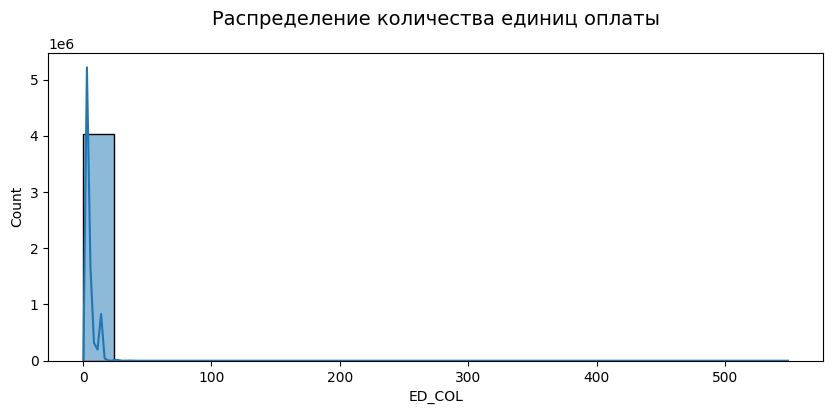

In [41]:
fig, axes = plt.subplots(figsize=(10, 4))
sns.histplot(data['ED_COL'],
             kde=True,
             ax=axes)
axes.set_title('Распределение количества единиц оплаты',
               pad=20,
               size=14)
plt.show()

Распределение резко смещено влево и имеет длинный правый хвост. Подавляющее большинство случаев имеют значением менее 20, посмотрим как они распределенились по условиям оказания медицинской помощи.

In [42]:
data[data['ED_COL'] > 20]['USL_OK'].value_counts()

USL_OK
1    2142
2    1524
3     801
Name: count, dtype: int64

Для стационаров *USL_OK* 1 и 2 это длительные случаи лечения, а вот для поликлиники *USL_OK* 3 картина не типична слишком много единиц оплаты, посмотрим что это за случаи.

In [44]:
data[((data['ED_COL']>20)&(data['USL_OK']==3))].head() 

UUID  month      SMO FILENAME      MO  \
32988  649EAC32-0FD5-4A6F-BB83-7F2D99A8984F      1  83005.0        H  830011   
43371  B6DB279E-88F4-4FEA-9667-97F5CB867FCC      1  83008.0        H  830111   
46159  6BED4B6B-87DB-4A42-A5A8-F0B3579274CA      1  83001.0        H  830044   
49485  E81C4FAD-B8E7-40BE-887B-5E1D2EF7D5FA      1  83008.0        H  830011   
60595  CB5FEE2F-0F2F-4AE4-997B-1B2FF418EA8A      1  83008.0        H  830111   

      TYPE_MO   NPR_DATE  VIDPOM  USL_OK  FOR_POM  \
32988      GB 2023-01-10      13       3        3   
43371    OTER 2023-01-11      11       3        3   
46159    OTER 2023-01-11      13       3        3   
49485      GB 2023-01-12      13       3        3   
60595    OTER 2023-01-13      11       3        3   

                                     P_CEL  DS_ONK  C_ZAB  PROFIL  \
32988             Посещение по заболеванию       0      3      63   
43371  Посещение по другим обстоятельствам       0      2      85   
46159             Посещение по заболеванию       0      1      89   
49485             Посещение по заболеванию       0      3      63   
60595  Посещение по другим обстоятельствам       0      2      85   

       BED_PROFILE  SPEC_CODE  DS0    DS1  DS1_PR  DS2  DS3    CODE_USL  \
32988  no_hospital        326  NaN  K07.3       0  NaN  NaN  A12.07.003   
43371  no_hospital        378  NaN  K04.5       0  NaN  NaN  A06.07.010   
46159  no_hospital        353  NaN  K04.5       0  NaN  NaN  A06.07.003   
49485  no_hospital        326  NaN  K07.3       0  NaN  NaN  A12.07.003   
60595  no_hospital        378  NaN  K04.5       0  NaN  NaN  A06.07.010   

       KOL_USL GROUP_OMU  ORIT  REAB  R_ISDENT  NPR_MO       IDDOKT  TYPE_DOC  \
32988        8    NO_OMU     0     0         1  830011  13176003017         1   
43371       10    NO_OMU     0     0         1  830111  13006240992         1   
46159        8    NO_OMU     0     0         1  830044   7035284947         1   
49485        6    NO_OMU     0     0         1  830011  13176003017         1   
60595       10    NO_OMU     0     0         1  830111  13006240992         1   

       KD          CODE_OTD      NHISTORY  DN TAL_P  DET  ED_COL  VPOLIS  \
32988   1   991100113001006   2782_830011   0   NaN    0   20.59       3   
43371   1  1030300014001001  E4598_830111   0   NaN    0   22.79       3   
46159   1   992900000001003  19328_830044   0   NaN    0   21.18       3   
49485   1   991100113001006   3251_830011   0   NaN    0   31.19       3   
60595   1  1030300014001001  E7096_830111   0   NaN    0   20.28       3   

       NOVOR              PERSCODE    BIRTHDAY  SEX  AGE  COUNTRY     DATE_1  \
32988      0  4396499725000077_ЗМД  24.03.2005    1   17    643.0 2023-01-10   
43371      0  1155300873000025_ГТЯ  26.04.1996    2   26    643.0 2023-01-11   
46159      0  8356830843000301_СВГ  06.03.1961    1   61    643.0 2023-01-11   
49485      0  8390689787000158_ПКС  12.09.2013    2    9    643.0 2023-01-12   
60595      0  8354010896000365_МБА  03.05.1989    2   33    643.0 2023-01-13   

           DATE_2  ISHOD  RSLT  TARIF      SUMV  OPLATA  KSLP CRIT  IDSP  VBR  \
32988  10.01.2023    301   301  618.0  12724.62       1   0.0  NaN    29    0   
43371  11.01.2023    301   301  618.0  14084.22       1   0.0  NaN    29    0   
46159  11.01.2023    304   301  618.0  13089.24       1   0.0  NaN    29    0   
49485  12.01.2023    301   301  618.0  19275.42       1   0.0  NaN    29    0   
60595  13.01.2023    301   301  618.0  12533.04       1   0.0  NaN    29    0   

       MEE  EKMP  OKFS  MO_level  attach  population  number_of_cases  \
32988    1    -1    13       3.1  118020      106764             11.0   
43371   -1    -1    16       1.0       0       36552             14.0   
46159   -1    -1    16       1.0       0       48693              1.0   
49485   -1    -1    13       3.1  118020      106764             28.0   
60595   -1    -1    16       1.0       0       36552             15.0   

       count_number_hi

И тут мы можем предположить, что это случаи стоматологии, проверим

In [46]:
data[((data['ED_COL'] > 20) & (data['USL_OK'] == 3)
      & (data['R_ISDENT'] != 1))].head()

Empty DataFrame
Columns: [UUID, month, SMO, FILENAME, MO, TYPE_MO, NPR_DATE, VIDPOM, USL_OK, FOR_POM, P_CEL, DS_ONK, C_ZAB, PROFIL, BED_PROFILE, SPEC_CODE, DS0, DS1, DS1_PR, DS2, DS3, CODE_USL, KOL_USL, GROUP_OMU, ORIT, REAB, R_ISDENT, NPR_MO, IDDOKT, TYPE_DOC, KD, CODE_OTD, NHISTORY, DN, TAL_P, DET, ED_COL, VPOLIS, NOVOR, PERSCODE, BIRTHDAY, SEX, AGE, COUNTRY, DATE_1, DATE_2, ISHOD, RSLT, TARIF, SUMV, OPLATA, KSLP, CRIT, IDSP, VBR, MEE, EKMP, OKFS, MO_level, attach, population, number_of_cases, count_number_history, divergence_DS, DIFF_NPR_DATE_DATE_1]
Index: []

Предположение подтверждается - в поликлинике это случаи стоматологической помощи с большим объёмом работ. 

Длительные случаи и большой объём для стоматологии подозрительны в части наличия дефектов, создадим бинарный признак *long_case* на основании *ED_COL*: 1 - количетсво более 20 и 0 - менее 20. Исходный признак удалим.

In [48]:
data['long_case'] = data['ED_COL'].map(lambda x: 1 if x > 20 else 0)
drop_list.append('ED_COL')

Признаки *DATE_1* и *DATE_2* даты начала и завершения случая лечения. На их основании можно сделать признаки:
- день недели начала и окончания лечения

после чего признаки удалим

In [49]:
data['DATE_2'] = pd.to_datetime(data['DATE_2'], format='%d.%m.%Y')
data['week_day_DATE_1'] = data['DATE_1'].dt.weekday
data['week_day_DATE_2'] = data['DATE_2'].dt.weekday
drop_list = drop_list+['DATE_1', 'DATE_2']

Признак 'VBR' содержит одинаковые значения, а значит не несёт информации - удалим его.

In [50]:
drop_list.append('VBR')

**Общий взгляд на данные**

В объединенном датасете 4034114 строк, 59 признаков, помимо целевых переменных.

Пропуски фиксируются в столбцах **"DS0", "DS2", "DS3", "GROUP_OMU", "P_CEL", "CODE_USL", "SMO", "COUNTRY", "PERSCODE", "CRIT"** и **"TAL_P"**.

Все признаки можно разделить на следующие группы:

**Категориальные переменные**
* 'FILENAME' - Тип реестра счетов по имени файла: 
    - С-онкология, 
    - D-профилактические мероприятия, 
    - Н-основные случаи, 
    - Т-высокотехнологическая медицинская помощь
* 'TYPE_MO' - Тим медицинской организации по организационной структуре:
    - *CRB* - центральные районные больницы, 
    - *GB* - городские больницы, *OKB*-окружная клиническая больница,
    - *FAP* - фельдшерско акушерский пункт, 
    - *VED* - ведомственные, *OTER*-иные.
* 'VIDPOM' - Вид медицинской помощи:
    - 2 - скорая, в том числе специализированная, медицинская помощь,
    - 11 - первичная доврачебная медико-санитарная помощь,
    - 12 - первичная врачебная медико-санитарная помощь,
    - 13 - первичная специализированная медико-санитарная помощь,
    - 14 - первичная медико-санитарная помощь с применением телемедицинских технологий,
    - 31 - специализированная медицинская помощь,
    - 32 - высокотехнологичная специализированная медицинская помощь.
* 'USL_OK' - Условия оказания медицинской помощ:
    - 1 - круглосуточный стационар,
    - 2 - дневной стационар,
    - 3 - амбулаторно - поликлиническая помощь,
    - 4 - скорая и неотложная помощь
* 'FOR_POM' - Форма медицинской помощи:
    - 1 - экстренная,
    - 2 - неотложная,
    - 3 - плановая
* 'P_CEL' - Цель обращения за медицинской помощью
* 'C_ZAB' - Характер основного заболевания:
    - 1 - Острое,
    - 2 - Ранее установленное хроническое,
    - 3 - Впервые в жизни установленное хроническое
* 'DN' - Признак диспансерного наблюдения:
    - 1 - взят,
    - 2-состоит,
    - 3 - не подлежит диспансерному наблюдению,
    - 0 - нет данных.
* 'VPOLIS' - Тип медицинского страхового полиса:
    - 1 - Полис ОМС старого образца,
    - 2 - Временное свидетельство, подтверждающее оформление полиса обязательного медицинского страхования, 
    - 3 - Полис ОМС единого образца
* 'OPLATA' - Тип оплаты:
    - 1 – полная,
    - 4 – доплата по МЭК,
    - 5 – доплата по превышению
* 'IDSP' - Код способа оплаты:
    - 24 - За вызов скорой медицинской помощи,
    - 28 - За медицинскую услугу,
    - 29 - За посещение,
    - 30 - За обращение (законченный случай),
    - 32 - За законченный случай лечения заболевания,
    - 33 - За законченный случай лечения заболевания, включенного в соответствующую группу заболеваний (в том числе клинико-статистические группы заболеваний),
    - 36 - По подушевому нормативу финансирования в сочетании с оплатой за вызов скорой медицинской помощи
* 'OKFS' - Код общероссийского классификатора форм собственности:
    - 12 - федеральная собственность,
    - 13 - собственность субъекта РФ,
    - 16 - частная собственность,
    - 23 - собственность иностранных юридических лиц
* 'MO_level' - Уровень медициской помощи
* 'TYPE_DOC' - Тип медицинского работника, оказавшего медицинскую услугу:
    - 1 - врач,
    - 2 - фельдшер
* 'SMO' - Код страховой медицинской организации (далее СМО), присутствует только для СМО, действующих на территории региона.
* 'month' - отчЁтный месяц
* 'MO' - Код медицинской организации в федеральном справочнике МО
* 'PROFIL' - Код профиля медицинской помощи 
* 'BED_PROFILE' - Код профиля койки
* 'SPEC_CODE' - Код специальности медицинского работника, оказавшего медицинскую услугу
* 'NPR_MO' - Код МО в федеральном справочнике МО, направившей на лечение
* 'IDDOKT' - Идентификатор медицинского работника, оказавшего медицинскую услугу
* 'CODE_OTD' - Код отделения лечения в региональном справочнике
* 'ISHOD' - Код исхода лечения
* 'CODE_USL' - Код оказанной услуги 

**бинарные признаки**
* 'DS_ONK' - Признак подозрения на злокачественное новобразование:
    - 1 - есть подозрение,
    - 0 - нет
* 'DS1_PR' - Признак впервые установленного диагноза:
    - 1 - установлен впервые,
    - 0 - нет 
* 'REAB' - Признак случая медицинской реабилитации:
    - 1 - случай реабилитации,
    - 9 - нет 
* 'R_ISDENT' - Признак стоматологического случая:
    - 1 - случай стоматологии,
    - 0 - нет
* 'DET' - Признак детского профиля:
    - 1 - детский профиль,
    - 0 - взрослый
* 'NOVOR' - Признак новорожденного:
    - 1 - новорожденный,
    - 0 - нет
* 'SEX' - Пол пациента:
    - 1 - мужской,
    - 2 - женский
* 'VBR' - Признак оказания помощи мобильной медицинской бригадой:
    - 1 - помощь оказана ММБ,
    - 0 - нет
* 'DS0' - Диагноз направления на лечение:
    - 1- диагноз присутствует,
    - 0 - нет
* 'DS2' - Сопутствующий диагноз:
    - 1- диагноз присутствует,
    - 0 - нет
* 'DS3' - Диагноз осложнения основного заболевания:
    - 1- диагноз присутствует,
    - 0 - нет

**числовые признаки**
* 'KOL_USL' - Количество услуг (кратность услуги)
* 'ORIT' - Количество дней пребывания в реанимационном отделении
* 'KD' - Количесво койкодней стационара
* 'AGE' - Возраст на дату завершения случая лет
* 'TARIF' - Тариф на оплату случая лечения
* 'SUMV' - Сумма выставленная на оплату
* 'KSLP' - Коэффициент сложности лечения стационарных больных
* 'attach' - Количество прикрепленного населения к медицинской организации
* 'population' - Население в населенном пункте, где находится медицинская организация

**преобразуемые / удаляемые признаки**
* 'UUID' - Уникальный иденти-фикатор случая медицинской помощи 
* 'NPR_DATE' - Дата направления на лечение
* 'GROUP_OMU' - Код группы диагностических услуг
* 'NHISTORY' - Номер истории болезни
* 'TAL_P' - Дата направления на лечение по высокотехнологической медицинской помощи
* 'DATE_1' - Дата начала случая лечения
* 'DATE_2' - Дата завершения случая лечения
* 'DS1' - Основной клинический диагноз
* 'PERSCODE' - Уникальный идентификатор пациента
* 'BIRTHDAY' - Дата рождения пациента
* 'COUNTRY' - Код национальности
* 'CRIT' - Дополнительный критерий применения схем лечения или технологий
* 'ED_COL' - Количество единиц оплаты
* 'RSLT' - Код результата лечения

**Целевые переменные**
* 'MEE' - Результат МЭЭ -1 – МЭЭ не проводилась, 0 – дефектов не найдено, 1 – найден дефект
* 'EKMP' - Результат ЭКМП -1 – ЭКМП не проводилась, 0 – дефектов не найдено, 1 – найден дефект

### 1.2. Устраним пропуски

In [51]:
# создаём словарь 'имя_столбца': число (признак), на который надо заменить пропуски

values = {
    'DS0': 0,
    'DS2': 0,
    'DS3': 0,
    'GROUP_OMU': 'NO_OMU',
    'CRIT': 0,
    'P_CEL': 'Обращение по заболеванию',
    'CODE_USL': 'NO_USL',
    'SMO': 'MTR',
    'COUNTRY': 643
}

data = data.drop(drop_list, axis=1)

data.loc[data['FILENAME'] == 'D', 'P_CEL'] = data.loc[data['FILENAME']
                                                      == 'D', 'P_CEL'].fillna('Обращение с профилактической целью')
# заполняем оставшиеся записи константами в соответствии со словарем values
data = data.fillna(values)
# преобразуем признаки DS0, DS2, DS3, CRIT
data['DS0'] = data['DS0'].apply(lambda x: 0 if x == 0 else 1)
data['DS2'] = data['DS2'].apply(lambda x: 0 if x == 0 else 1)
data['DS3'] = data['DS3'].apply(lambda x: 0 if x == 0 else 1)
data['CRIT'] = data['CRIT'].apply(lambda x: 0 if x == 0 else 1)

data = data.dropna(axis=0)

Проверим результат

In [52]:
temp_null = data.isnull().mean()*100
data_null = temp_null[temp_null>0].sort_values(ascending = False)
data_null

Series([], dtype: float64)

### 1.3. Преобразуем типы переменных 


На основании результатов ранее проведенного анализа и классификации переменных преобразуем типы переменных исходного датасета для облегчения дальнейшей работы и уменьшения количества занимаемой датасетом памяти.

In [54]:
columns_dict = {'int8': ['DS_ONK', 'DS1_PR', 'ORIT', 'REAB', 'R_ISDENT', 'DIFF_NPR_DATE_DATE_1',
                         'NOVOR', 'SEX', 'AGE', 'MEE', 'EKMP', 'long_case', 'count_number_history',
                         'CRIT', 'DET', 'DS0', 'DS2', 'DS3', 'divergence_DS', 'week_day_DATE_1', 'week_day_DATE_2'],
                'int16': ['KOL_USL', 'KD'],
                'int32': ['attach', 'population'],
                'float32': ['TARIF', 'SUMV', 'KSLP'],
                'category': ['ISHOD', 'RSLT', 'OKFS', 'PROFIL', 'OPLATA', 'IDSP', 'TYPE_DOC', 'DN', 'VPOLIS',
                             'C_ZAB', 'VIDPOM', 'USL_OK', 'FOR_POM', 'month', 'FILENAME', 'TYPE_MO', 'P_CEL',
                             'CODE_USL', 'GROUP_OMU', 'DS1', 'SMO',  'BED_PROFILE', 'MO_level',
                             'MO', 'SPEC_CODE', 'NPR_MO', 'IDDOKT', 'COUNTRY'],
                'object': ['CODE_OTD']
                }

data = type_converter(data, columns_dict)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4034005 entries, 0 to 4040924
Data columns (total 58 columns):
 #   Column                Dtype   
---  ------                -----   
 0   month                 category
 1   SMO                   category
 2   FILENAME              category
 3   MO                    category
 4   TYPE_MO               category
 5   VIDPOM                category
 6   USL_OK                category
 7   FOR_POM               category
 8   P_CEL                 category
 9   DS_ONK                int8    
 10  C_ZAB                 category
 11  PROFIL                category
 12  BED_PROFILE           category
 13  SPEC_CODE             category
 14  DS0                   int8    
 15  DS1                   category
 16  DS1_PR                int8    
 17  DS2                   int8    
 18  DS3                   int8    
 19  CODE_USL              category
 20  KOL_USL               int16   
 21  GROUP_OMU             category
 22  ORIT                  i

# 2. Исследование и проектирование признаков

## 2.1. Категориальные переменные

Рассчитаем описательные статистики для категориальных переменных

In [55]:
cat_describe = data.describe(include='category')
cat_describe

month        SMO FILENAME       MO  TYPE_MO   VIDPOM   USL_OK  \
count   4034005  4034005.0  4034005  4034005  4034005  4034005  4034005   
unique       12        4.0        4       43        6        7        4   
top          12    83008.0        H   830011       GB       12        3   
freq     428470  1952157.0  3650137   796947  2205211  1777885  3770047   

        FOR_POM                                P_CEL    C_ZAB   PROFIL  \
count   4034005                              4034005  4034005  4034005   
unique        3                                    9        3       55   
top           3  Посещение по другим обстоятельствам        3       68   
freq    3507570                              1100361  2872943   992744   

        BED_PROFILE  SPEC_CODE      DS1     CODE_USL GROUP_OMU   NPR_MO  \
count       4034005    4034005  4034005      4034005   4034005  4034005   
unique           52         56     5743         1164        10       65   
top     no_hospital        332    J06.9  B01.031.003    NO_OMU   830011   
freq        3891390     854472   401680       308791   3770408   796840   

            IDDOKT  TYPE_DOC       DN   VPOLIS    COUNTRY    ISHOD     RSLT  \
count      4034005   4034005  4034005  4034005  4034005.0  4034005  4034005   
unique        3505         2        4        3       21.0       17       49   
top     6725875096         1        0        3      643.0      306      301   
freq         15620   3663517  3702683  4030339  4018426.0  1301793  2573092   

         OPLATA     IDSP     OKFS   MO_level  
count   4034005  4034005  4034005  4034005.0  
unique        4        7        4        5.0  
top           1       29       13        3.1  
freq    3979208  2444403  3869111  1206944.0

По результатам первичного анализа описательных статистик можно увидеть, что количество значений каждой из переменых сильно различается.
Категориальные переменные данного набора данных можно разделить на 2 группы, с не большим количеством признаков - до 10 и с большим - более 10. Визуализируем первую группу. 

In [57]:
cat_cols = []
for index, value in cat_describe.iloc[1].items():
    if value <= 10:
        cat_cols.append(index)

cat_cols = cat_cols+['divergence_DS', 'week_day_DATE_1', 'week_day_DATE_2']

# для красивого отображения удалим из списка 'P_CEL', постороим этот график отдельно
cat_cols.remove('P_CEL')

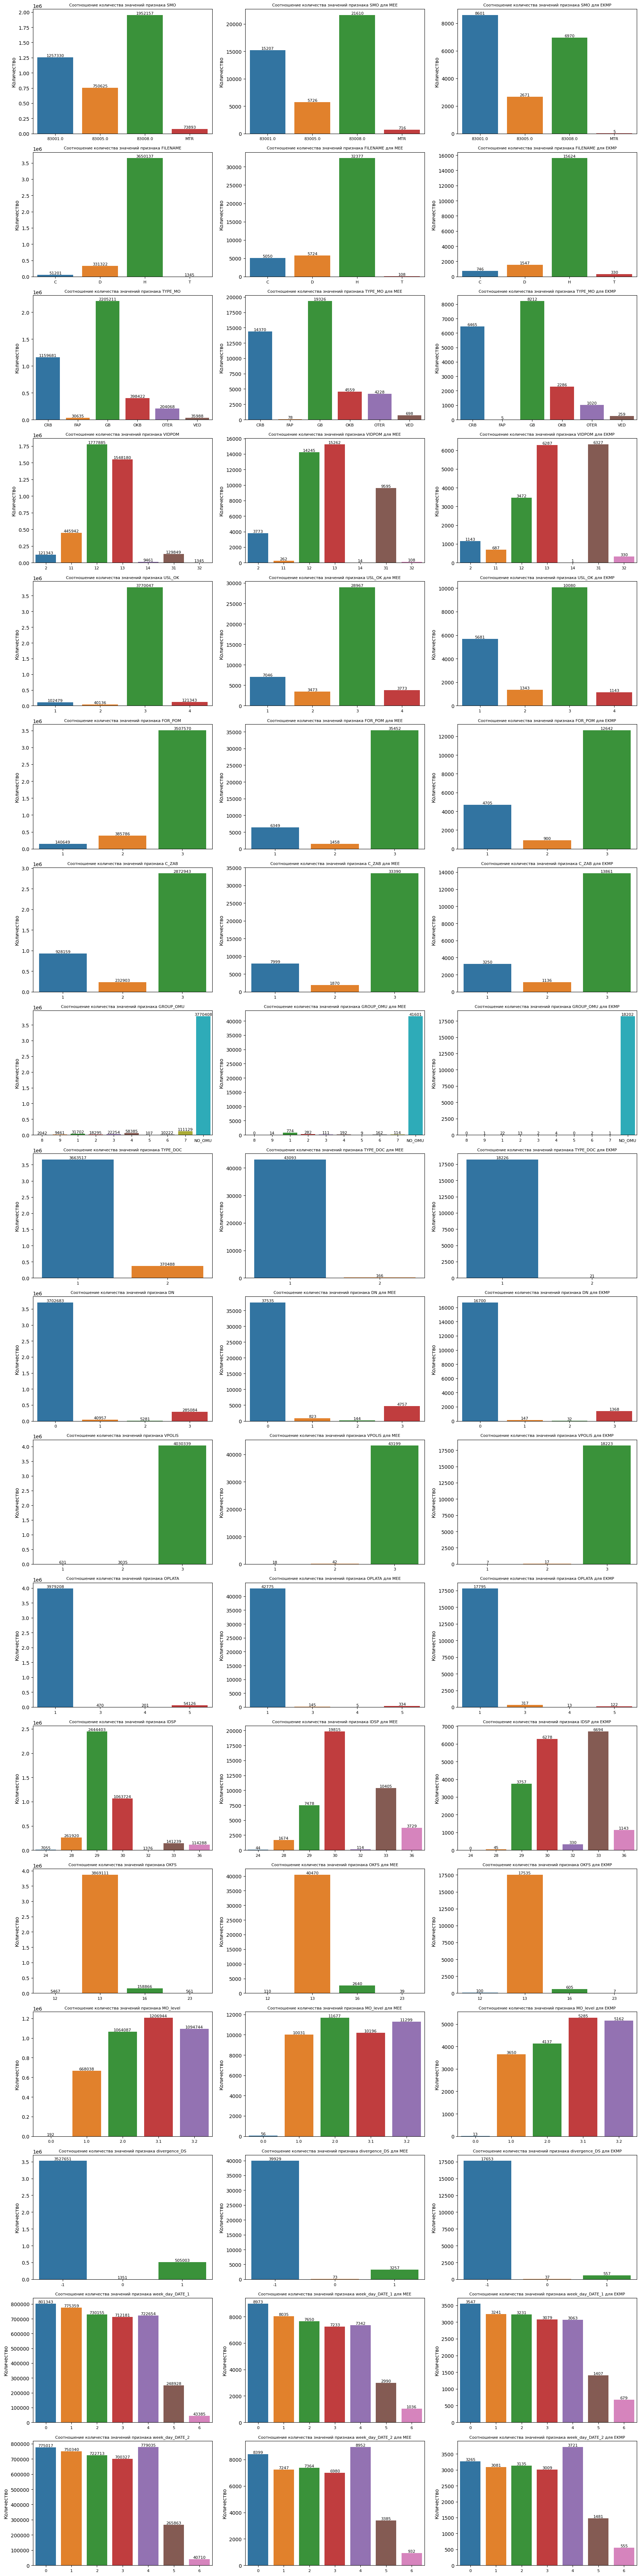

In [58]:
cat_graf_build(data,cat_cols)

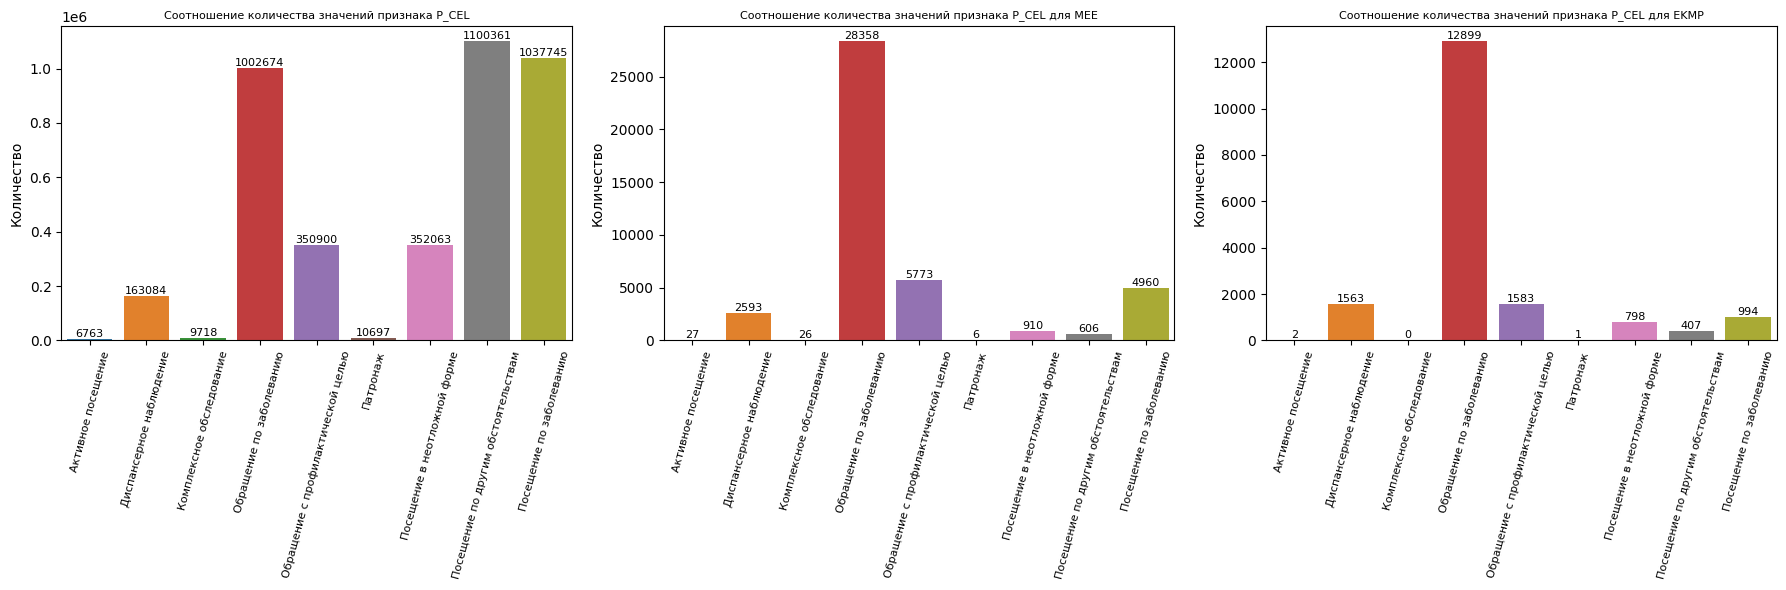

In [59]:
cat_graf_build(data,['P_CEL'],['P_CEL'],6)

- **SMO**: общее распределение случаев по страхвщикам соответсвует распределению страхового поля в регионе, однако во взаимосвязи с целевыми переменными картина меняется. Для МЭЭ доля страховщиков сопоставимы с общими, для ЭКМП выбивается вперед СМО 83001, а доля СМО 83008 снижается, что может повлиять на оценки алгоритма. 
- **FILENAME**: можно отметить заметную долю экспертиз по онкологии и пофмероприятиям, большую чем их доля в основном распределении.
- **TYPE_MO**: распределение во взаимосвязи с целевыми переменными по типам МО в целом повторяет основное распределение, общают на себя внимание категории с маленьким количеством экземпляров, их целесообразно объединить
- **VIDPOM**: можно отметить среди случаев экспертиз большую долю специализированной медицинской помощи и снижение доли первичной врачебной помощи, а так же крайне малочисленные категории, которые целесообразно объединить с близкими по виду медицинской помощи категориями. 14	первичная медико-санитарная помощь с применением телемедицинских технологий с 13	первичная специализированная медико-санитарная помощь, 32	высокотехнологичная специализированная медицинская помощь с 31	специализированная медицинская помощь.
- **USL_OK**: выраженный дисбаланс в общем распределении объясним большой удельной долей амбулаторной помощи. Однако применительно к целемым переменным картина выравнивается и доля амбулаторной помощи заметно снижается.
- **FOR_POM**: если для основной выборки доля экстренной и неотложной помощи мала, то во взаимосвязи с целевыми переменными значительно растёт доля экстренной помощи, при некротором снижении неотложной.
- **C_ZAB**: можно отметить преобладающее количество ранее утсрановленных диагнозов хронических заболеваний, при заметном количесстве острых заболеваний. Данное соотношение в целом сохраняется и применительно к целевым переменным.
- **GROUP_OMU**: резко выраженный дисбаланс в основной выборке сохраняется и применительно к целевым переменным. Таким образом переменную целесообразно преобразовать в бинарную.
- **TYPE_DOC**: если в основном распределении дисбаланс значителен, то применительно к целевым переменным доля фельдшеров исчезающе мала - признак теряет свой смысл - будет удален.
- **DN**: распределение признака сохраняется с не значительными колебаниями как для основнойго распределения так и для целевых переменных, при этом доля различных групп наблюдения крайне мала. Заменим признак на бинарный, при этом группу 3 объединим с группой 0.
- **VPOLIS**: доля полисов старого образца и временных свидетельств крайне мала как в основной выборке, так и в отношении целевых переменных. Признак не имеет смысла и будет удален.
- **OPLATA**: аналгичная выше описанной картина наблюдаетсяи для этого признака - признак удалим.
- **IDSP**: распределение признака для основной выборки и во взаимосвязи с целевыми переменными разительно отличается, преобладающими страновятся способы оплаты применяемые для стационарных случаев, обращений за амбулаторной помощью и  скорой медицинской помощи. Пр этом есть категории, сопоставимо представленные во всех группах, в которых количество случаев очень мало, объединим их в одну группу.
- **OKFS**: как в основной выборке, так и во взаимосвязи с целевыми переменными с большим отрывом преобладают МО в собственности субъекта РФ, перобразуем признак в бинарный, объединив все иные категории в одну. 
- **MO_level**: отмечается крайне малая доля МО с уровнем 0 - не определен на территории, объединим эту группу с группой уровня 1.
- **P_CEL**: можно отметить, что в применении к целевым переменным заметно меняется соотношение целей посещения, с резким снижением или полным исчезновением некотрых их них. Поэтому ориентируясь на распределение во взаимосвязи с целевыми переменными объединим некоторые групы, согласно их функциональной связи. Aктивное посещение и посещение в неотложной форме с Посещением по заболеванию, комплексное обследование, патронаж и посещение по другим обстоятельствам с обращением с профилактическими целями.
- **divergence_DS**: признак сильно дисбалансиован но удалять торопиться не будем, попробуем его оценить на этапе отбора признаков
- **week_day_DATE_1**: признак распределен достаточно равномерно между категориями как в основной выборке, так и во взаимосвязи с целевыми признаками
- **week_day_DATE_2**: признак распределен достаточно равномерно между категориями как в основной выборке, так и во взаимосвязи с целевыми признаками

***Можно сделать общий вывод:***
* что большинсво признаков значительно дисбалансировано по количеству значений в различных классах. Дисбаланс для признаков **VPOLIS**, **TYPE_DOC** и **OPLATA** столь велик, что признак теряет смысл, будучи представленным практически одним значением - признаки удалим. 

* Признаки **MO_level**, **VIDPOM**, **TYPE_MO**, **OKFS**, **IDSP**, **DN**, **P_CEL**, **VIDPOM**, **GROUP_OMU** целесообразно преобразовать объединив редкие категории для снижения количества вариантов значений, при группировке будем учитывать удельную долю признака в распределении во взаимосвязи с целевыми переменными. 

* Признаки  *IDSP*, *P_CEL*, *SMO*, *MO_level*, *C_ZAB*, *FOR_POM*, *USL_OK*, *FILENAME*, *divergence_DS*, *DIFF_NPR_DATE_DATE_1* можно будет закодировать методом One Hot Encoding, остальные методом Target Encoder.

In [60]:
# добавим удаляемые признаки в список для последующего удаления
drop_list = ['VPOLIS', 'TYPE_DOC', 'OPLATA']

***Построим графики для признаков где количество признаков больше 10 и меньше 50***

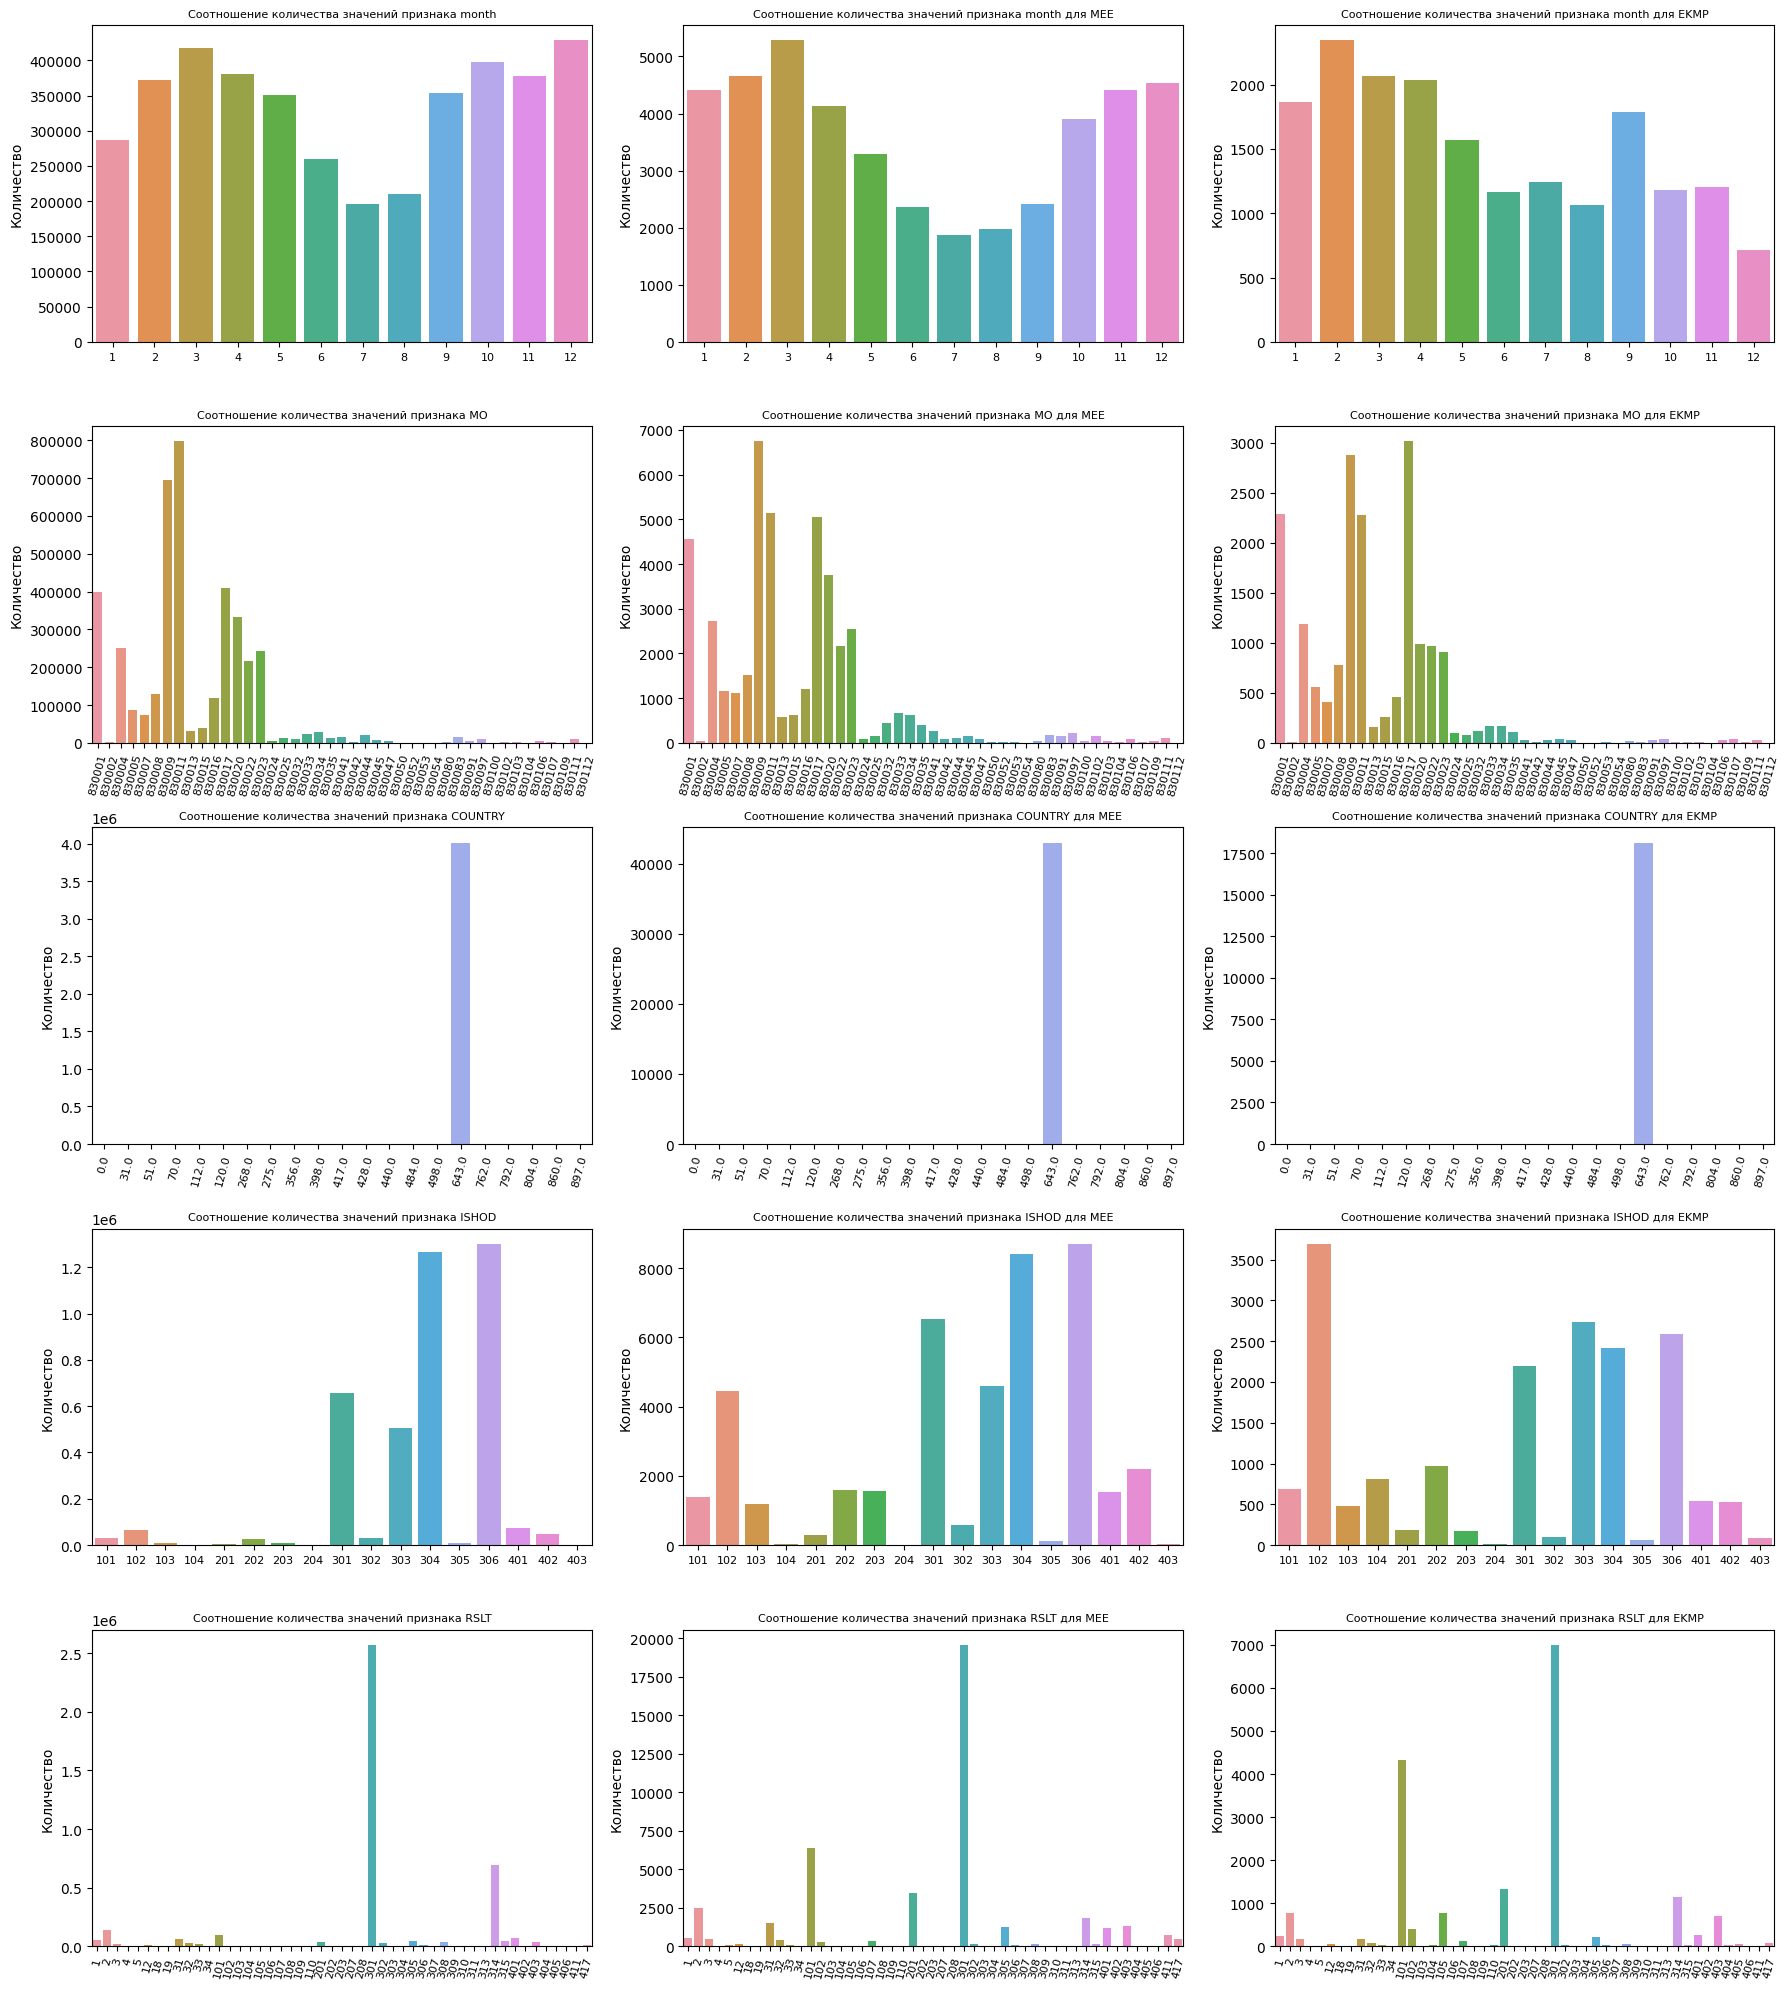

In [61]:
cat_cols = []
for index, value in cat_describe.iloc[1].items():
    if (value > 10 and value < 50):
        cat_cols.append(index)

cat_graf_build(data, cat_cols, ['MO', 'COUNTRY', 'RSLT'], 4, 0)

- **month**: колебания количества случаев по месяцам в основной группе согласуются с сезонность обращений в МО. В отношении связанных с целевыми переменными частот отмечается относительное снижение количества экспертиз к концу года, преимущественно для ЭКМП, что обусловлено длительными сроками проведения экспертиз и отсутствием сведений о последних в данных.
- **MO**: распределение случаев по МО в целом соответствует мощности МО и в отношении целевых переменных повторяет основную выборку
- **COUNTRY**:наблюдается резкий дисбаланс с подавляющим перевесом граждан РФ, как в основной группе так и в отношении целевых переенных. Признак целесообразно преобразовать в бинарный граждане РФ и иные граждане.
- **ISHOD**: соотношение различных категорий исходов в целом соответствует структуре заболеваемости и исходов лечения для основной группы. Для МЭЭ и в большей степени для ЭКМП наблюдается перекос в сторону исходов "улучшение" и "без перемен". 
- **RSLT**: так же можно отметить изменение соотношения результатов при оценке во взаимосвязи с целевыми переменными.

Признаки *PROFIL*, *BED_PROFILE*, *SPEC_CODE*, *DS1*, *CODE_USL*, *NPR_MO*, *IDDOKT*, *CODE_OTD* имеют большое количество классов, поэтому визуализация будет не информативной, оценить их ценость можно на этапе отбора признаков при оценке их взаимосвязи с целевой переменной. Учитывая большое количество значений целесообразно эти признаки, а так же признаки *month*, *MO*, *ISHOD*, *RSLT* закодировать методом Target Encoder.

Подтвердим взаимосвязь между целевыми переменными и признаками статистическими методами.  
Рассматриваемые признаки и целевые переменные относятся к категориальным признакам. Нам необходимо определеить взаимосвязь между признаками. 
Для оценки взаимосвязи двух категориальных признаков подходит критерий Хи-квадрат, воспользуемся им.

Сформулируем гипотезы:
 - нулевая гипотеза: **"Признаки независимы"**
 - альтернативная гипотеза: **"Признаки взаимосвязаны"**  

In [62]:
# задаём уровень значимости
alpha = 0.05

# создадим список признаков для анализа
cat_cols = []
cat_cols = [index for index, value in cat_describe.iloc[1].items()]
cat_cols = cat_cols+['divergence_DS', 'week_day_DATE_1',
                     'week_day_DATE_2', 'DIFF_NPR_DATE_DATE_1']

# проведем анализ
for column in cat_cols:
    table = pd.crosstab(data['MEE'], data[column])
    _, p, _, _ = stats.chi2_contingency(table)
    print('Для признаков МЕЕ и {} p-value = {:.3f}'.format(column, p))
    decision_hypothesis(p, alpha)
    table = pd.crosstab(data['EKMP'], data[column])
    _, p, _, _ = stats.chi2_contingency(table)
    print('Для признаков EKMP и {} p-value = {:.3f}'.format(column, p))
    decision_hypothesis(p, alpha)

Для признаков МЕЕ и month p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу.

Для признаков EKMP и month p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу.

Для признаков МЕЕ и SMO p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу.

Для признаков EKMP и SMO p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу.

Для признаков МЕЕ и FILENAME p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу.

Для признаков EKMP и FILENAME p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу.

Для признаков МЕЕ и MO p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу.

Для признаков EKMP и MO p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвер

Результат анализа подтверждает гипотезу о низкой значимости признака COUNTRY во взаимосвязи с целевой переменной МЕЕ, для целевой переменной ЭКМП сначимость признака удовлетворительная.  
Приобразуем признак в бинарный и повторим анализ в совокупности с остальными бинарными признаками.

In [63]:
data['COUNTRY'] = data['COUNTRY'].apply(lambda x: 643 if x == 643 else 'othe')

## 2.2. Бинарные переменные

Построим графики для оценки бинарных переменных

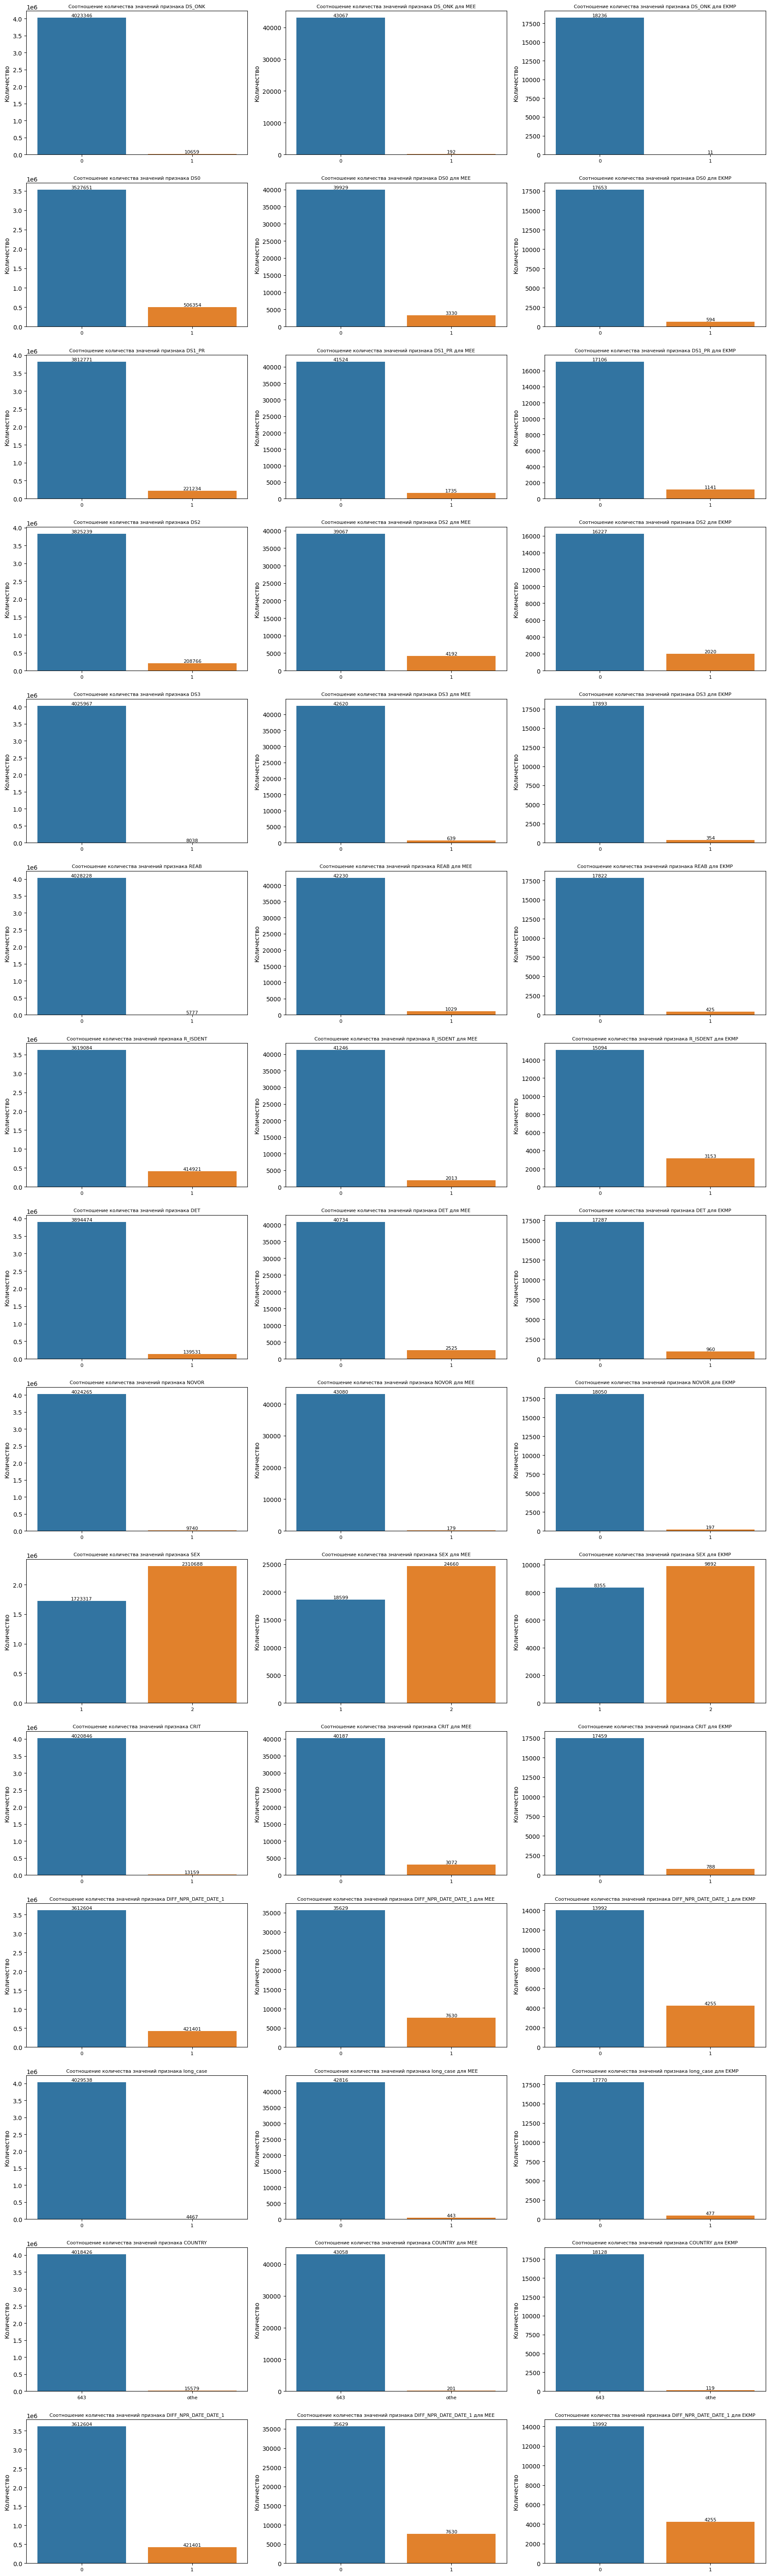

In [64]:
bin_cols = [item for item in data.select_dtypes(include='int8').columns if (data[item].nunique()==2)]
bin_cols = bin_cols+['COUNTRY', 'DIFF_NPR_DATE_DATE_1']
cat_graf_build(data,bin_cols)

- **DS_ONK**: дисаланс резко выражен группа "1" исчезающе мала, как в основной выборке, так и во взаимосвязи с целевыми переменными - удалим признак
- **DS0**: дисбаланс выражен значительно, однако удалять не будем, попробуем оценить на этапе отбора признаков.
- **DS1_PR**: дисбаланс выражен значительно, однако удалять не будем, попробуем оценить на этапе отбора признаков.
- **DS2**: дисбаланс выражен значительно, однако удалять не будем, попробуем оценить на этапе отбора признаков.
- **DS3**: дисаланс резко выражен группа "1" крайне мала, однако во взаимосвязи с целевыми переменными доля таких случаев возрастает, попробуем оценить на этапе отбора признаков.
- **REAB**: дисаланс резко выражен группа "1" крайне мала, однако во взаимосвязи с целевыми переменными доля таких случаев возрастает, попробуем оценить на этапе отбора признаков.
- **R_ISDENT**: дисбаланс выражен заметно, удельная доля меньшей группы возрастает во взаимосвязи с экспертизами ЕКМП
- **DET**: дисаланс резко выражен значительно, однако во взаимосвязи с целевыми переменными доля таких случаев возрастает, попробуем оценить на этапе отбора признаков.
- **NOVOR**: дисаланс резко выражен группа "1" исчезающе мала, как в основной выборке, так и во взаимосвязи с целевыми переменными - удалим признак
- **SEX**: дисбаланс выражен умеренно во взаимосвязи с целевыми переменными дисбаланс несколько уменьшается
- **CRIT**: дисбаланс выражен значительно, однако удалять не будем, попробуем оценить на этапе отбора признаков.
- **long_case**: дисбаланс выражен заначительно, удельная доля меньшей группы возрастает во взаимосвязи с экспертизами ЕКМП, оставим признак до этапа отбора параметров.
- **COUNTRY**: дисаланс резко выражен группа "othe", как в основной выборке, так и во взаимосвязи с целевыми переменными - проверим статистически взаимосвязь признаков и по результатам примем решение о удалении признака
- **DIFF_NPR_DATE_DATE_1**: признак умеренно дисбалансиован, во взаимосвязи с целевыми переменными дисбалас уменьшается, попробуем его оценить на этапе отбора признаков

Общие выводы:
Практически все бинарные переменные резко дисбалансированы, переменные *DS_ONK*, *NOVOR* представлены практически исключительно одним классом - удалим их.

In [65]:
# добавим удаляемые признаки в список для последующего удаления
drop_list = drop_list+['DS_ONK', 'NOVOR']

Подтвердим взаимосвязь между целевыми переменными и признаками статистическими методами.  
Рассматриваемые признаки являются бинарными, целевые переменные относятся к категориальным признакам. Нам необходимо определеить взаимосвязь между признаками. 
Для оценки взаимосвязи таких признаков подходит критерий Хи-квадрат, воспользуемся им.

Сформулируем гипотезы:
 - нулевая гипотеза: **"Признаки независимы"**
 - альтернативная гипотеза: **"Признаки взаимосвязаны"**  

In [66]:
# задаём уровень значимости
alpha = 0.05

# проведем анализ
for column in bin_cols:
    table = pd.crosstab(data['MEE'], data[column])
    _, p, _, _ = stats.chi2_contingency(table)
    print('Для признаков МЕЕ и {} p-value = {:.3f}'.format(column, p))
    decision_hypothesis(p, alpha)
    table = pd.crosstab(data['EKMP'], data[column])
    _, p, _, _ = stats.chi2_contingency(table)
    print('Для признаков EKMP и {} p-value = {:.3f}'.format(column, p))
    decision_hypothesis(p, alpha)

Для признаков МЕЕ и DS_ONK p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу.

Для признаков EKMP и DS_ONK p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу.

Для признаков МЕЕ и DS0 p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу.

Для признаков EKMP и DS0 p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу.

Для признаков МЕЕ и DS1_PR p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу.

Для признаков EKMP и DS1_PR p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу.

Для признаков МЕЕ и DS2 p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу.

Для признаков EKMP и DS2 p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвер

По результатам анализа можно констатировать наличие статистически значимой связи целевых переменных и бинарных признаков, за исключением целевой переменной **МЕЕ** и признака **SEX**.  
Оценим этот признак на этапе отбора признаков и примем решение о удалении.

## 2.3. Числовые переменные

Получим описательные статистики числовых переменных

In [67]:
num_cols = [item for item in data.select_dtypes(include='int16').columns]
num_cols = num_cols + \
    [item for item in data.select_dtypes(include='int32').columns]
num_cols = num_cols + \
    [item for item in data.select_dtypes(include='float32').columns]
num_cols = num_cols + \
    [item for item in data.select_dtypes(include='float64').columns]
num_cols = num_cols + ['ORIT', 'AGE']
num_stat_data = data[num_cols + ['MEE', 'EKMP']]
num_stat_data[num_cols].describe()

KOL_USL            KD        attach    population         TARIF  \
count  4.034005e+06  4.034005e+06  4.034005e+06  4.034005e+06  4.034005e+06   
mean   1.978238e+00  3.525302e+00  6.234531e+04  6.689387e+04  6.540807e+03   
std    2.582008e+00  1.126911e+01  3.936723e+04  1.623365e+05  2.922258e+04   
min    0.000000e+00  1.000000e+00  0.000000e+00  5.702000e+03  0.000000e+00   
25%    1.000000e+00  1.000000e+00  3.014800e+04  3.386900e+04  7.700000e+02   
50%    1.000000e+00  1.000000e+00  5.380100e+04  6.623300e+04  1.161000e+03   
75%    2.000000e+00  1.000000e+00  9.858800e+04  1.012350e+05  3.973000e+03   
max    2.820000e+02  6.380000e+02  1.180200e+05  1.310418e+07  3.626420e+06   

               SUMV          KSLP  number_of_cases          ORIT           AGE  
count  4.034005e+06  4.034005e+06     4.034005e+06  4.034005e+06  4.034005e+06  
mean   6.612858e+03  9.009658e-04     1.557860e+01  1.229299e-03  2.877231e+01  
std    2.817385e+04  2.177097e-02     1.027786e+01  4.778405e-02  2.237082e+01  
min    0.000000e+00  0.000000e+00     1.000000e+00  0.000000e+00  0.000000e+00  
25%    9.702600e+02  0.000000e+00     8.000000e+00  0.000000e+00  8.000000e+00  
50%    1.586000e+03  0.000000e+00     1.400000e+01  0.000000e+00  2.500000e+01  
75%    3.973000e+03  0.000000e+00     2.100000e+01  0.000000e+00  4.700000e+01  
max    2.756687e+06  4.140000e+00     2.460000e+02  2.600000e+01  1.230000e+02

Сохраним список числовых признаков

In [69]:
with open('data/num_cols.pkl', 'wb') as f:
    pickle.dump(num_cols, f)

#### Оценим описательные статистики числовых признаков:

- Признак **KOL_USL** имеет разброс от 0 до 282 штук, с медианным 1 и средним 1.97 значениями. Что говорит о преобладании минимальных значений, преимущественно единиц. А средние меры (медиана меньше средне арифметического) так же говорят о преимущественно малых значениях, а так же не исключено влияние выбросов. Расмотрим это предположение подробнее.


- Признак **KD** имеет разброс от 1 до 638 койко дней, с медианным 1 и средним 3.53 значениями. Что говорит о не больших длительностях госпитализации, о чём дополниельно говорит меньшее значение медианы в сравнении с средне арифметическим, а так же не исключено влияние выбросов. Расмотрим это предположение подробнее.


- Признак **attach** имеет разброс от 0 до 118020 человек, с медианным 53801 и средним 62345,3 значениями. Что может говорить о наличии организаций не имеющих прикрепеленного населения. А средние меры (медиана меньше средне арифметического) так же говорят о преимущественно малых значениях, а так же не исключено влияние выбросов.


- Признак **population** имеет разброс от 5702 до 13104180 человек, с медианным 66233 и средним 66894 значениями. Что может говорить о преимущественно равномерном распределении признака и наличии не большого количества выбросов.


- Признак **TARIF** имеет разброс от 0 до 3626420 руб., с медианным 1161 и средним 6589 значениями. Что говорит о преобладании минимальных значений. А средние меры (медиана меньше средне арифметического) так же говорят о преимущественно малых значениях, а так же не исключено влияние выбросов. Расмотрим это предположение подробнее.


- Признак **SUMV** имеет разброс от 0 до 2756687 руб., с медианным 1586 и средним 6673 значениями. Что говорит о преобладании минимальных значений. А средние меры (медиана меньше средне арифметического) так же говорят о преимущественно малых значениях, а так же не исключено влияние выбросов. Расмотрим это предположение подробнее.


- Признак **KSLP** имеет разброс от 0 до 4.14, с медианным 0 и средним 0,0009 значениями. Что говорит о преобладании нулевых значений. А средние меры (медиана меньше средне арифметического) так же говорят о преимущественно околонулевых значениях, а так же не исключено влияние выбросов. Расмотрим это предположение подробнее.


- Признак **number_of_cases** имеет разброс от 1 до 246, с медианным 14 и средним 15,6 значениями. Что говорит о преобладании минимальных значений, преимущественно единиц. А средние меры (медиана меньше средне арифметического) так же говорят о преимущественно малых значениях хотя различие между средним и средне арифметическим и не велики. Не исключено влияние выбросов. Расмотрим это предположение подробнее.


- Признак **ORIT** имеет разброс от 0 до 26 дней, с медианным 0 и средним 0,001 значениями. Что говорит о преобладании минимальных значений, преимущественно нулей. А средние меры (медиана меньше средне арифметического) так же говорят о преимущественно малых значениях. Не исключено влияние выбросов. Расмотрим это предположение подробнее.


- Признак **AGE** имеет разброс от 0 до 123 года, с медианным 25 и средним 28.8 значениями. Что говорит о преобладании минимальных значений. А средние меры (медиана меньше средне арифметического) так же говорят о преимущественно малых значениях. Не исключено влияние выбросов. Расмотрим это предположение подробнее.

Построим графики для визуализации особенностей распределения и проверки гипотез

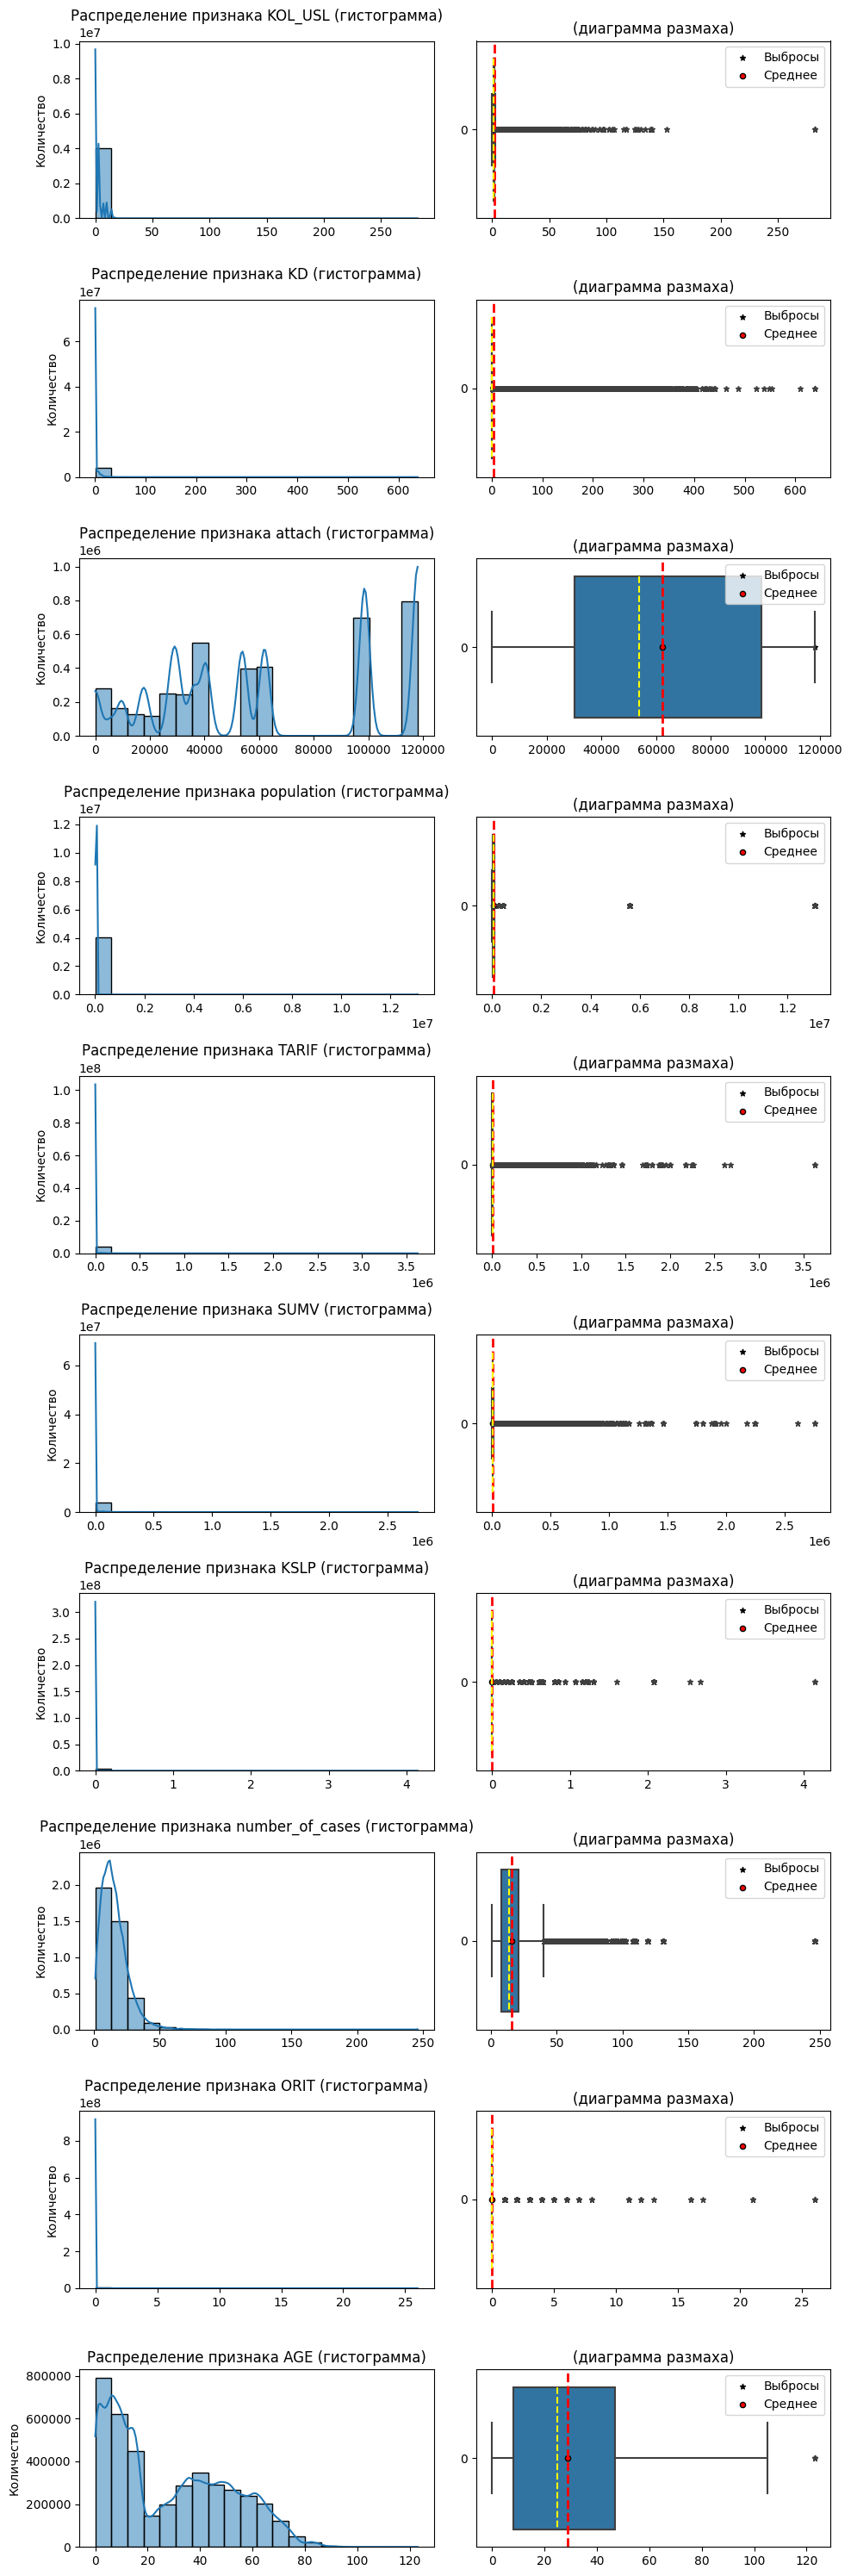

In [70]:
stat_graf_bild(num_stat_data, num_cols)

- **KOL_USL**: распределение признакак резко смещено влево и напоминает логнормальное, подавляющая масса значений находится в районе нуля, отмечается длинный правый хвост с низкой амплитудой. Множество выбросов в правой части распределения. Попробуем преобразовать признак, для уменьшения ассиметрии распределения.
- **KD**: распределение признакак резко смещено влево и напоминает лонормальное, подавляющая масса значений находится в районе нуля, отмечается длинный правый хвост с низкой амплитудой. Множество выбросов в правой части распределения. Попробуем преобразовать признак, для уменьшения ассиметрии распределения.
- **attach**: распределение признака не похоже на нормальное и имеет множество максимумов приближаясь к линейному. Среднее значение смещено вправо от медианного, выбросов нет.
- **population**: распределение признакак резко смещено влево, подавляющая масса значений находится в районе нуля, отмечается длинный правый хвост с низкой амплитудой. Выбросов не много, но есть сильно отдаленные, расположены в правой части распределения. Попробуем преобразовать признак, для уменьшения ассиметрии распределения.
- **TARIF**: распределение признакак резко смещено влево, подавляющая масса значений находится в районе нуля, отмечается длинный правый хвост с низкой амплитудой. Множество выбросов в правой части распределения. Попробуем преобразовать признак, для уменьшения ассиметрии распределения.
- **SUMV**: распределение признакак резко смещено влево, подавляющая масса значений находится в районе нуля, отмечается длинный правый хвост с низкой амплитудой. Множество выбросов в правой части распределения. Попробуем преобразовать признак, для уменьшения ассиметрии распределения.
- **KSLP**: распределение признакак резко смещено влево, подавляющая масса значений находится в районе нуля, отмечается длинный правый хвост с низкой амплитудой. Множество выбросов в правой части распределения. Попробуем преобразовать признак, для уменьшения ассиметрии распределения.
- **number_of_cases**: распределение признакак заметно смещено влево и напоминает логнормальное, отмечается длинный правый хвост с низкой амплитудой. Множество выбросов в правой части распределения с большими единичными отрывами. Среднее значение смещено вправо от медианного. Попробуем преобразовать признак, для уменьшения ассиметрии распределения.
- **ORIT**: распределение признакак резко смещено влево, подавляющая масса значений находится в районе нуля, отмечается длинный правый хвост с низкой амплитудой. Множество выбросов в правой части распределения. Попробуем преобразовать признак, для уменьшения ассиметрии распределения.
- **AGE**: распределение имеет два пика, один ближе к нулю по структуре напопоминающим логнормальное распределение и со вторым писком ближе к середине распределения с правым хвостом. Выбросы единичны, среднее смещено вправо.

Общий вывод:  
Большинство признаков имеет резко выраженное смещение распределения влево с большим количеством выбросов и правым хвостом, за исключением признака *attach* распределение которого напоминает линейное. Для корректировки смещения попробуем преобразовать признаки, а так же оценить признаки во взаимосвязи с целевыми переменными после преобразования.

Попробуем сначала пролагорифмировать признаки

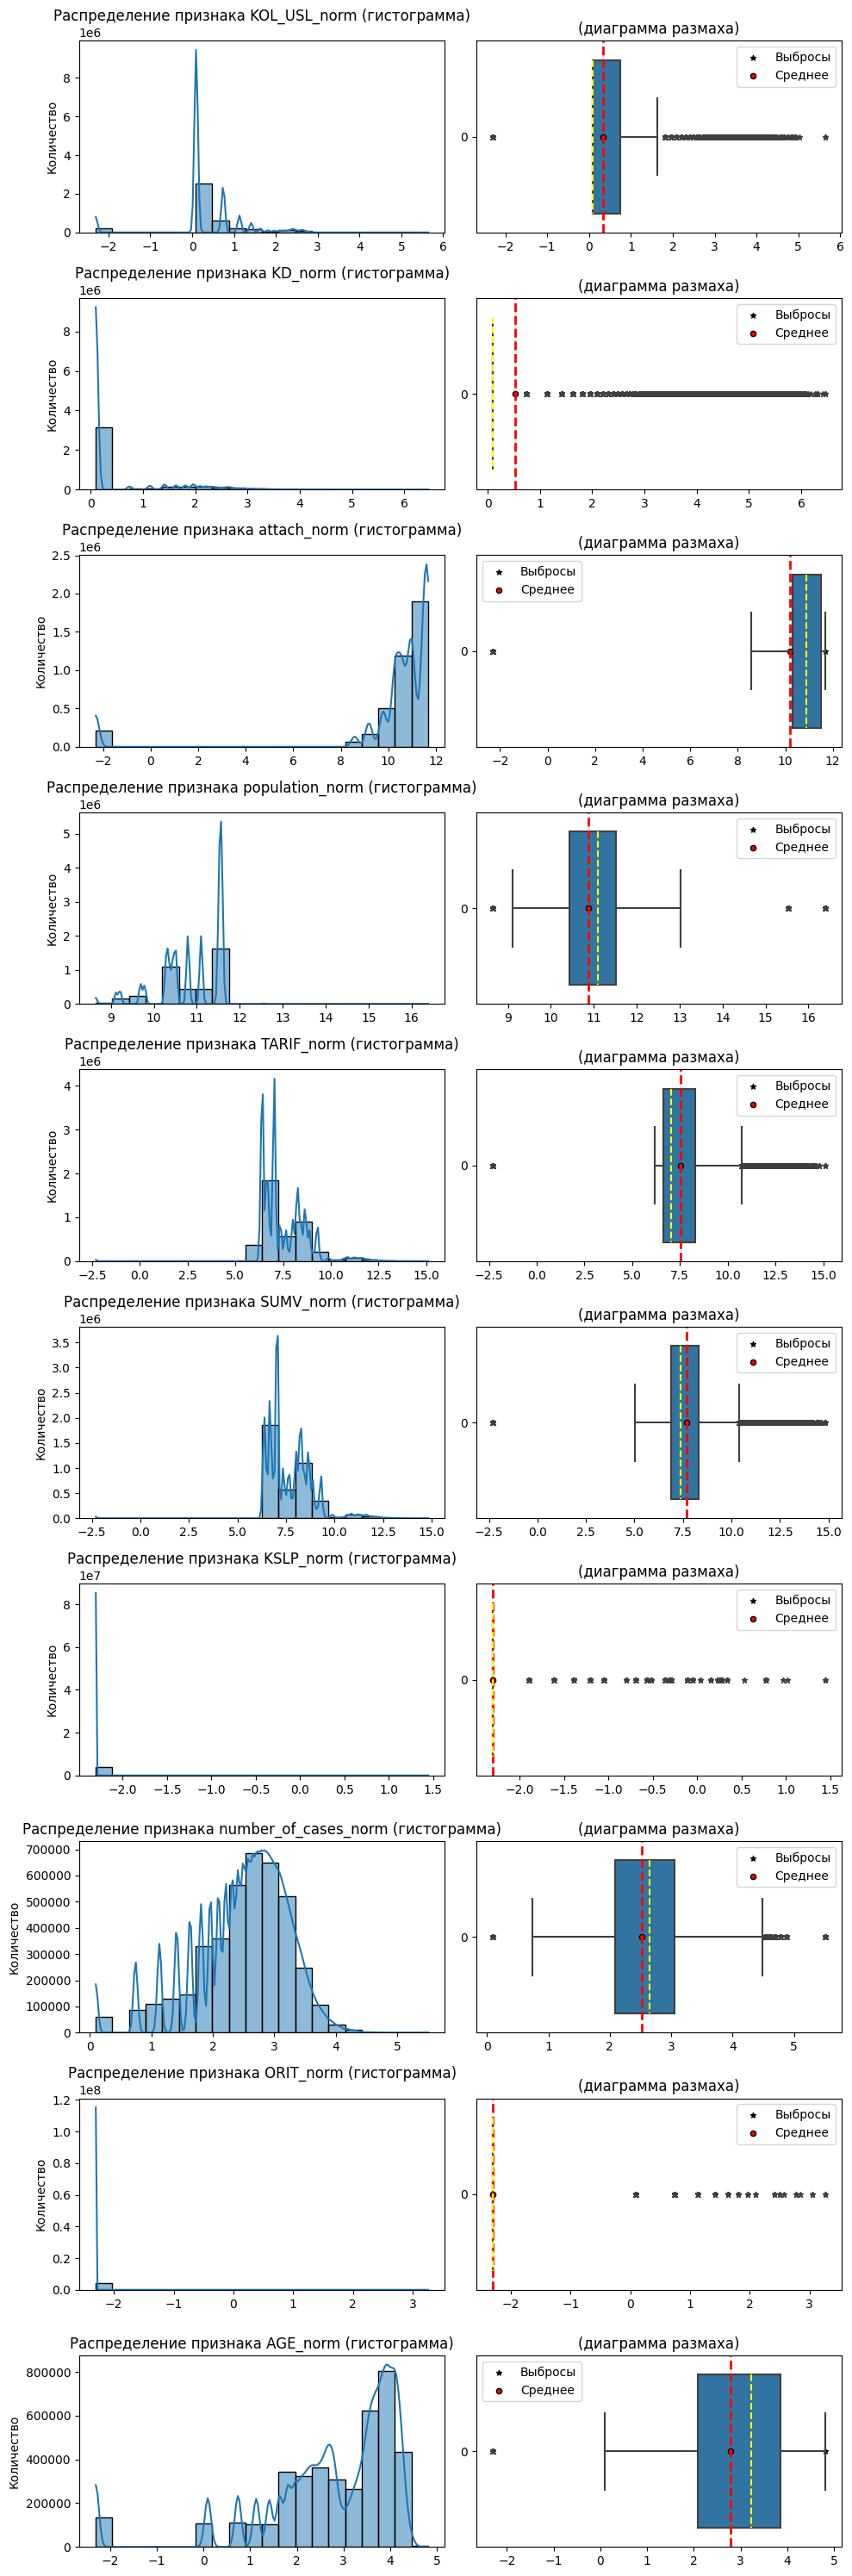

In [71]:
norm_list = []

for column in num_cols:
    col_name = column + '_norm'
    num_stat_data[col_name] = np.log(num_stat_data[column]+0.1)
    norm_list.append(col_name)

stat_graf_bild(num_stat_data, norm_list)

В результате логарифмирования распределение признаков **KOL_USL, population, TARIF, SUMV, number_of_cases** по форме приблизились к нормальному, но сохраняются выбросы и смещение средних мер. Наилучшая картина для признака **number_of_cases**.

Попробуем применить нелинейные преобразования:
 - преобразование Бокса-Кокса
 - преобразование Йео-Джонсона
 - метод квантильных преобразований  

 начнем с преобразования Бокса-Кокса

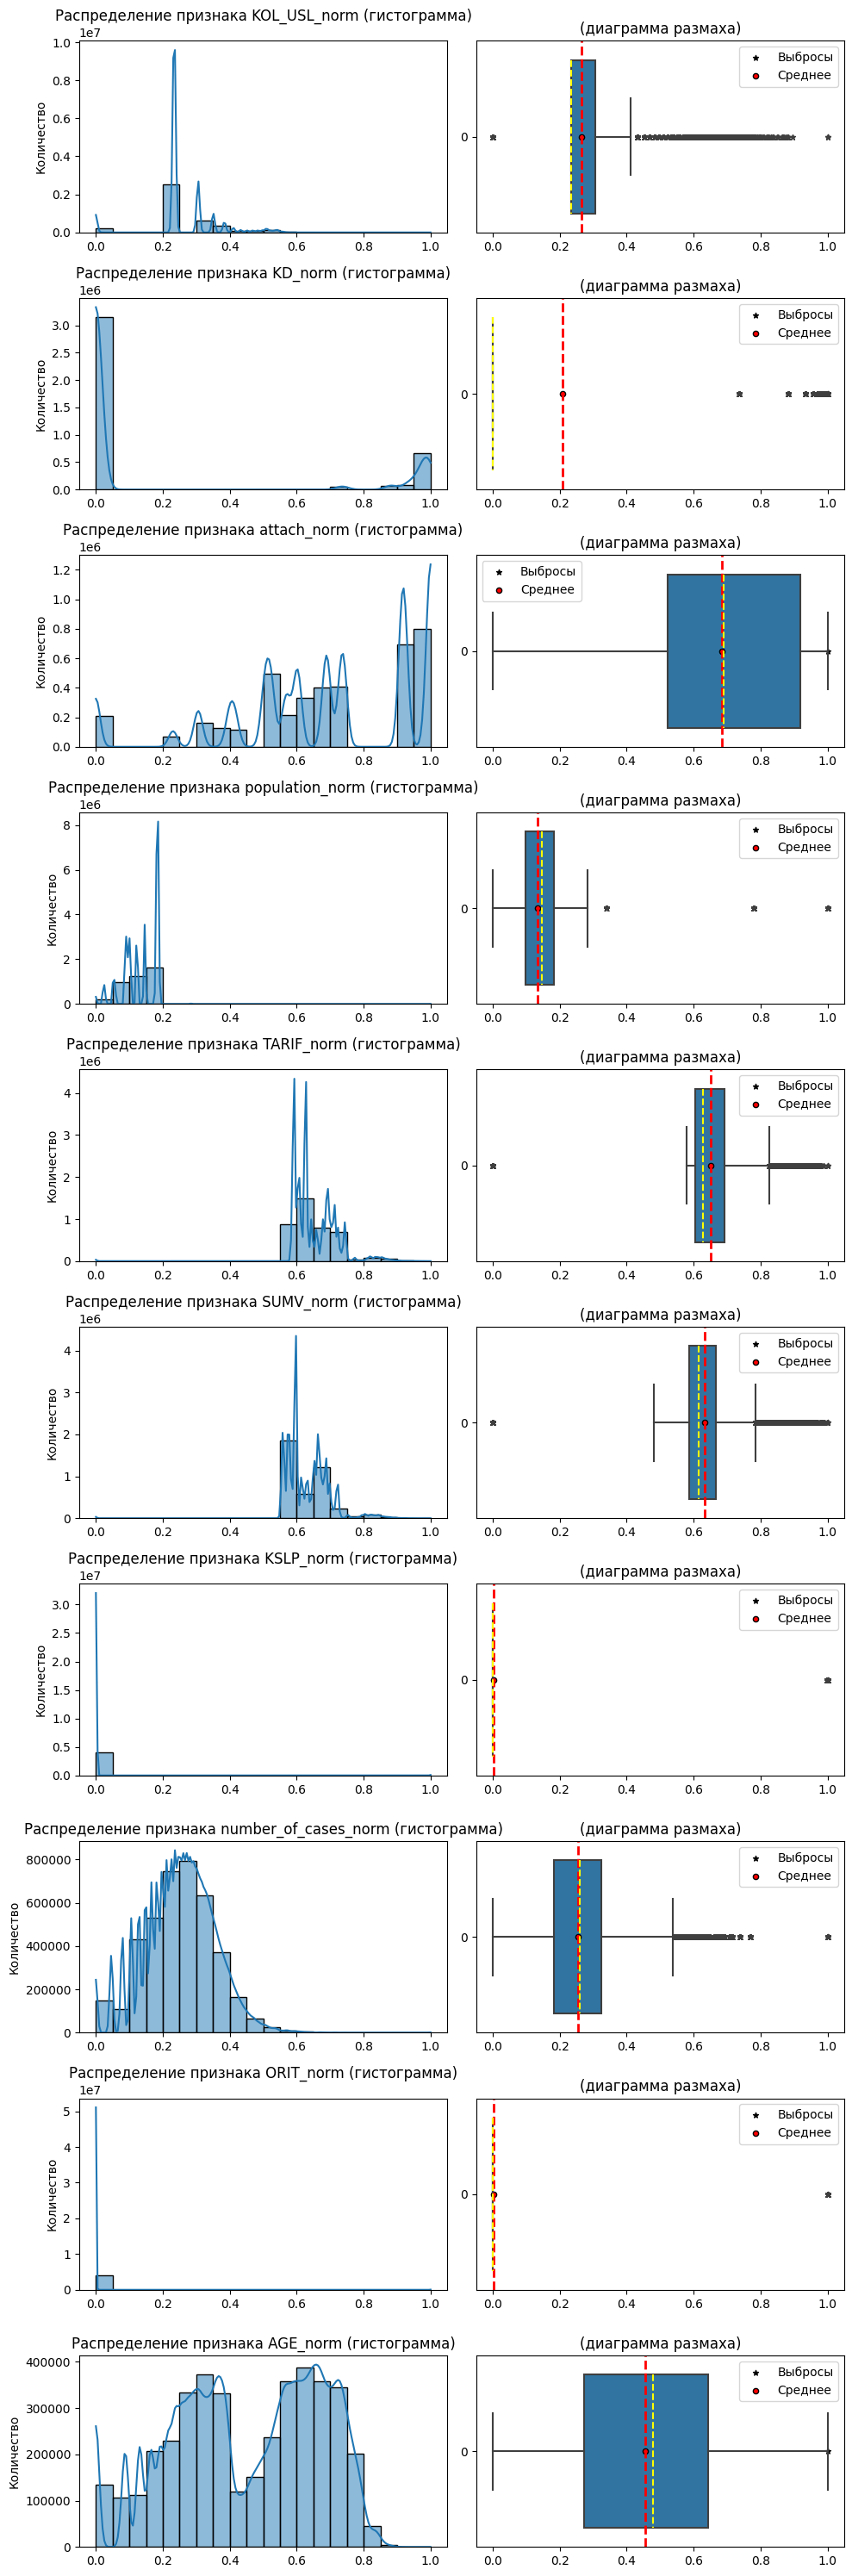

In [72]:
norm_list = []
scaler = MinMaxScaler()
box_cox = PowerTransformer(method='box-cox', standardize=False)
yeo_johnson = PowerTransformer(method='yeo-johnson', standardize=False)
qt = QuantileTransformer(n_quantiles=100, random_state=RANDOM_STATE)

for column in num_cols:
    col_name = column + '_norm'
    num_stat_data[col_name] = box_cox.fit_transform(
        pd.DataFrame(num_stat_data[column])+0.1)
    num_stat_data[col_name] = scaler.fit_transform(
        pd.DataFrame(num_stat_data[col_name]))
    norm_list.append(col_name)

stat_graf_bild(num_stat_data, norm_list)

В результате преобразований распределение приблизилось к нормальному и нормализовано, однако сохраняются выбросы ассисметрия распределений. Признак *AGE* стал практически бимодальным, признаки *attach* и *KSLP* практически не изменились. 

Попробуем преобразование Йео-Джонсона

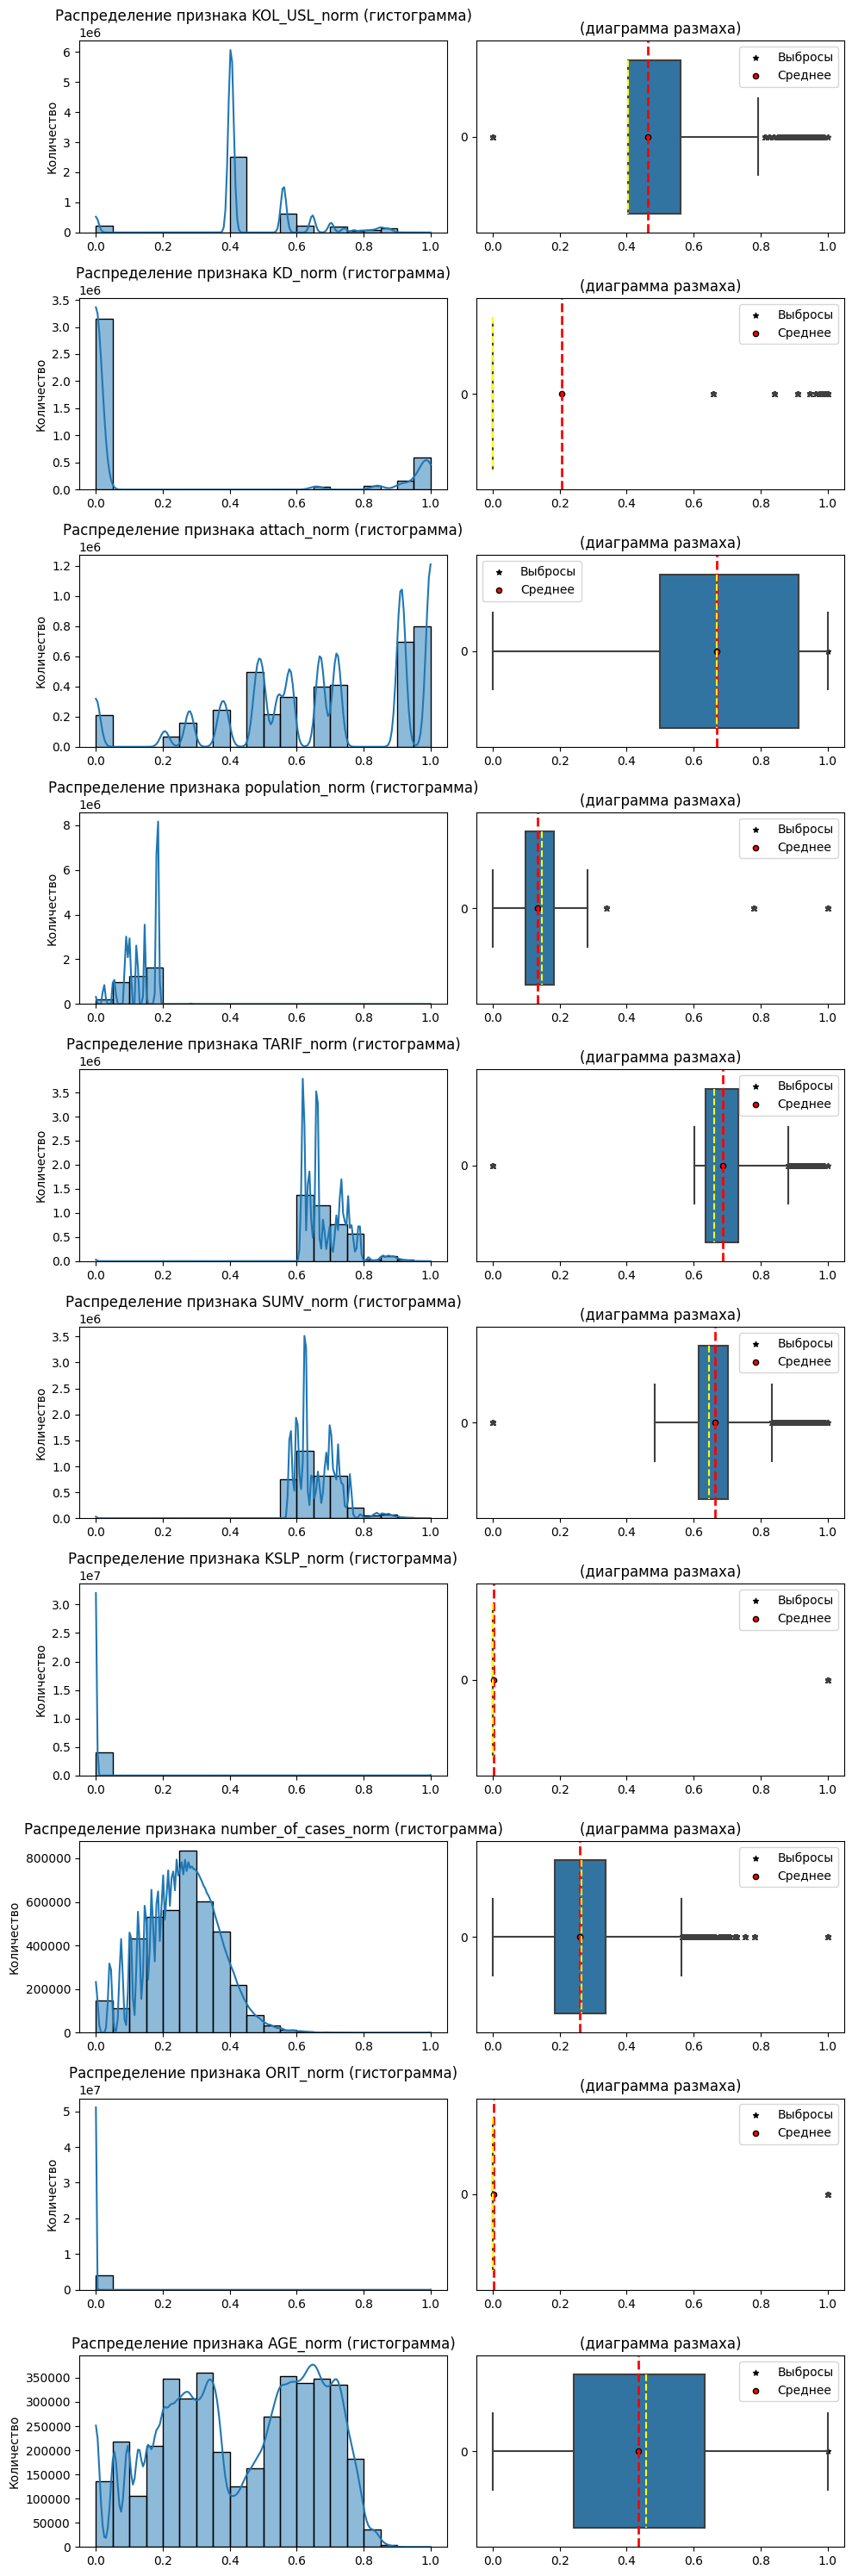

In [73]:
norm_list = []

for column in num_cols:
    col_name = column + '_norm'
    num_stat_data[col_name] = yeo_johnson.fit_transform(
        pd.DataFrame(num_stat_data[column]))
    num_stat_data[col_name] = scaler.fit_transform(
        pd.DataFrame(num_stat_data[col_name]))
    norm_list.append(col_name)

stat_graf_bild(num_stat_data, norm_list)

Картина распределения улучшилась по признаку *KOL_USL*, ухудшилась по признаку *TARIF*, по остальным признакам существенной динамики нет. 

Попробуем метод квантильных преобразований

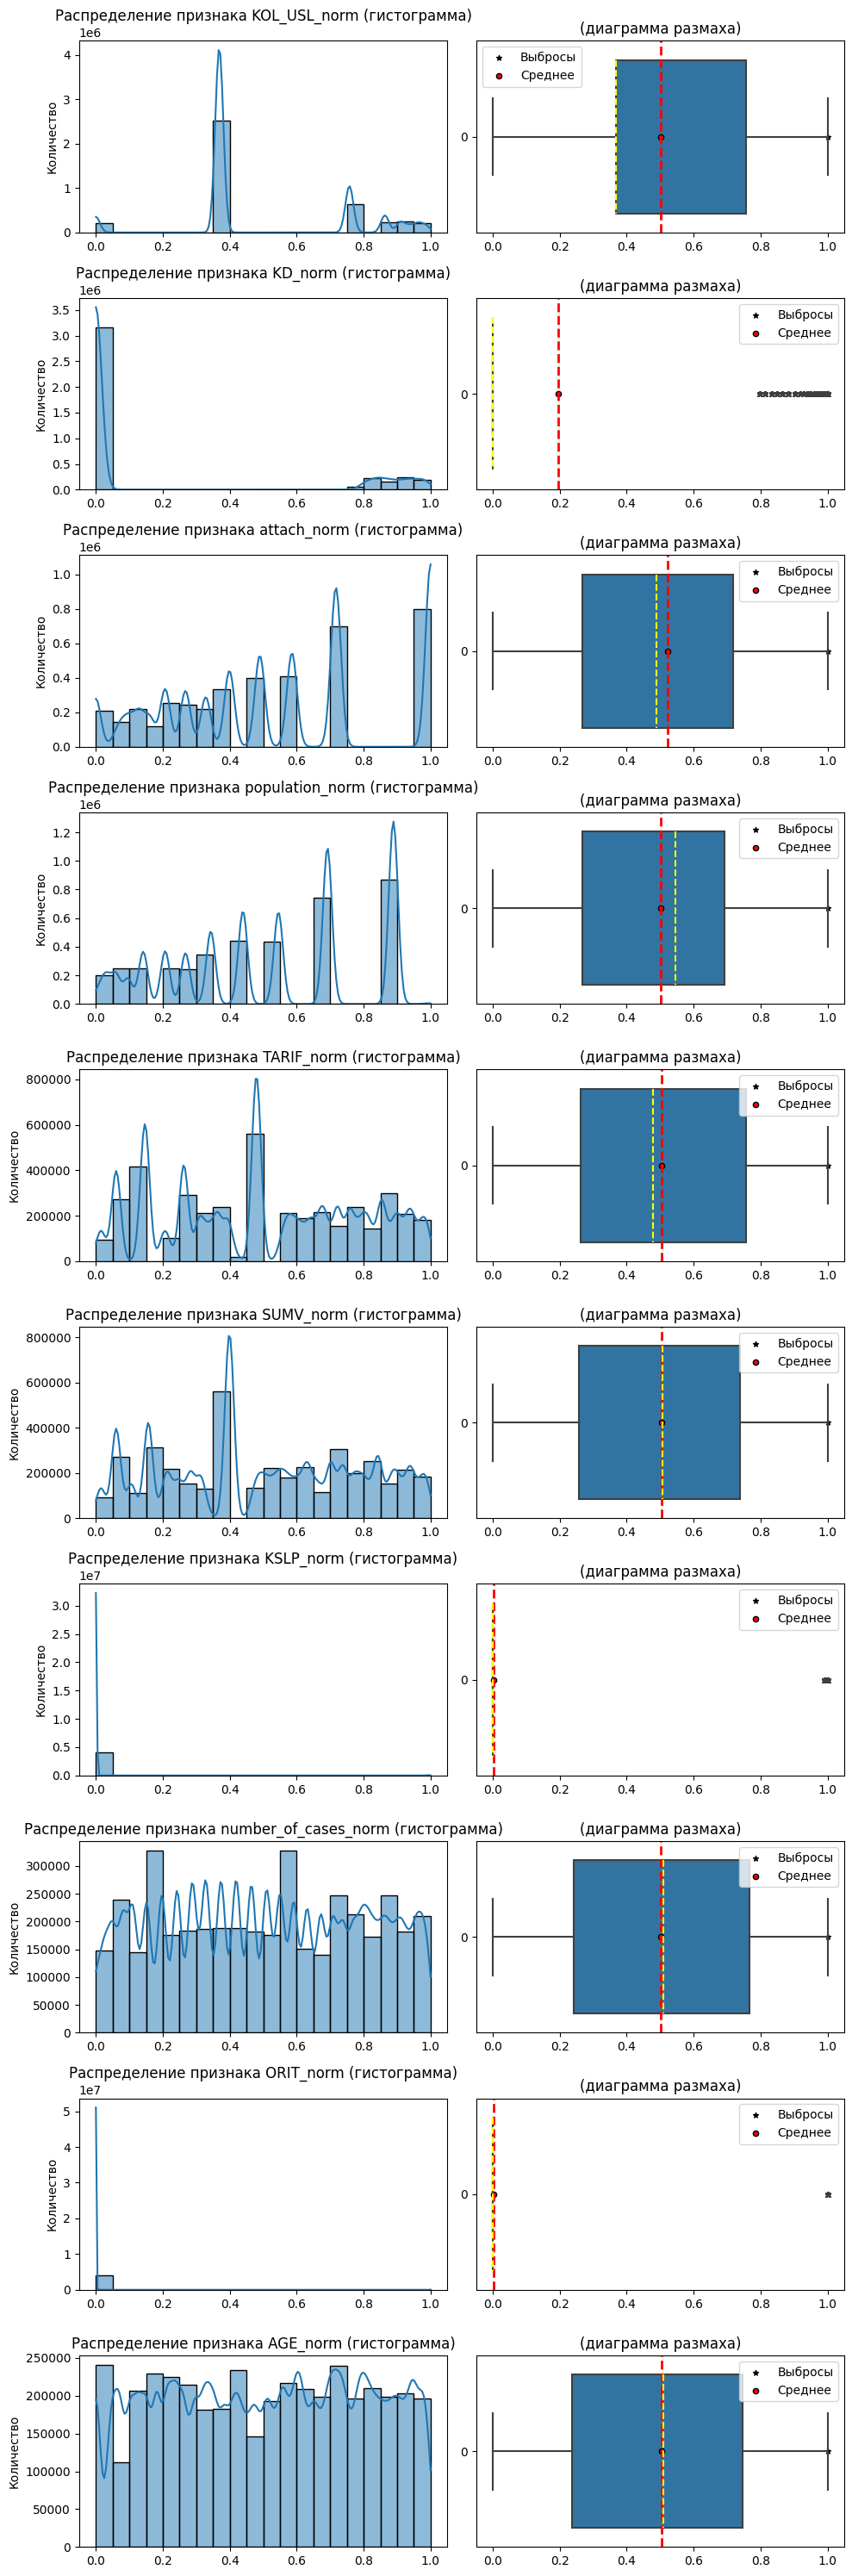

In [74]:
norm_list = []

for column in num_cols:
    col_name = column + '_norm'
    num_stat_data[col_name] = qt.fit_transform(
        pd.DataFrame(num_stat_data[column]))
    num_stat_data[col_name] = scaler.fit_transform(
        pd.DataFrame(num_stat_data[col_name]))
    norm_list.append(col_name)

stat_graf_bild(num_stat_data, norm_list)

В результате преобразования наилучший результат у признака **KOL_USL** пропали выбросы и распределение приблизилось несколько к нормальному. У признаков **attach, population, TARIF, SUMV, number_of_cases, AGE** распределение приблизилось к линейному, пропали выбросы, по диаграмме размаха среднее и медианное значения сблизилсь. Признаки **KD, KSLP, ORIT** мало меняются при преобразовании, сохраняя выраженое смещение и выбросы. 

Общий вывод:  
Наилучший результат дал метод квантильных преобразований. Воспользуемся им для преобразования признаков для признака **KD** используем логарифмирование, где для него получены наилучшие результаты, . 

In [75]:
num_stat_data['KD_norm'] = np.log(num_stat_data['KD']+0.1)

Попробуем оценить ценность признаков после их преобразования, во взаимосвязи с целевой переменной построим графики, отражающие различие в распределении признаков для случаев, когда экспертиза проводилась и когда не проводилась.

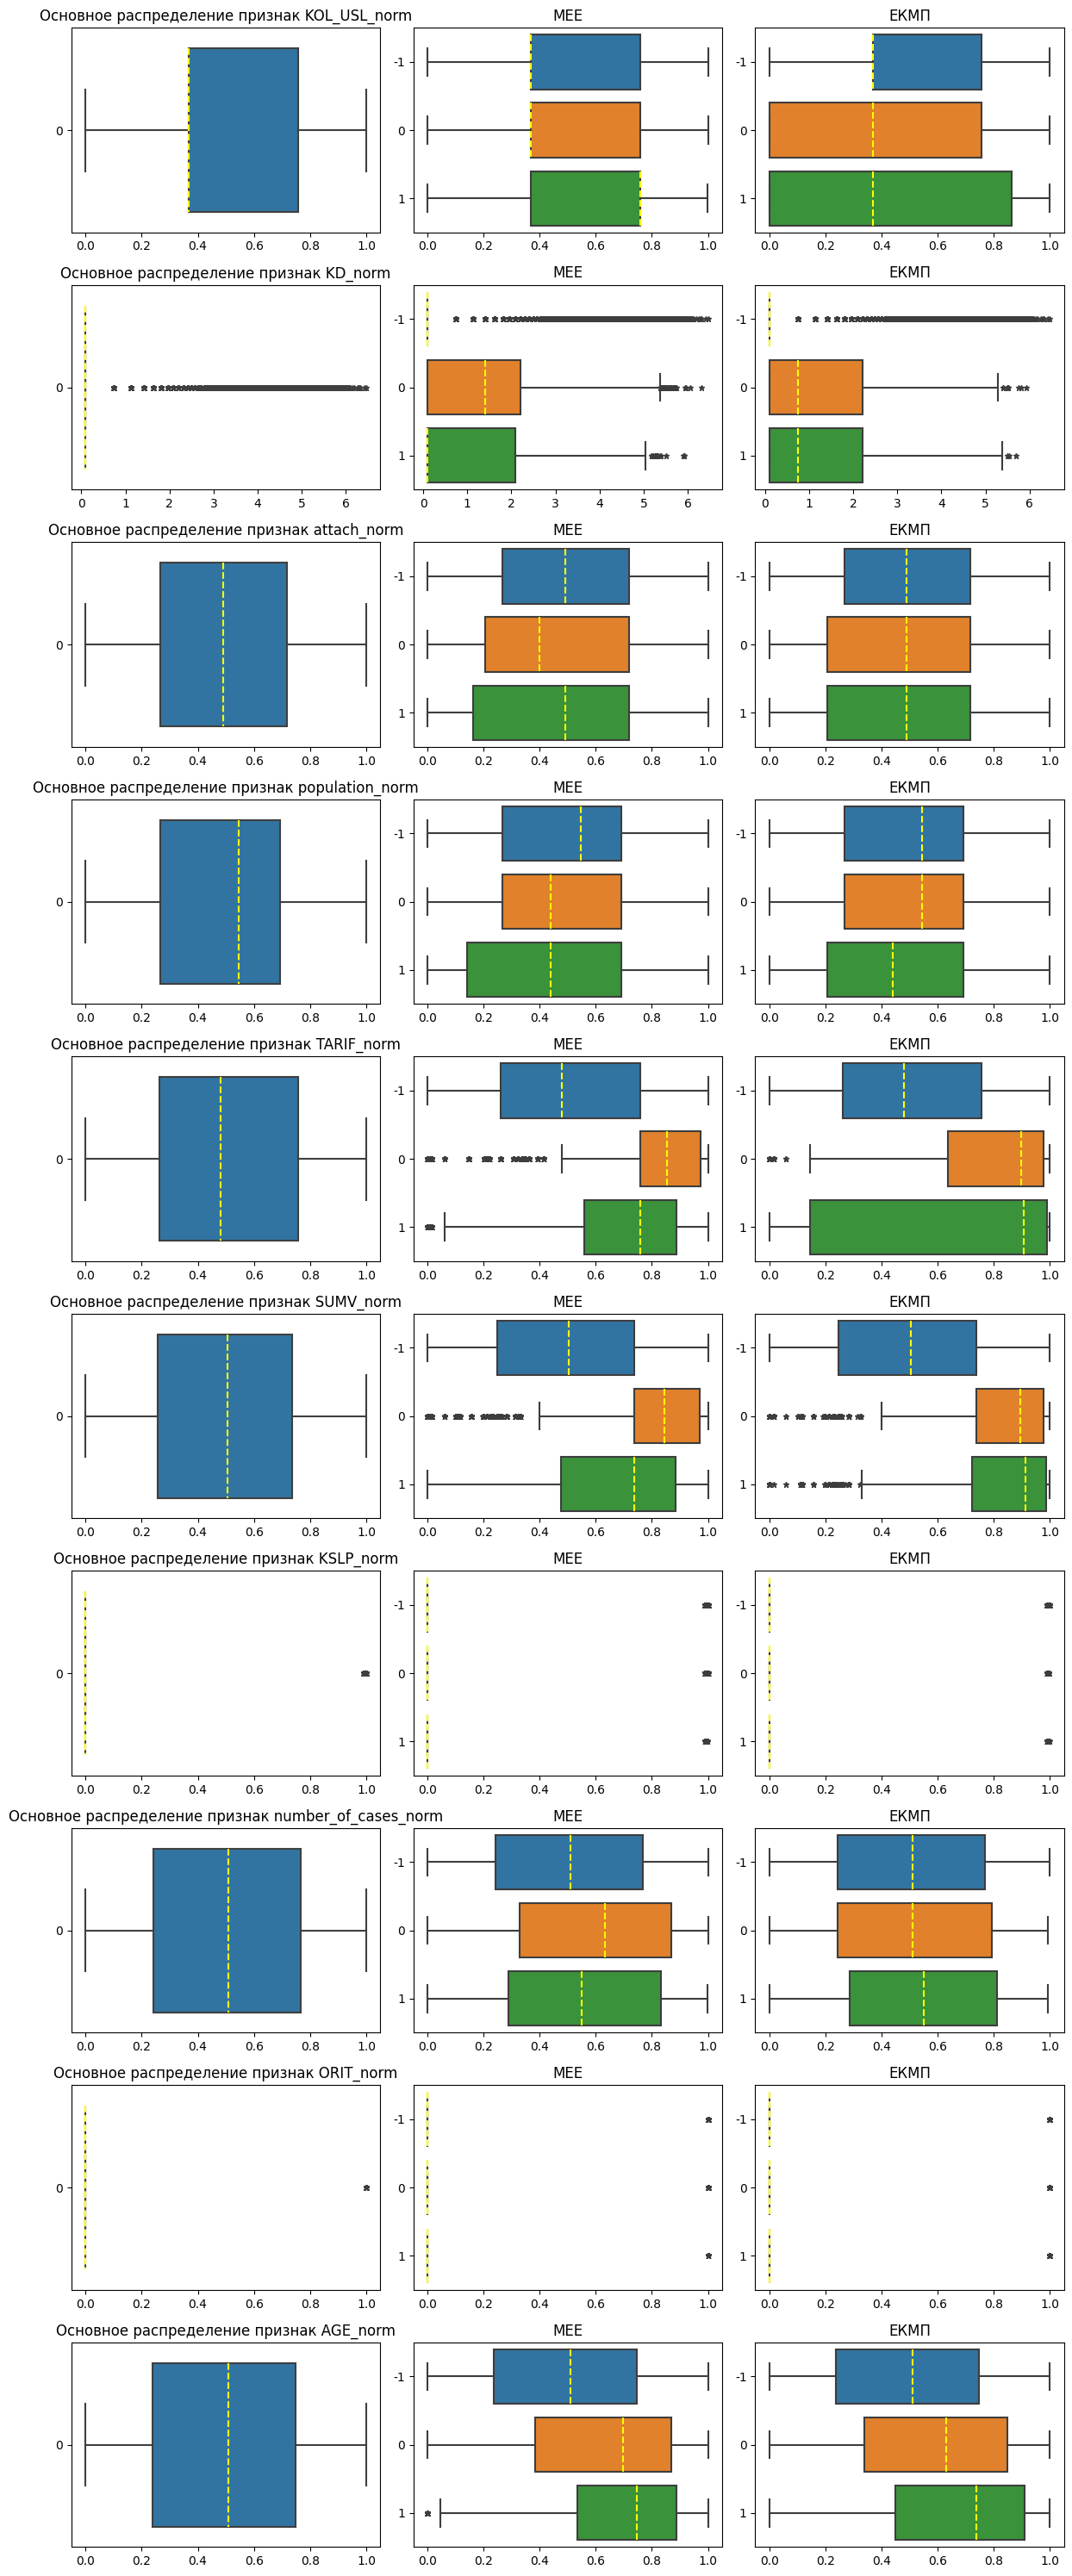

In [76]:
stat_graf_target_boxplot(num_stat_data, norm_list)

Из графиков можно сделать вывод, что распределение признаков для случаев проведения экспертизы и различных ее исходов различается. За исключением признаков **KSLP_norm** и **ORIT_norm** у которых из за ассиметрии графиков разница не различима.

Проверим это заключение статистическими методами.  
Для чего сначала подтвердим предположение о не нормальности распределения при помощи теста Шапиро - Уилка.

In [77]:
# проводим тест Шапиро — Уилка
for column in norm_list:
    _, p = stats.shapiro(num_stat_data[column])
    print('Признак {} p-value = {:.3f}'.format(column, p))
    if p <= alpha:
        print('Распределение не нормальное\n')
    else:
        print('Распределение нормальное\n')

Признак KOL_USL_norm p-value = 0.000
Распределение не нормальное

Признак KD_norm p-value = 0.000
Распределение не нормальное

Признак attach_norm p-value = 0.000
Распределение не нормальное

Признак population_norm p-value = 0.000
Распределение не нормальное

Признак TARIF_norm p-value = 0.000
Распределение не нормальное

Признак SUMV_norm p-value = 0.000
Распределение не нормальное

Признак KSLP_norm p-value = 0.000
Распределение не нормальное

Признак number_of_cases_norm p-value = 0.000
Распределение не нормальное

Признак ORIT_norm p-value = 0.000
Распределение не нормальное

Признак AGE_norm p-value = 0.000
Распределение не нормальное



Предположение о не нормальности распределения подтверждается.

Попробуем статистически оценить ценность признаков во взаимосвязи с целевой переменной: оценим наличие статистически значимой разницы между значением признаков для случаев, когда экспертиза проводилась и когда не проводилась.  

Мы имеем дело с не нормально распределенными данными, следовательно будем использовать непараметрические тесты, для задачи сравнения двух и более независимых признаков подходит критерий Краскела — Уоллиса, воспользуемся им. Уровень значимости alpha зададим = 0.05 .

Сформулируем гипотезы:
 - нулевая гипотеза: **"Различий в распределении признака для проведенной экспертизы и не проведенной экспертизы нет"**
 - альтернативная гипотеза: **"Различия в распределении признака для проведенной экспертизы и не проведенной экспертизы есть"**  

In [78]:
# задаём уровень значимости
alpha = 0.05

# проведем анализ
for column in norm_list:
    _, p = stats.kruskal(num_stat_data[num_stat_data['MEE'] == 1][column],
                         num_stat_data[num_stat_data['MEE'] == 0][column],
                         num_stat_data[num_stat_data['MEE'] == -1][column])
    print('Для признаков МЕЕ и {} p-value = {:.3f}'.format(column, p))
    decision_hypothesis(p, alpha)
    _, p = stats.kruskal(num_stat_data[num_stat_data['EKMP'] == 1][column],
                         num_stat_data[num_stat_data['EKMP'] == 0][column],
                         num_stat_data[num_stat_data['EKMP'] == -1][column])
    print('Для признаков EKMP и {} p-value = {:.3f}'.format(column, p))
    decision_hypothesis(p, alpha)

Для признаков МЕЕ и KOL_USL_norm p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу.

Для признаков EKMP и KOL_USL_norm p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу.

Для признаков МЕЕ и KD_norm p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу.

Для признаков EKMP и KD_norm p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу.

Для признаков МЕЕ и attach_norm p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу.

Для признаков EKMP и attach_norm p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу.

Для признаков МЕЕ и population_norm p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу.

Для признаков EKMP и population_norm p-value = 0.000
p-значен

Результаты статистического анализа подтверждают первоначальное предположение о наличии разницы в распределении признаков для случаев проведения экспертизы и случаев, когда экспертиза не проводилась. Таким образом признкаи имеют ценность для предсказания результатов экспертизы.

Методом z-отклонения оценим наличие выбросов и их количество после преобразования числовых признаков

In [79]:
for column in norm_list:
    outliers, cleaned = outliers_z_score(num_stat_data, column, log_scale=True)
    print(f'Признак: {column}')
    print(f'Число выбросов по методу z-отклонения: {outliers.shape[0]}')
    print(f'Результирующее число записей: {cleaned.shape[0]}\n')

Признак: KOL_USL_norm
Число выбросов по методу z-отклонения: 0
Результирующее число записей: 4034005

Признак: KD_norm
Число выбросов по методу z-отклонения: 24233
Результирующее число записей: 4009772

Признак: attach_norm
Число выбросов по методу z-отклонения: 0
Результирующее число записей: 4034005

Признак: population_norm
Число выбросов по методу z-отклонения: 0
Результирующее число записей: 4034005

Признак: TARIF_norm
Число выбросов по методу z-отклонения: 0
Результирующее число записей: 4034005

Признак: SUMV_norm
Число выбросов по методу z-отклонения: 0
Результирующее число записей: 4034005

Признак: KSLP_norm
Число выбросов по методу z-отклонения: 11157
Результирующее число записей: 4022848

Признак: number_of_cases_norm
Число выбросов по методу z-отклонения: 0
Результирующее число записей: 4034005

Признак: ORIT_norm
Число выбросов по методу z-отклонения: 4386
Результирующее число записей: 4029619

Признак: AGE_norm
Число выбросов по методу z-отклонения: 0
Результирующее чис

Выбросы выявлены для признаков **KD_norm** - 24233, **KSLP_norm** - 11157, **ORIT_norm** - 4386. Это количество велико для каждого из этих признаков, учитывая их не большое абсолютное количество значений отличных от нуля. И их удаление может привести к потере важной информации, поэтому отложим удаление признаков до этапа отбора признаков.

## 2.4 Преобразование и проектирование признаков

Проведем отложенные преобразования признаков  
Преобразуем **GROUP_OMU**, **DN**, **OKFS** в бинарные признаки.  
А бинарные признаки в представление из нулей и единиц.

In [80]:
data['GROUP_OMU'] = data['GROUP_OMU'].apply(
    lambda x: 0 if x == 'NO_OMU' else 1).astype('int8')
data['DN'] = data['DN'].apply(lambda x: 0 if x == 0 else 1).astype('int8')
data['OKFS'] = data['OKFS'].apply(lambda x: 1 if x == 13 else 0).astype('int8')

Отберем признаки для преобразования и преобразуем их

In [81]:
bin_cols = bin_cols+['GROUP_OMU', 'DN', 'OKFS']
for column in bin_cols:
    if data[column].dtypes != 'int8':
        print(column, data[column].dtypes)
        print(data[column].value_counts())

COUNTRY object
COUNTRY
643     4018426
othe      15579
Name: count, dtype: int64


Сохраним список бинарных переменных

In [82]:
with open('data/bin_cols.pkl', 'wb') as f:
    pickle.dump(bin_cols, f)

In [83]:
data['COUNTRY'] = data['COUNTRY'].apply(
    lambda x: 1 if x == '643' else 0).astype('int8')

Преобразуем **MO_level**, **VIDPOM**, **TYPE_MO**, **IDSP**, **P_CEL**, объединив редкие классы.

In [84]:
data['MO_level'] = data['MO_level'].apply(lambda x: 1 if x == 0 else x)
data['VIDPOM'] = data['VIDPOM'].apply(lambda x: 31 if x == 32 else x)
data['VIDPOM'] = data['VIDPOM'].apply(lambda x: 13 if x == 14 else x)
data['TYPE_MO'] = data['TYPE_MO'].apply(lambda x: 'OTER' if x == 'VED' else x)
data['TYPE_MO'] = data['TYPE_MO'].apply(lambda x: 'OTER' if x == 'FAP' else x)
data['IDSP'] = data['IDSP'].apply(lambda x: 36 if x == 24 else x)
data['IDSP'] = data['IDSP'].apply(lambda x: 30 if x == 32 else x)
data['P_CEL'] = data['P_CEL'].apply(
    lambda x: 'Посещение по заболеванию' if x == 'Aктивное посещение' else x)
data['P_CEL'] = data['P_CEL'].apply(
    lambda x: 'Посещение по заболеванию' if x == 'Посещениe в неотложной форме' else x)
data['P_CEL'] = data['P_CEL'].apply(
    lambda x: 'Обращение с профилактической целью' if x == 'Комплексное обследование' else x)
data['P_CEL'] = data['P_CEL'].apply(
    lambda x: 'Обращение с профилактической целью' if x == 'Патронаж' else x)

Удалим не нужные признаки

In [85]:
data = data.drop(drop_list, axis=1)

Закодируем категориальные переменные *IDSP*, *VIDPOM*, *P_CEL*, *SMO*, *MO_level*, *C_ZAB*, *FOR_POM*, *USL_OK*, *FILENAME*, *divergence_DS*, *DIFF_NPR_DATE_DATE_1* унитарным кодом.

In [86]:
data = pd.get_dummies(data, columns=['IDSP', 'VIDPOM', 'P_CEL', 'SMO', 'MO_level', 'C_ZAB',
                                     'FOR_POM', 'USL_OK', 'FILENAME', 'divergence_DS',
                                     'DIFF_NPR_DATE_DATE_1'], dtype='int8')

Сформируем список признаков для преобразования

In [87]:
col_list = [col for col in data.columns if (
            (data[col].dtypes == 'object') | (data[col].dtypes == 'category'))] + ['week_day_DATE_1', 'week_day_DATE_2']

with open('data/col_list.pkl', 'wb') as f:
    pickle.dump(col_list, f)

Дальнейшие преобразования могут привести к утечке данных. Поэтому для дальнейших преобразований создадим датасеты для каждой целевой переменной, выделим целевые переменные из датасетов и разделим их на тестовую и обучающую выборки, используем стратифицированное разбиение.

In [88]:
X_MEE_train, X_MEE_test, y_MEE_train, y_MEE_test = train_test_split(data.drop(['MEE', 'EKMP'], axis=1),
                                                                    data['MEE'],
                                                                    stratify=data['MEE'],
                                                                    random_state=RANDOM_STATE,
                                                                    test_size=0.15
                                                                    )
X_EKMP_train, X_EKMP_test, y_EKMP_train, y_EKMP_test = train_test_split(data.drop(['MEE', 'EKMP'], axis=1),
                                                                        data['EKMP'],
                                                                        stratify=data['EKMP'],
                                                                        random_state=RANDOM_STATE,
                                                                        test_size=0.15
                                                                        )

del data
gc.collect()

235622

Закодируем признаки методом TargetEncoder для обеих групп датасетов. Для каждого признака генерируется 3 колонки с коэффициентами для каждой категории признаков, что избыточно - удалим по одной колонке для кажого признака. Для экономии места, преобразуем тип данных в float32

In [90]:
skte = Pipeline(steps=[('skte', TargetEncoder())])
skte.fit(X_MEE_train[col_list], y_MEE_train)
with open('data/skte_MEE.pkl', 'wb') as f:
    pickle.dump(skte, f)
X_train_MEE_skte = pd.DataFrame(skte.transform(
    X_MEE_train[col_list]), columns=skte.get_feature_names_out(skte.feature_names_in_))
X_test_MEE_skte = pd.DataFrame(skte.transform(
    X_MEE_test[col_list]), columns=skte.get_feature_names_out(skte.feature_names_in_))
skte.fit(X_EKMP_train[col_list], y_EKMP_train)
with open('data/skte_EKMP.pkl', 'wb') as f:
    pickle.dump(skte, f)
X_train_EKMP_skte = pd.DataFrame(skte.transform(
    X_EKMP_train[col_list]), columns=skte.get_feature_names_out(skte.feature_names_in_))
X_test_EKMP_skte = pd.DataFrame(skte.transform(
    X_EKMP_test[col_list]), columns=skte.get_feature_names_out(skte.feature_names_in_))

del_list_c = []
for col in X_train_MEE_skte.columns:
    if '_-1' in col:
        del_list_c.append(col)

X_train_MEE_skte = X_train_MEE_skte.drop(del_list_c, axis=1).astype('float32')
X_test_MEE_skte = X_test_MEE_skte.drop(del_list_c, axis=1).astype('float32')
X_train_EKMP_skte = X_train_EKMP_skte.drop(
    del_list_c, axis=1).astype('float32')
X_test_EKMP_skte = X_test_EKMP_skte.drop(del_list_c, axis=1).astype('float32')

Удалим не нужные столбцы, на основании которых были созданы новые переменные

In [91]:
X_MEE_train.reset_index(inplace=True)
X_MEE_test.reset_index(inplace=True)
y_MEE_train = y_MEE_train.to_frame(name='MEE')
y_MEE_train.reset_index(inplace=True)
y_MEE_test = y_MEE_test.to_frame(name='MEE')
y_MEE_test.reset_index(inplace=True)
X_MEE_train = X_MEE_train.drop(col_list+['index'], axis=1)
X_MEE_test = X_MEE_test.drop(col_list+['index'], axis=1)
y_MEE_train = y_MEE_train.drop(['index'], axis=1)
y_MEE_test = y_MEE_test.drop(['index'], axis=1)

X_EKMP_train.reset_index(inplace=True)
X_EKMP_test.reset_index(inplace=True)
y_EKMP_train = y_EKMP_train.to_frame(name='EKMP')
y_EKMP_train.reset_index(inplace=True)
y_EKMP_test = y_EKMP_test.to_frame(name='EKMP')
y_EKMP_test.reset_index(inplace=True)
X_EKMP_train = X_EKMP_train.drop(col_list+['index'], axis=1)
X_EKMP_test = X_EKMP_test.drop(col_list+['index'], axis=1)
y_EKMP_train = y_EKMP_train.drop(['index'], axis=1)
y_EKMP_test = y_EKMP_test.drop(['index'], axis=1)

Создадим справочник для трансформаци типов данных после объеднения датасетов

In [92]:
columns_dict_trans = dict()
columns_dict_trans = trans_dict_gen(X_MEE_train)

with open('data/columns_dict_trans.pkl', 'wb') as f:
    pickle.dump(columns_dict_trans, f)

Объединим полученные при целевом кодировании датасеты с исходными и пребразуем к исходным типам переменных.

In [93]:
X_MEE_train = pd.concat([X_MEE_train, X_train_MEE_skte], axis=1)
X_MEE_test = pd.concat([X_MEE_test, X_test_MEE_skte], axis=1)
X_MEE_train = type_converter(X_MEE_train, columns_dict_trans)
X_MEE_test = type_converter(X_MEE_test, columns_dict_trans)

X_EKMP_train = pd.concat([X_EKMP_train, X_train_EKMP_skte], axis=1)
X_EKMP_test = pd.concat([X_EKMP_test, X_test_EKMP_skte], axis=1)
X_EKMP_train = type_converter(X_EKMP_train, columns_dict_trans)
X_EKMP_test = type_converter(X_EKMP_test, columns_dict_trans)

convert_dict = {'float64': ['KOL_USL', 'ORIT', 'KD', 'AGE', 'TARIF', 'SUMV',
                            'KSLP', 'attach', 'population', 'number_of_cases', 'count_number_history']}
X_MEE_train = type_converter(X_MEE_train, convert_dict)
X_MEE_test = type_converter(X_MEE_test, convert_dict)
X_EKMP_train = type_converter(X_EKMP_train, convert_dict)
X_EKMP_test = type_converter(X_EKMP_test, convert_dict)

del X_train_MEE_skte, X_test_MEE_skte, X_train_EKMP_skte, X_test_EKMP_skte, skte, columns_dict, columns_dict_trans
gc.collect()

8

In [95]:
num_cols = num_cols+['count_number_history']
with open('data/num_cols.pkl', 'wb') as f:
    pickle.dump(num_cols, f)
num_transform = Pipeline(steps=[('qt', QuantileTransformer(
    n_quantiles=100, random_state=RANDOM_STATE)), ('sc', MinMaxScaler())])
X_MEE_train[num_cols] = num_transform.fit_transform(
    X_MEE_train[num_cols]).astype('float32')
X_MEE_test[num_cols] = num_transform.transform(
    X_MEE_test[num_cols]).astype('float32')
X_EKMP_train[num_cols] = num_transform.fit_transform(
    X_EKMP_train[num_cols]).astype('float32')
X_EKMP_test[num_cols] = num_transform.transform(
    X_EKMP_test[num_cols]).astype('float32')

X_MEE_train['KD'] = np.log(X_MEE_train['KD']+0.1).astype('float32')
X_MEE_test['KD'] = np.log(X_MEE_test['KD']+0.1).astype('float32')
X_EKMP_train['KD'] = np.log(X_EKMP_train['KD']+0.1).astype('float32')
X_EKMP_test['KD'] = np.log(X_EKMP_test['KD']+0.1).astype('float32')

Сохраним типы данных для колонок в справочник.

In [96]:
columns_dict = trans_dict_gen(X_MEE_train)

С целью экономии памяти и ускорения дальнейшей работы - исключения этапа предобработки, сохраним полученные датасеты и справочники для преобразования типов данных на диск.

In [97]:
X_MEE_train.to_csv('data/X_MEE_train.csv', index=False)
X_MEE_test.to_csv('data/X_MEE_test.csv', index=False)
X_EKMP_train.to_csv('data/X_EKMP_train.csv', index=False)
X_EKMP_test.to_csv('data/X_EKMP_test.csv', index=False)
y_MEE_train.to_csv('data/y_MEE_train.csv', index=False)
y_MEE_test.to_csv('data/y_MEE_test.csv', index=False)
y_EKMP_train.to_csv('data/y_EKMP_train.csv', index=False)
y_EKMP_test.to_csv('data/y_EKMP_test.csv', index=False)

with open('data/columns_dict.pkl', 'wb') as f:
    pickle.dump(columns_dict, f)

del X_MEE_train, X_MEE_test, X_EKMP_train, X_EKMP_test, y_MEE_train, y_MEE_test, y_EKMP_train, y_EKMP_test
gc.collect()

0

#### Оценим корреляцию признаков

Построим корреляционную матрицу по методу Спирмена
визуализируем корреляцию.

***Начнем с целевой переменной МЭЭ***

Загрузим данные

In [99]:
with open('data/columns_dict.pkl', 'rb') as f:
    columns_dict = pickle.load(f)

load_dict = dict()
for key, value in columns_dict.items():
    for item in value:
        load_dict[item] = key

data_MEE = pd.read_csv('data/X_MEE_train.csv', dtype=load_dict)
y = pd.read_csv('data/y_MEE_train.csv', dtype=load_dict)

Построим корреляционную матрицу

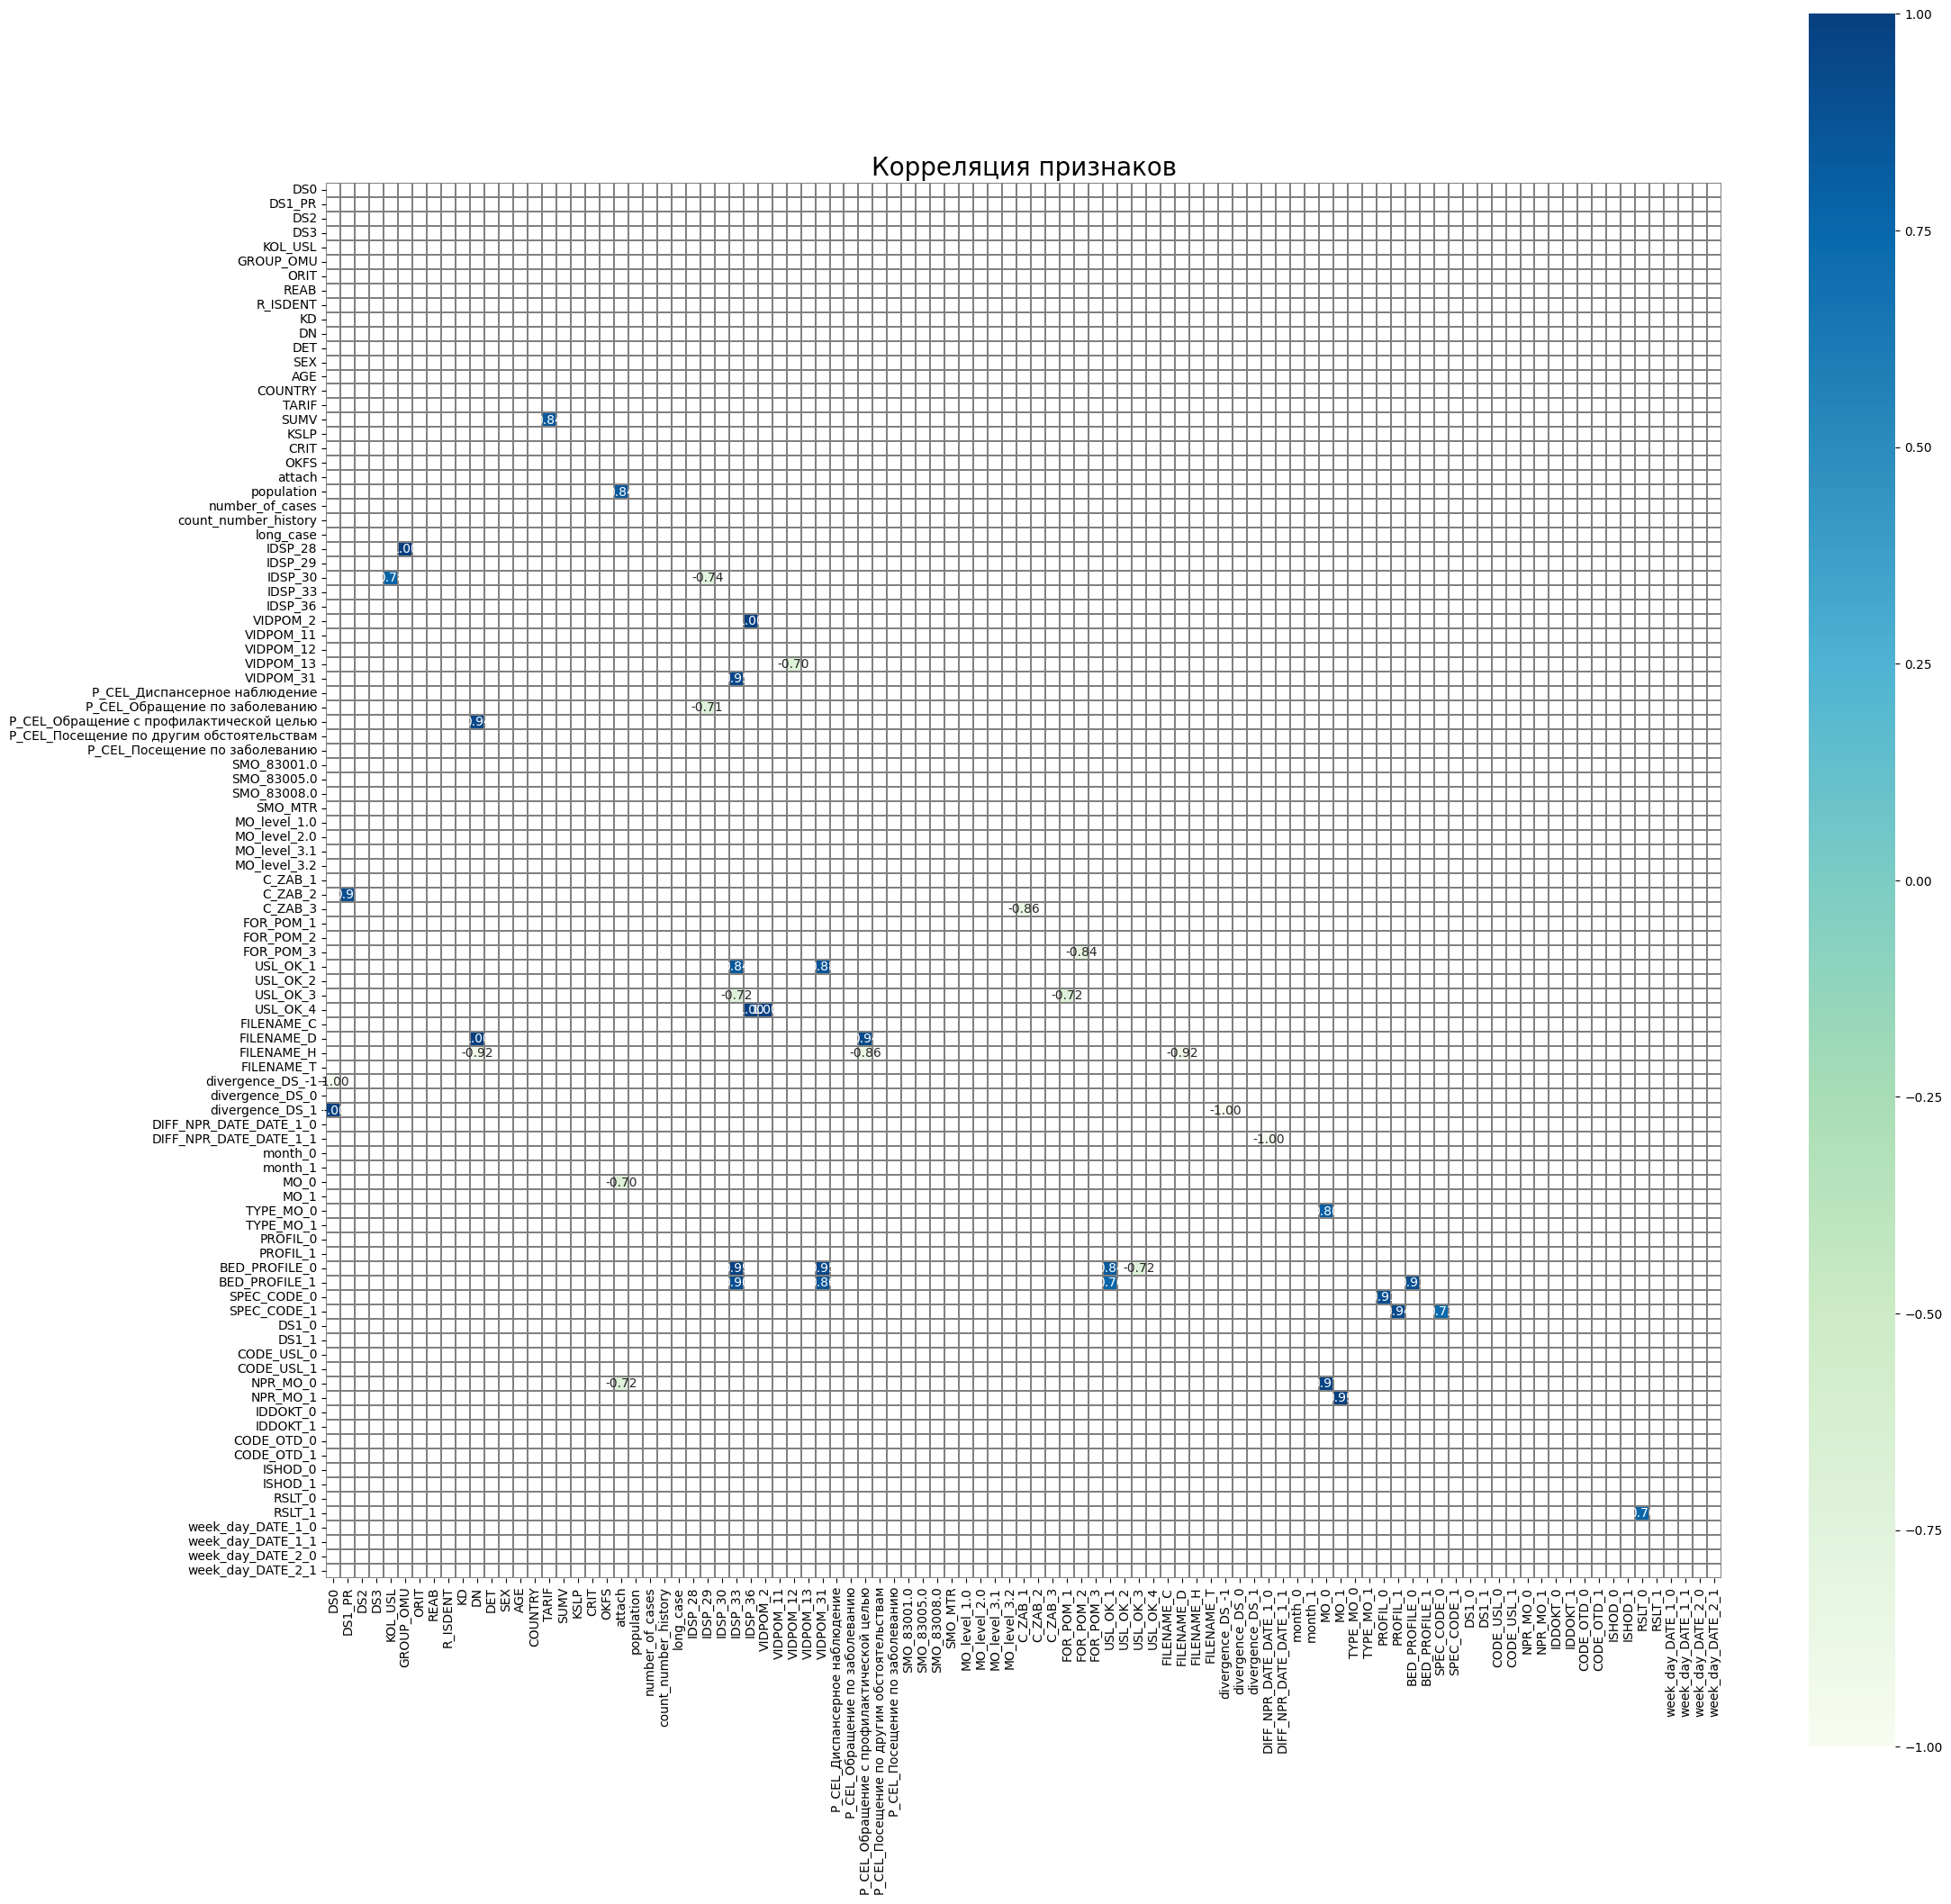

In [100]:
corr = data_MEE.corr(method='spearman')
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.subplots(figsize=(25, 25))

# для повышения информативности отобраения
# на графике - тепловой матрицы покажем значения
# с коэффициентами корреляции не менее 0.7
heatmap = sns.heatmap(
    corr[corr.abs() >= 0.7],
    vmin=-1,
    vmax=1,
    linewidth=0.1,
    linecolor='gray',
    cmap='GnBu',
    mask=mask,
    annot=True,
    fmt='.2f',
    square=True
)

# задаём заголовок
heatmap.set_title('Корреляция признаков', fontsize=20)

В следствии большого количества признаков матрица получилась не информативна, значения не читаемы. 

Попробуем сгруппировать скоррелированные признаки со значенимми корреляции более 0.7 в виде таблицы

In [101]:
corr = data_MEE.corr(method='spearman')
corr_unstack = corr.abs().unstack().reset_index()
corr_unstack = corr_unstack.rename(columns={'level_0': 'feature 1', 'level_1': 'feature 2', 0: 'Corr coeff'}).\
    sort_values(by='Corr coeff', ascending=False)
corr_final_MEE = corr_unstack[((corr_unstack['feature 1'] != corr_unstack['feature 2']) & (corr_unstack['Corr coeff'] > 0.7))].\
    iloc[0::2, :].reset_index(drop=True)
print('Корреляция между признаками не менее 0.7:')
corr_final_MEE

Корреляция между признаками не менее 0.7:


feature 1  \
0                                    IDSP_36   
1                                   VIDPOM_2   
2                                         DN   
3                                   USL_OK_4   
4                           divergence_DS_-1   
5                     DIFF_NPR_DATE_DATE_1_1   
6                            divergence_DS_1   
7                           divergence_DS_-1   
8                                    IDSP_28   
9                                   NPR_MO_1   
10                                   IDSP_33   
11                                      MO_0   
12                             BED_PROFILE_0   
13                                   IDSP_33   
14                                FILENAME_D   
15                                        DN   
16                                  PROFIL_1   
17                                FILENAME_D   
18                                        DN   
19                                    DS1_PR   
20                             BED_PROFILE_1   
21                               SPEC_CODE_0   
22                             BED_PROFILE_1   
23                                  USL_OK_1   
24  P_CEL_Обращение с профилактической целью   
25                             BED_PROFILE_1   
26                                   C_ZAB_3   
27                                    attach   
28                                      SUMV   
29                                 FOR_POM_3   
30                             BED_PROFILE_0   
31                                   IDSP_33   
32                                      MO_0   
33                                   KOL_USL   
34                                    RSLT_1   
35                                  USL_OK_1   
36                                   IDSP_30   
37                               SPEC_CODE_1   
38                                  USL_OK_3   
39                                  USL_OK_3   
40                                 FOR_POM_1   
41                                  NPR_MO_0   
42                                   IDSP_29   
43                                    attach   
44                                 VIDPOM_12   

                                   feature 2  Corr coeff  
0                                   VIDPOM_2    1.000000  
1                                    IDSP_36    1.000000  
2                                 FILENAME_D    1.000000  
3                                   VIDPOM_2    1.000000  
4                                        DS0    1.000000  
5                     DIFF_NPR_DATE_DATE_1_0    1.000000  
6                           divergence_DS_-1    0.998480  
7                            divergence_DS_1    0.998480  
8                                  GROUP_OMU    0.995078  
9                                       MO_1    0.993776  
10                             BED_PROFILE_0    0.989581  
11                                  NPR_MO_0    0.969698  
12                                 VIDPOM_31    0.952493  
13                                 VIDPOM_31    0.952008  
14  P_CEL_Обращение с профилактической целью    0.939613  
15  P_CEL_Обращение с профилактической целью    0.939613  
16                               SPEC_CODE_1    0.935169  
17                                FILENAME_H    0.922117  
18                                FILENAME_H    0.922117  
19                                   C_ZAB_2    0.911797  
20                             BED_PROFILE_0    0.910204  
21                                  PROFIL_0    0.905259  
22                                   IDSP_33    0.902556  
23                                 VIDPOM_31    0.880952  
24                                FILENAME_H    0.864772  
25                                 VIDPOM_31    0.863195  
26                                   C_ZAB_1    0.859776  
27                                population    0.843377  
28                                     TARIF    0.842253  
29                                 FOR_POM_2    0.839425

Количество признаков с высокими коэффициентами корреляции достаточно велико

Однако удалять их пока не будем, сначал оценим их значимость, а затем проведем эксперемены с удалением признаков и оценим эффективность этих действий.

    для оценки значимости признаков будем использовать тест взаимный информационный классификатор
    сделаем это раздельно для для категориальных и  числовых признаков.

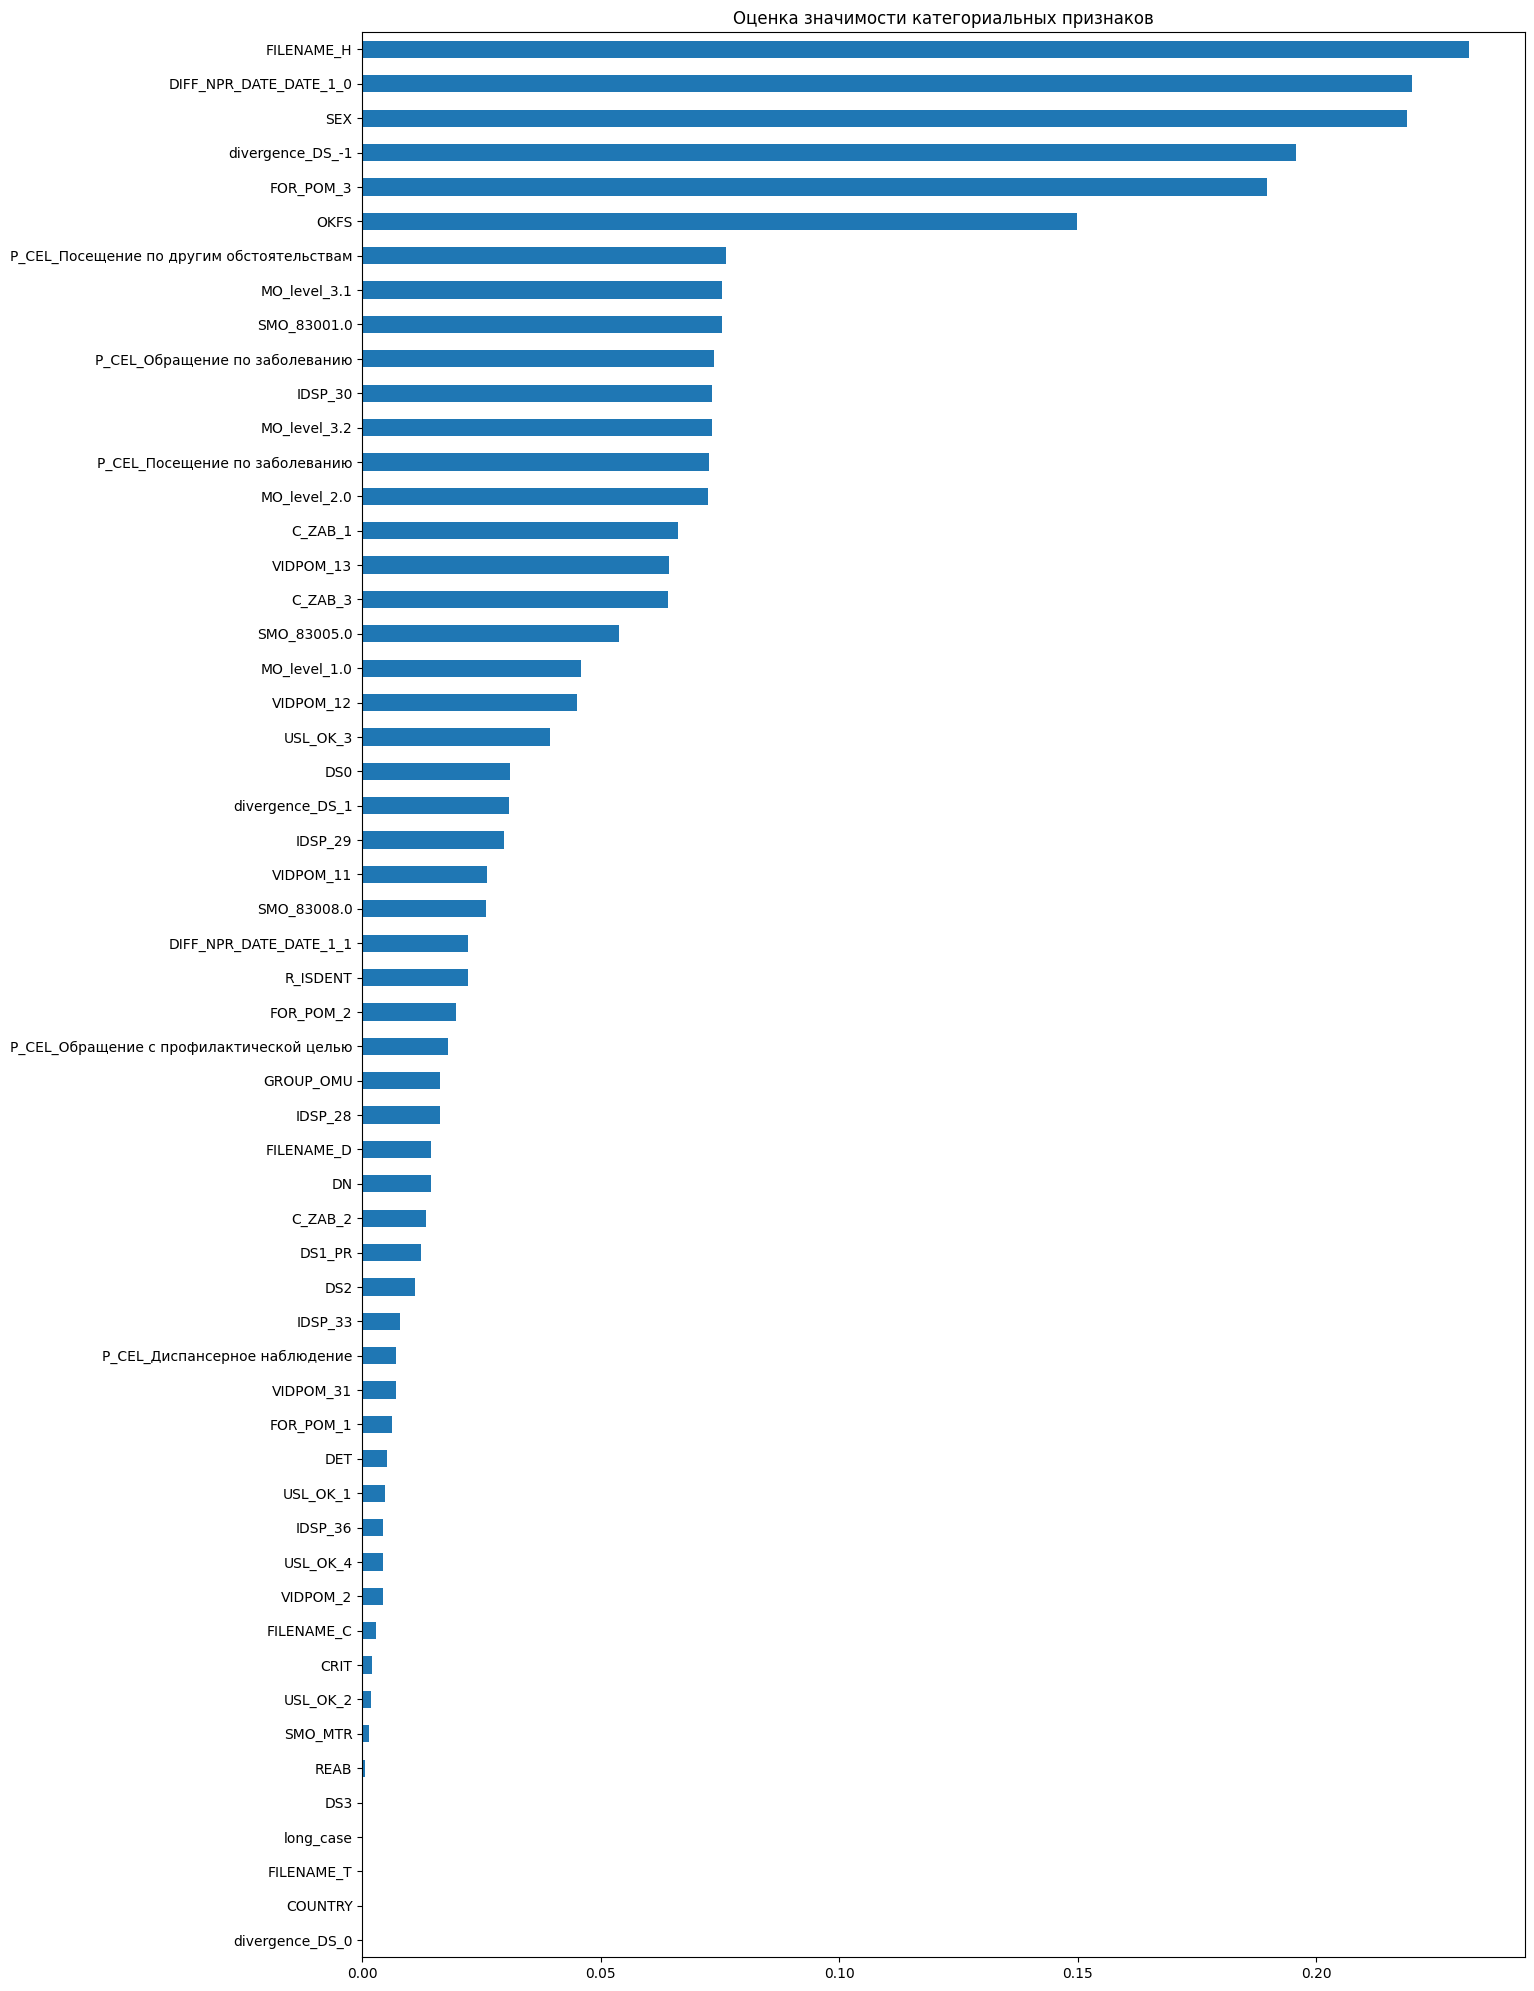

In [103]:
cat_cols = list(data_MEE.select_dtypes(['int8']).columns)
num_cols = list(data_MEE.select_dtypes(['float32', 'float64']).columns)
X = data_MEE

y = y.astype('int8')
imp_cat = pd.Series(mutual_info_classif(X[cat_cols], y), index=cat_cols)
imp_cat.sort_values(inplace=True)

fig, axes = plt.subplots(figsize=(15, 25))
imp_cat.plot(kind='barh',
             title='Оценка значимости категориальных признаков')

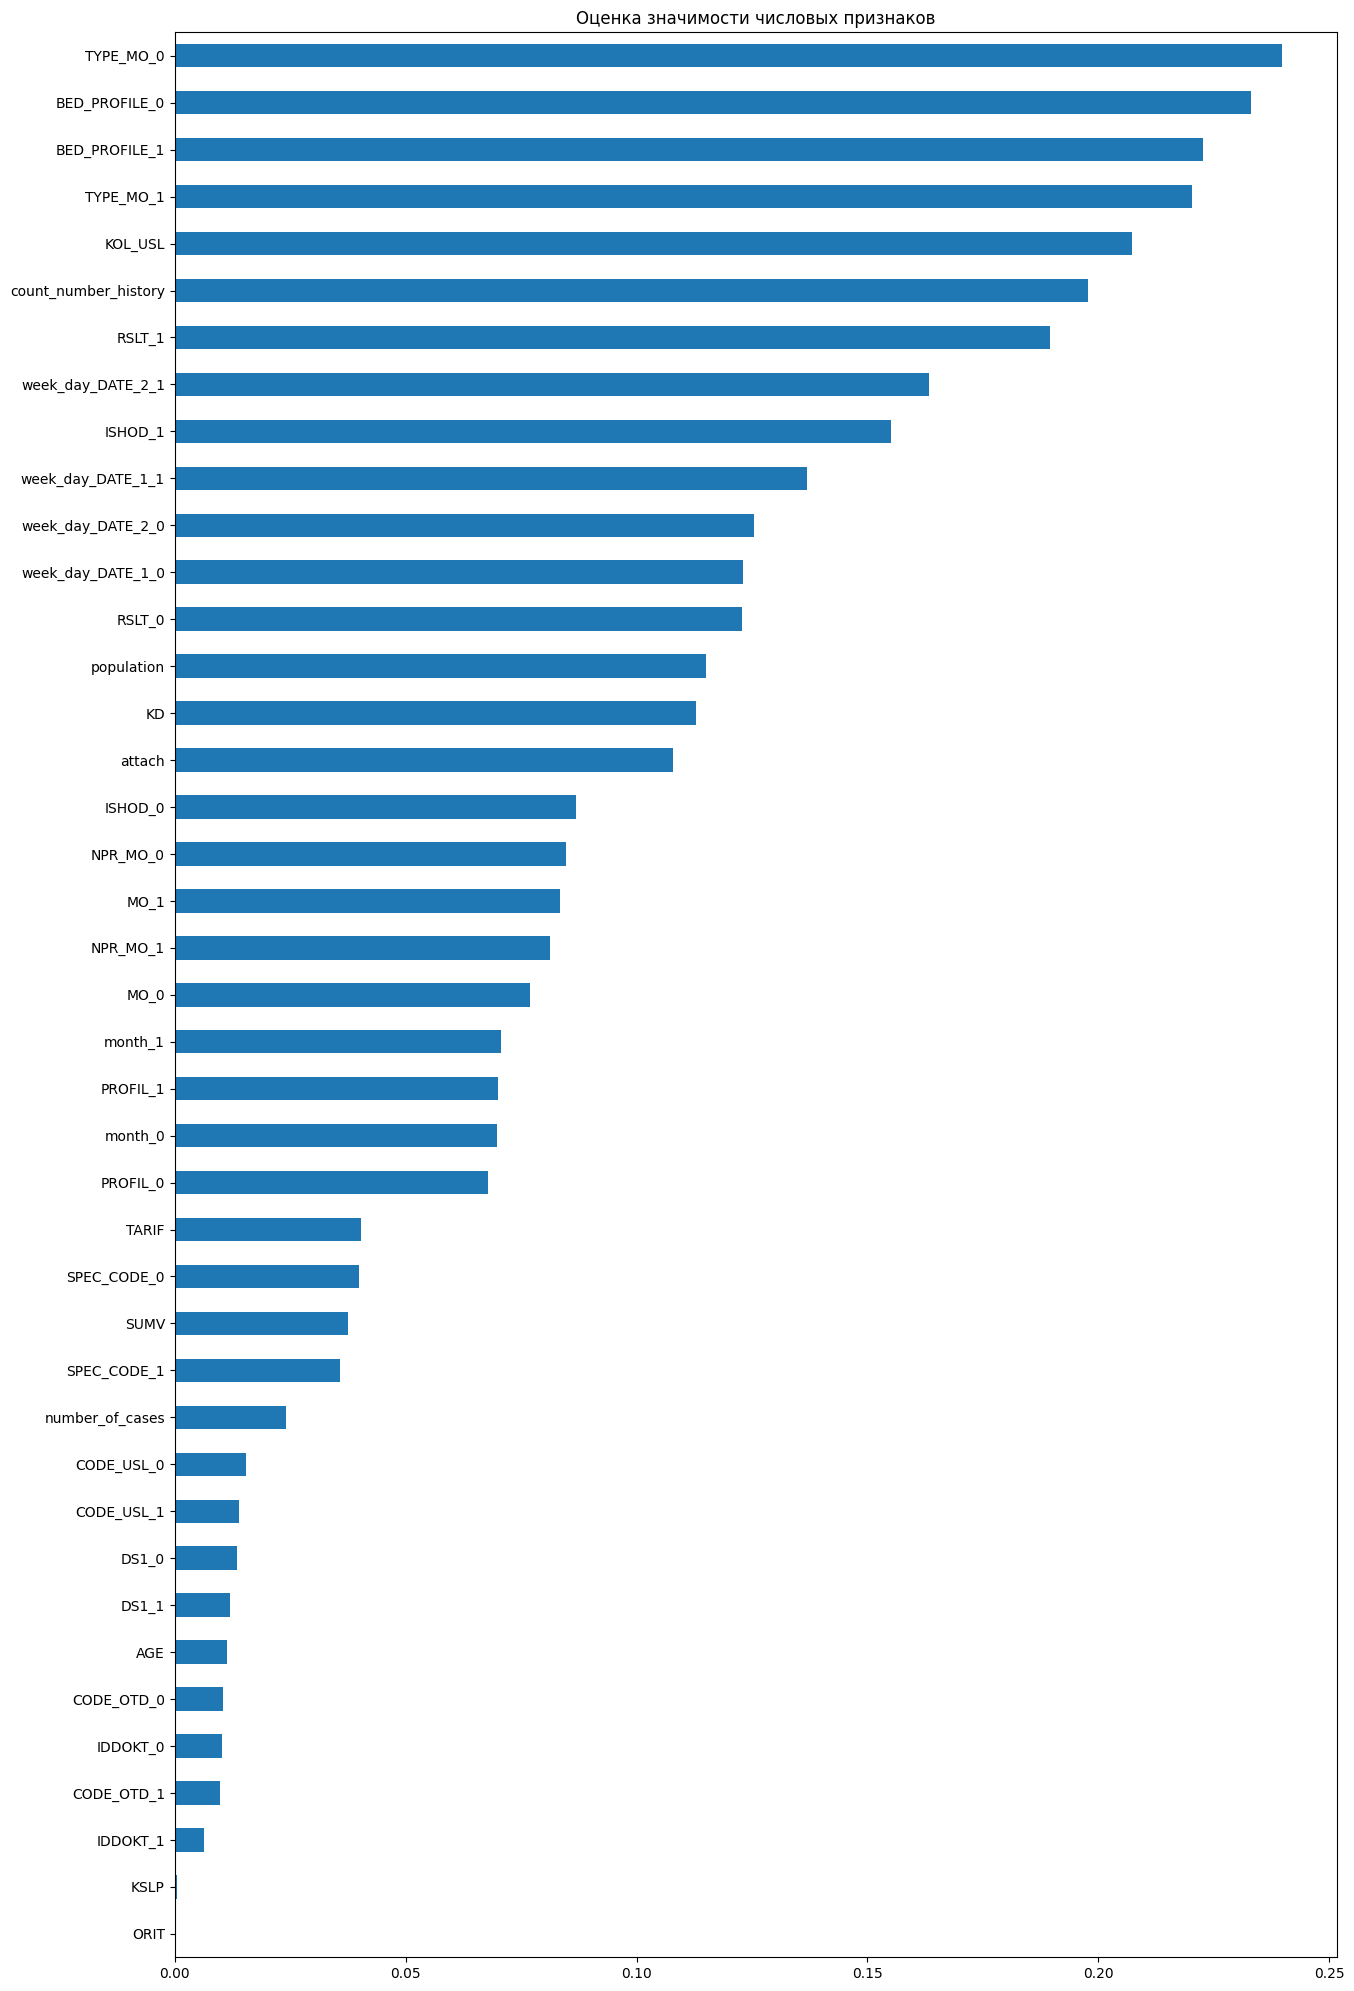

In [104]:
imp_num = pd.Series(mutual_info_classif(X[num_cols], y), index=num_cols)
imp_num.sort_values(inplace=True)

fig, axes = plt.subplots(figsize=(15, 25))
imp_num.plot(kind='barh',
             title='Оценка значимости числовых признаков')

Среди признаков с высокой значимостью признаков не возможно выделить отдельную группу (по собенностям лечения, условиям оказания медицинской помощи, характеристик пациента или МО) с наибольшей значимостью.

Часть признаков, на первый взгляд, не имеют значимости, посмотрим так ли это.

In [105]:
print('Минимальное значение значимости числового признака {}\n\
Минимальное значение значимости категориального признака {}'.format(imp_num.min(), imp_cat.min()))

Минимальное значение значимости числового признака 0.00014733206831596402
Минимальное значение значимости категориального признака 6.085106600262069e-05


Получается, что признаков с нулевой значимостью нет, хотя есть некоторое количество с низкой.

Проведем серию экспериментов с целью оценить, что больше влияет на точность работы модели.

Коэффициент значимости или мультиколинеарность высокоскоррелированных признаков и отберем наиболее подходящие параметры.

***Сохраним необходимые для дальнейшего отбора признаков данные***

In [106]:
corr_final_MEE.to_csv('data/corr_final_MEE.csv', index=False)
with open('data/imp_num_MEE.pkl', 'wb') as f:
    pickle.dump(imp_num, f)
with open('data/imp_cat_MEE.pkl', 'wb') as f:
    pickle.dump(imp_cat, f)

del data_MEE, y
gc.collect()

15839

***Повторим все действия для целевой целевой переменной ЭКМП***

Загрузим данные

In [108]:
with open('data/columns_dict.pkl', 'rb') as f:
    columns_dict = pickle.load(f)

load_dict = dict()
for key, value in columns_dict.items():
    for item in value:
        load_dict[item] = key

data_EKMP = pd.read_csv('data/X_EKMP_train.csv', dtype=load_dict)
y = pd.read_csv('data/y_EKMP_train.csv', dtype=load_dict)

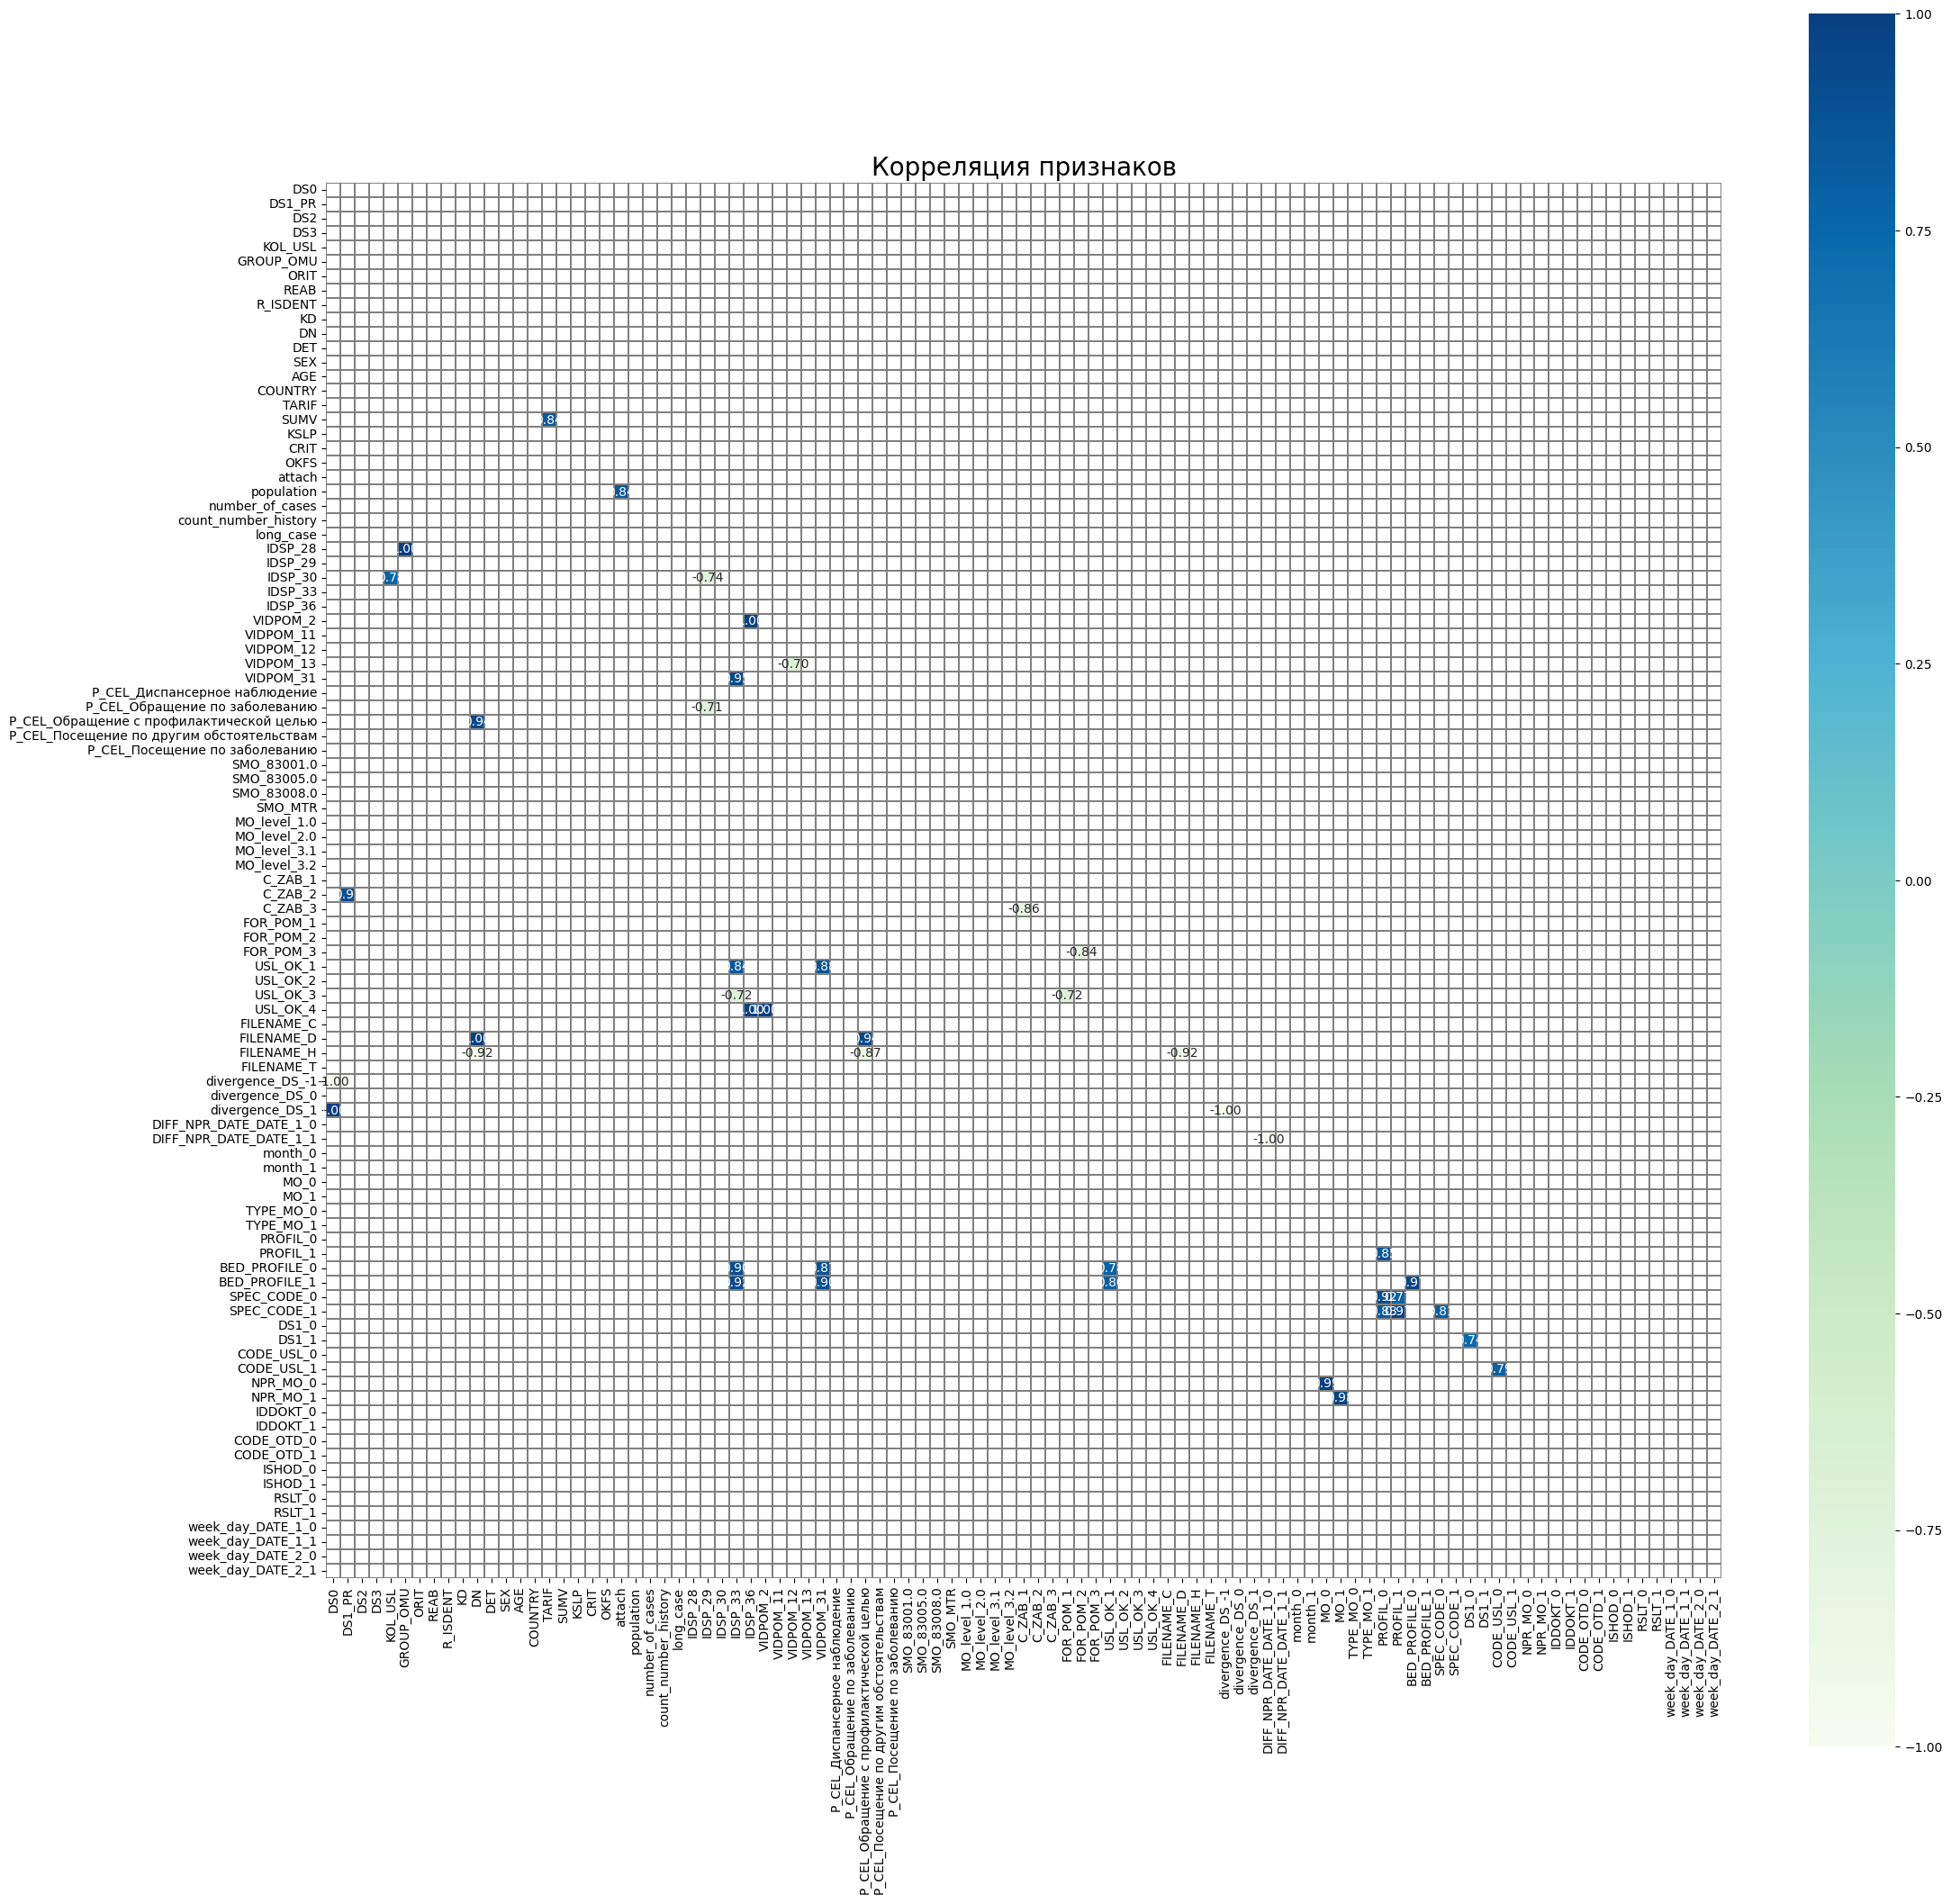

In [109]:
corr = data_EKMP.corr(method='spearman')
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.subplots(figsize=(25, 25))

# для повышения информативности отобраения
# на графике - тепловой матрицы покажем значения
# с коэффициентами корреляции не менее 0.7
heatmap = sns.heatmap(
    corr[corr.abs() >= 0.7],
    vmin=-1,
    vmax=1,
    linewidth=0.1,
    linecolor='gray',
    cmap='GnBu',
    mask=mask,
    annot=True,
    fmt='.2f',
    square=True
)

# задаём заголовок
heatmap.set_title('Корреляция признаков', fontsize=20)

В следствии большого количества признаков матрица получилась не информативна, значения не читаемы. 

Попробуем сгруппировать скоррелированные признаки со значенимми корреляции более 0.7 в виде таблицы

In [110]:
corr = data_EKMP.corr(method='spearman')
corr_unstack = corr.abs().unstack().reset_index()
corr_unstack = corr_unstack.rename(columns={'level_0': 'feature 1', 'level_1': 'feature 2', 0: 'Corr coeff'}).\
    sort_values(by='Corr coeff', ascending=False)
corr_final_EKMP = corr_unstack[((corr_unstack['feature 1'] != corr_unstack['feature 2']) & (corr_unstack['Corr coeff'] > 0.7))].\
    iloc[0::2, :].reset_index(drop=True)
print('Корреляция между признаками не менее 0.7:')
corr_final_EKMP

Корреляция между признаками не менее 0.7:


feature 1  \
0                                    IDSP_36   
1                                   VIDPOM_2   
2                                         DN   
3                                   USL_OK_4   
4                           divergence_DS_-1   
5                     DIFF_NPR_DATE_DATE_1_1   
6                            divergence_DS_1   
7                                        DS0   
8                                    IDSP_28   
9                                       MO_0   
10                                      MO_1   
11                             BED_PROFILE_1   
12                               SPEC_CODE_1   
13                                 VIDPOM_31   
14  P_CEL_Обращение с профилактической целью   
15                                FILENAME_D   
16                             BED_PROFILE_1   
17                                FILENAME_H   
18                                FILENAME_H   
19                               SPEC_CODE_0   
20                                   C_ZAB_2   
21                                   IDSP_33   
22                                 VIDPOM_31   
23                                  USL_OK_1   
24                                 VIDPOM_31   
25  P_CEL_Обращение с профилактической целью   
26                                   C_ZAB_1   
27                                  PROFIL_0   
28                                population   
29                                     TARIF   
30                                 FOR_POM_3   
31                                   IDSP_33   
32                               SPEC_CODE_1   
33                               SPEC_CODE_0   
34                                  USL_OK_1   
35                                CODE_USL_0   
36                                   KOL_USL   
37                             BED_PROFILE_0   
38                                  PROFIL_1   
39                                   IDSP_30   
40                                     DS1_0   
41                                   IDSP_33   
42                                 FOR_POM_1   
43            P_CEL_Обращение по заболеванию   
44                                 VIDPOM_12   

                                   feature 2  Corr coeff  
0                                   VIDPOM_2    1.000000  
1                                    IDSP_36    1.000000  
2                                 FILENAME_D    1.000000  
3                                   VIDPOM_2    1.000000  
4                                        DS0    1.000000  
5                     DIFF_NPR_DATE_DATE_1_0    1.000000  
6                           divergence_DS_-1    0.998453  
7                            divergence_DS_1    0.998453  
8                                  GROUP_OMU    0.995106  
9                                   NPR_MO_0    0.992460  
10                                  NPR_MO_1    0.978567  
11                             BED_PROFILE_0    0.969927  
12                                  PROFIL_1    0.969256  
13                                   IDSP_33    0.952034  
14                                        DN    0.939526  
15  P_CEL_Обращение с профилактической целью    0.939526  
16                                   IDSP_33    0.923112  
17                                FILENAME_D    0.922641  
18                                        DN    0.922641  
19                                  PROFIL_0    0.916831  
20                                    DS1_PR    0.911558  
21                             BED_PROFILE_0    0.898990  
22                             BED_PROFILE_1    0.895355  
23                                 VIDPOM_31    0.880096  
24                             BED_PROFILE_0    0.872124  
25                                FILENAME_H    0.865191  
26                                   C_ZAB_3    0.860057  
27                                  PROFIL_1    0.853071  
28                                    attach    0.843322  
29                                      SUMV    0.842208

Количество признаков с высокими коэффициентами корреляции достаточно велико

Однако удалять их пока не будем, сначал оценим их значимость, а затем проведем эксперемены с удалением признаков и оценим эффективность этих действий.

    для оценки значимости признаков будем использовать тест взаимный информационный классификатор
    сделаем это раздельно для для категориальных и  числовых признаков.

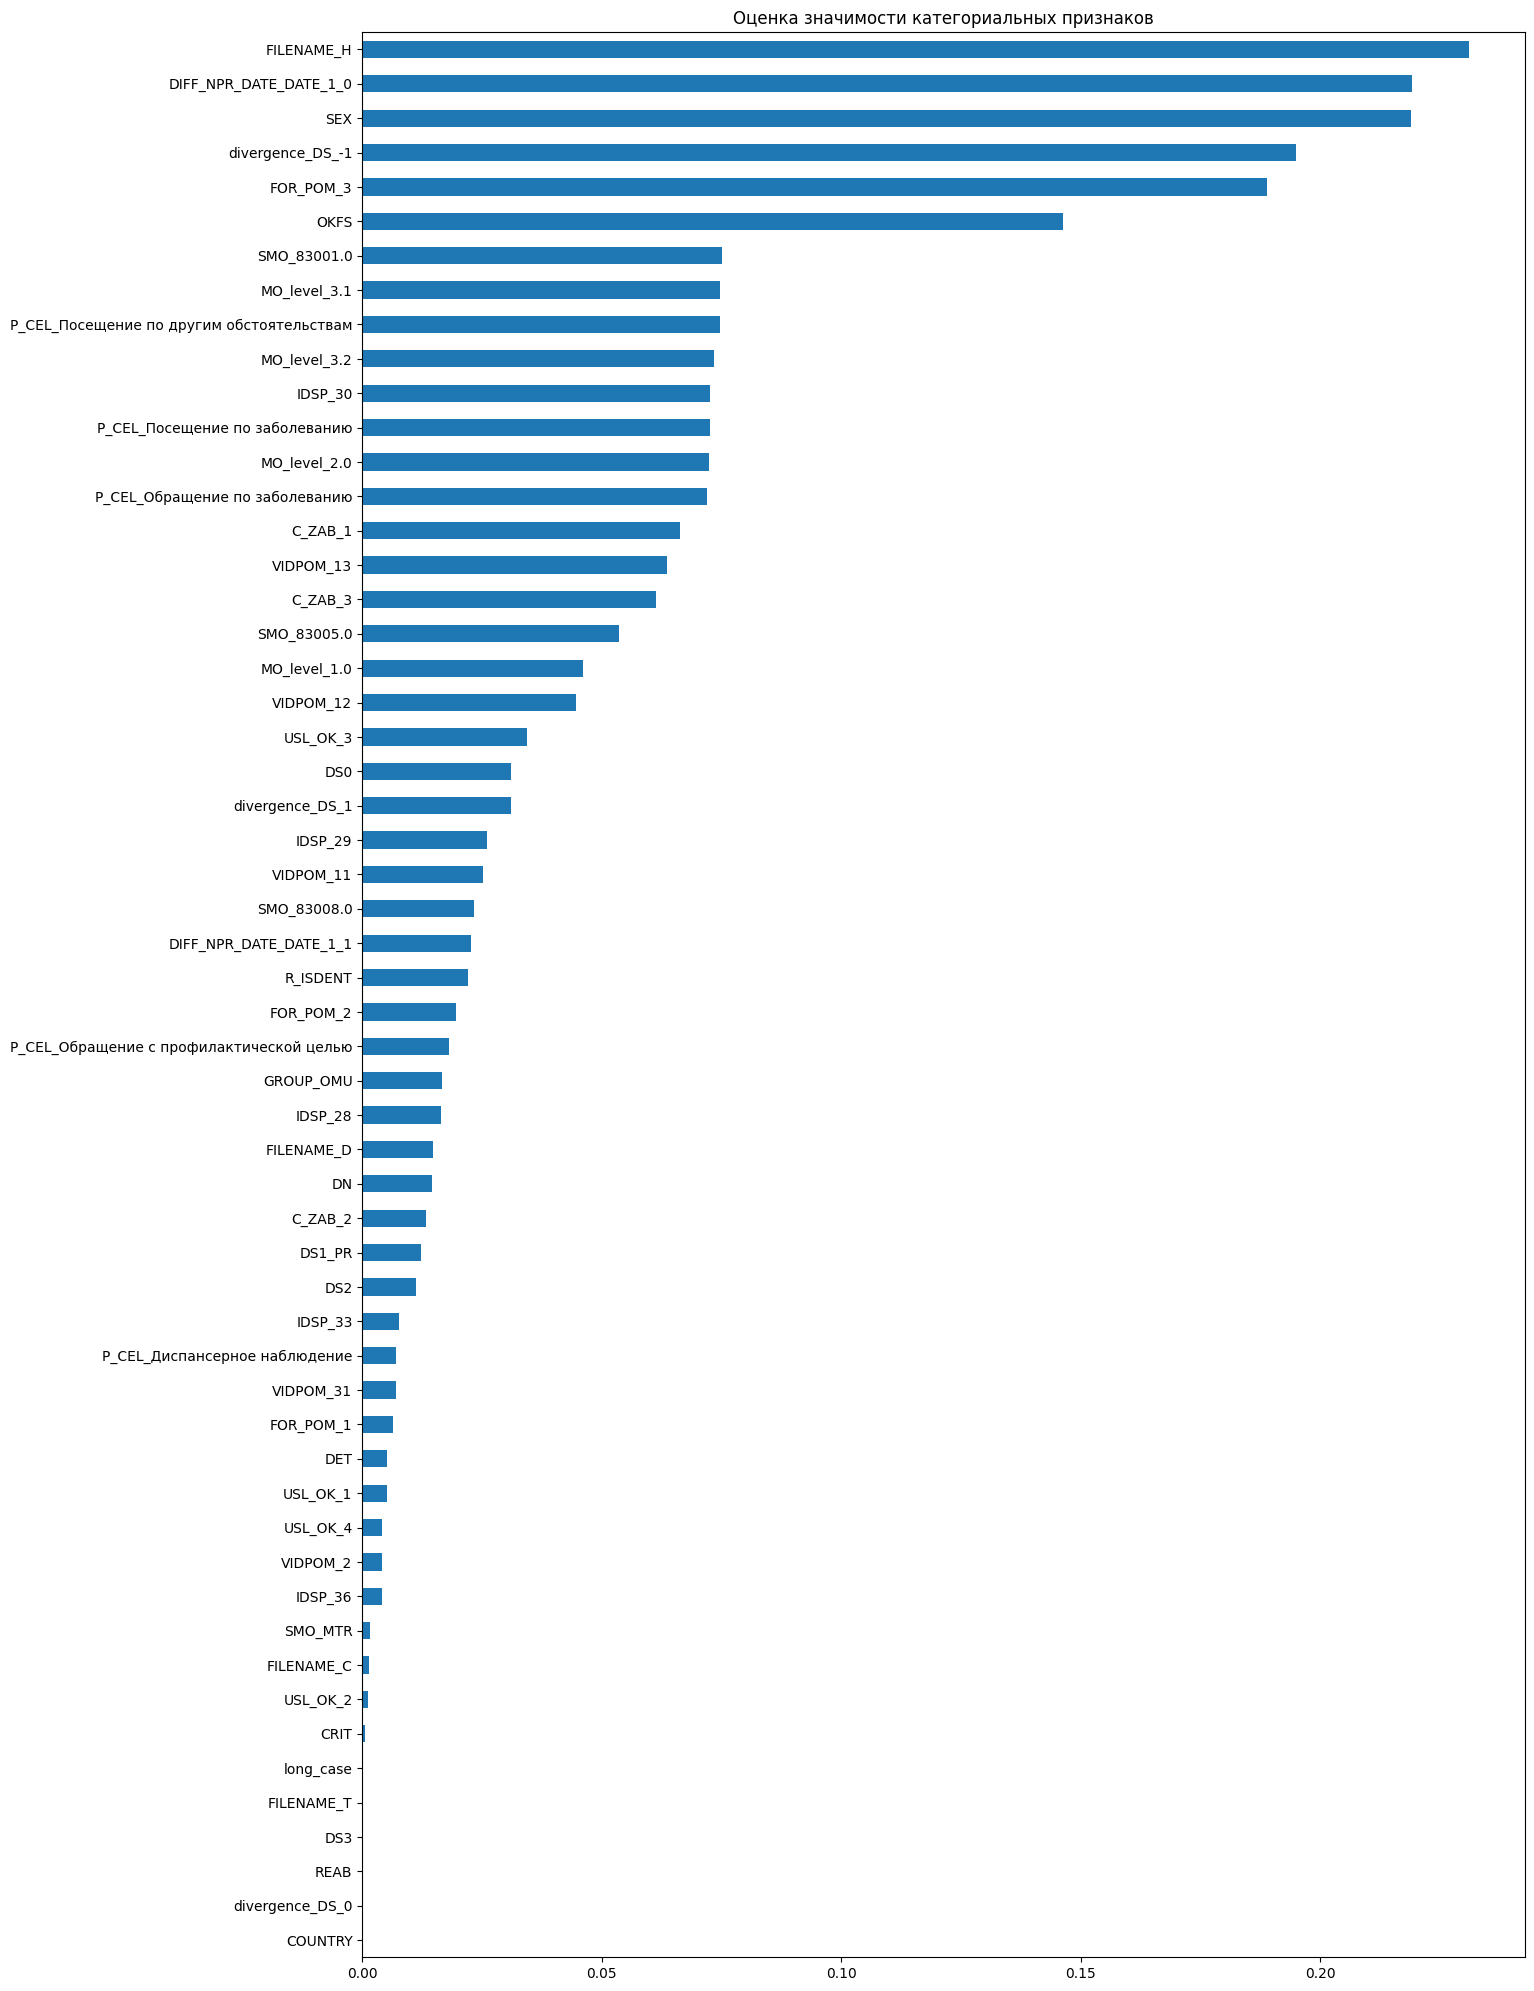

In [112]:
cat_cols = list(data_EKMP.select_dtypes(['int8']).columns)
num_cols = list(data_EKMP.select_dtypes(['float32', 'float64']).columns)
X = data_EKMP

y = y.astype('int8')
imp_cat = pd.Series(mutual_info_classif(X[cat_cols], y), index=cat_cols)
imp_cat.sort_values(inplace=True)

fig, axes = plt.subplots(figsize=(15, 25))
imp_cat.plot(kind='barh',
             title='Оценка значимости категориальных признаков')

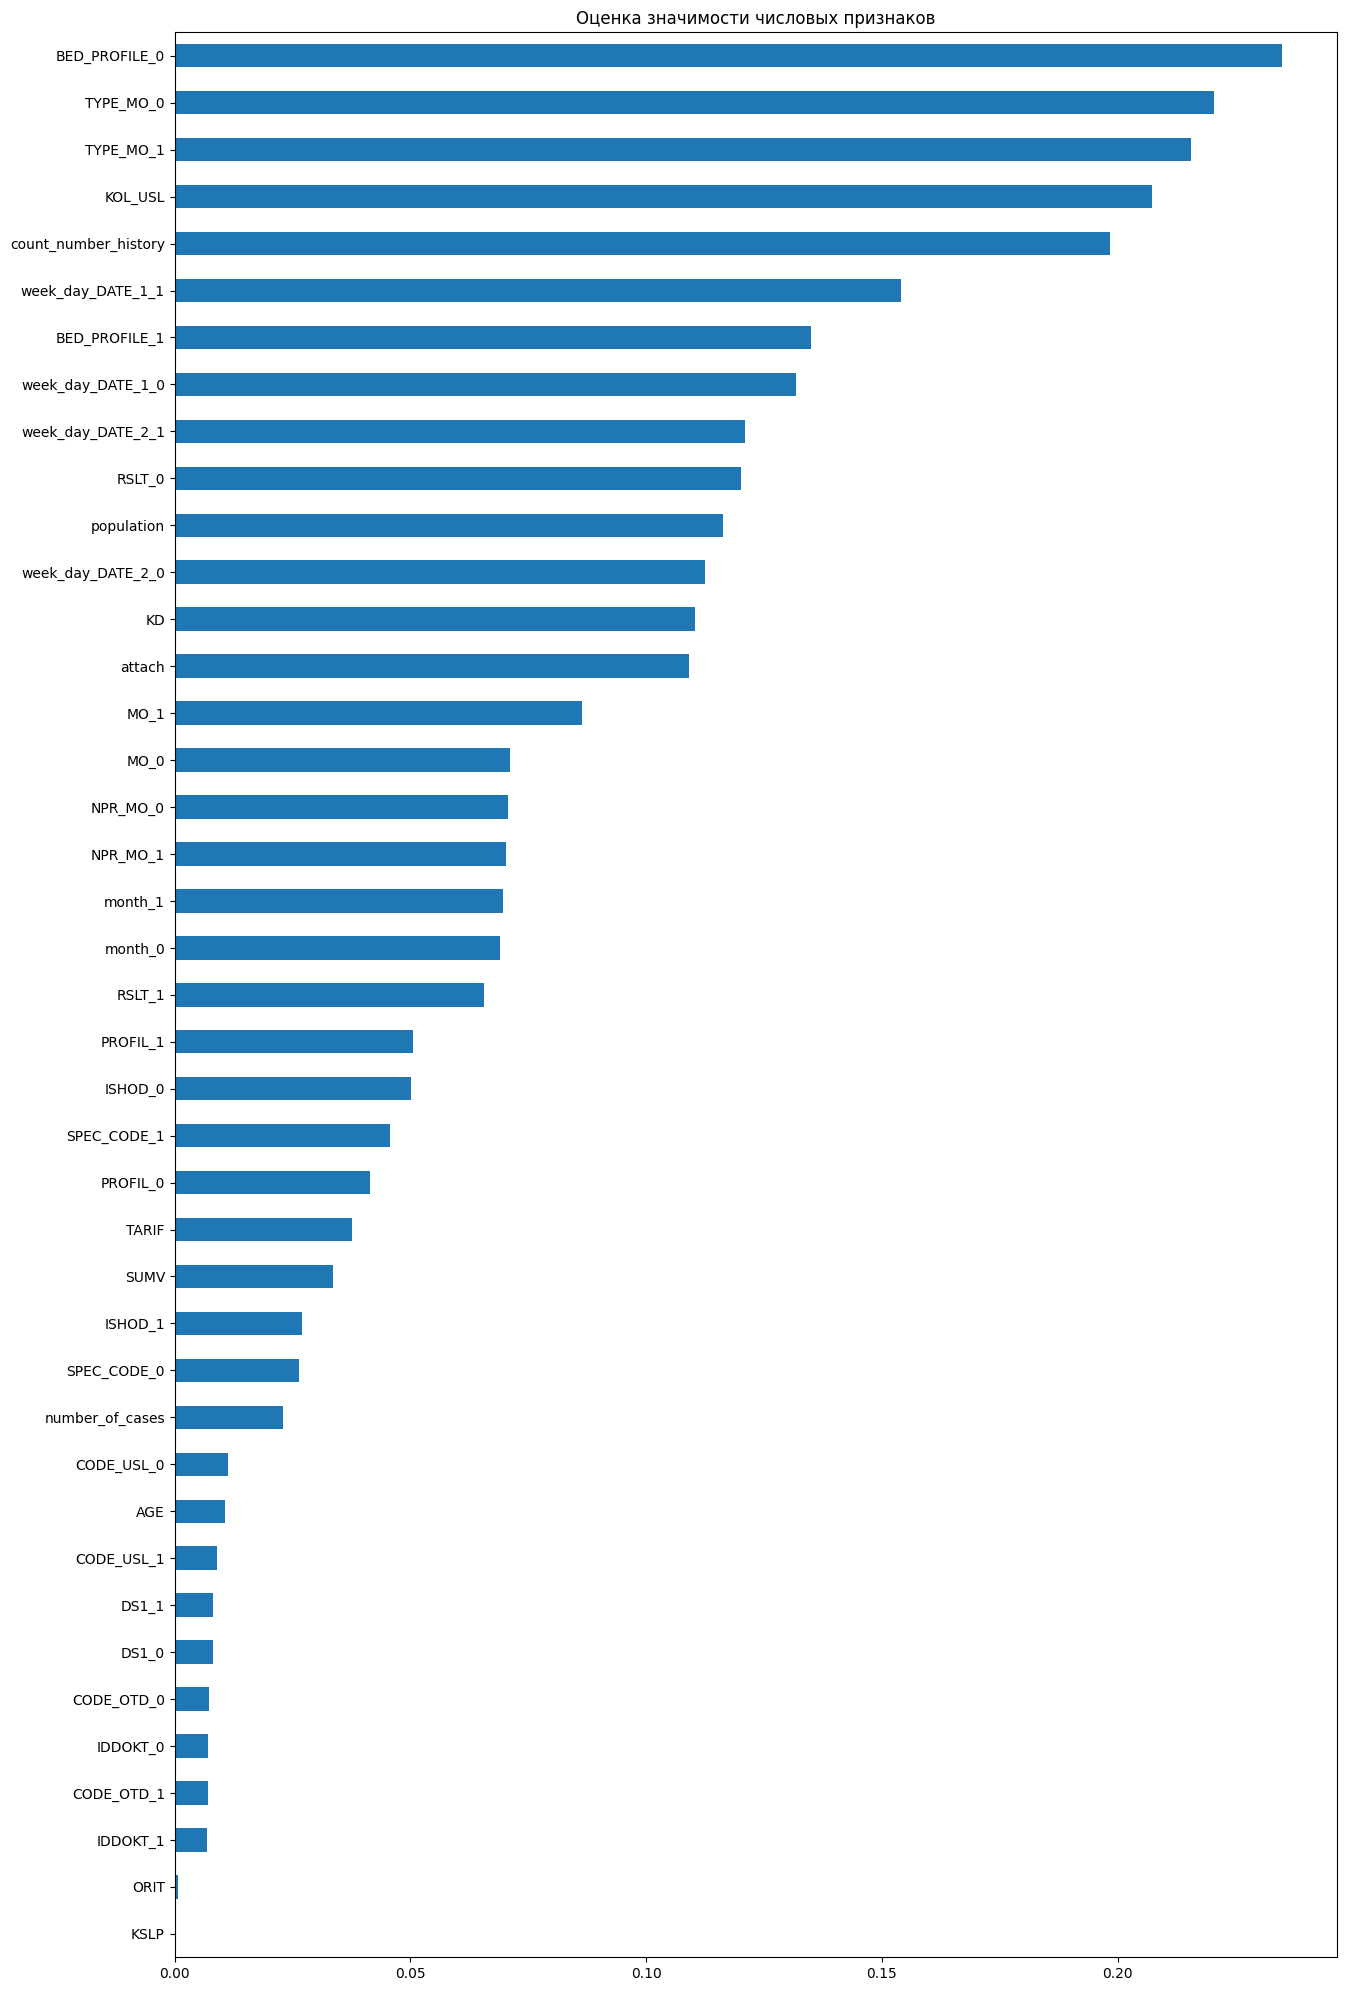

In [113]:
imp_num = pd.Series(mutual_info_classif(X[num_cols], y), index=num_cols)
imp_num.sort_values(inplace=True)

fig, axes = plt.subplots(figsize=(15, 25))
imp_num.plot(kind='barh',
             title='Оценка значимости числовых признаков')

Среди признаков с высокой значимостью признаков не возможно выделить отдельную группу (по собенностям лечения, условиям оазания медицинской помощи, характеристик пациента или МО) с наибольшей значимостью.

Часть признаков, на первый взгляд, не имеют значимости, посмотрим так ли это.

In [114]:
print('Минимальное значение значимости числового признака {}\n\
Минимальное значение значимости категориального признака {}'.format(imp_num.min(), imp_cat.min()))

Минимальное значение значимости числового признака 0.00031919080550291135
Минимальное значение значимости категориального признака 0.0


Получается, что признаков с нулевой значимостью нет, хотя есть некоторое количество с низкой.

Проведем серию экспериментов с целью оценить, что больше влияет на точность работы модели.

Коэффициент значимости или мультиколинеарность высокоскоррелированных признаков и отберем наиболее подходящие параметры.

***Сохраним необходимые для дальнейшего отбора признаков данные***

In [115]:
corr_final_EKMP.to_csv('data/corr_final_EKMP.csv', index=False)
with open('data/imp_num_EKMP.pkl', 'wb') as f:
    pickle.dump(imp_num, f)
with open('data/imp_cat_EKMP.pkl', 'wb') as f:
    pickle.dump(imp_cat, f)

del data_EKMP, y
gc.collect()

11174

# 3. Обучение модели и получение предсказания 

## 3.1 Предсказание вероятности дефектов МЕЕ


Попробуем обучить модель логистической регрессии, что бы получить базовую модель на датасете без удаления коррелированных и малозначимых признаков.  
Целевая переменная резко дисбалансирована, что очень важно для задачи классификации.  
В качестве метрик будем использовать набор метрик из classification_report, что позволяет видеть эффективность модели для каждого класса. Ориентироваться будем на f1-score, так же обращая внимание на выраженость recall при равных значениях иных метрик. Распространенную метрику accuracy в данном случае мы использовать не можем, потому что она не учитывает дисбаланс классов и при выраженном дисбалансе ее результат будет не верным за счёт возможного высокого результата в мажоритарном классе.

In [117]:
corr_final_MEE = pd.read_csv('data/corr_final_MEE.csv')
with open('data/columns_dict.pkl', 'rb') as f:
    columns_dict = pickle.load(f)

load_dict = dict()
for key, value in columns_dict.items():
    for item in value:
        load_dict[item] = key

X = pd.read_csv('data/X_MEE_train.csv', dtype=load_dict)
y = pd.read_csv('data/y_MEE_train.csv', dtype='int8')
y = y['MEE'].apply(lambda x: 2 if x == -1 else x)

with open('data/imp_cat_MEE.pkl', 'rb') as f:
    imp_cat = pickle.load(f)
with open('data/imp_num_MEE.pkl', 'rb') as f:
    imp_num = pickle.load(f)

Разделим данные на обучающую и валидационную выборки, используя стратифицированное разбиение

In [118]:
X_train, X_valid, y_train, y_valid = train_test_split(X,
                                                      y,
                                                      stratify=y,
                                                      random_state=RANDOM_STATE,
                                                      test_size=0.20)

In [119]:
# создаем модель
lr = LogisticRegression(solver='sag',
                        class_weight='balanced',
                        multi_class='multinomial',
                        random_state=RANDOM_STATE,
                        n_jobs=-1,
                        max_iter=1000)
# выполним обучение
lr.fit(X_train, y_train)
# выполним предсказание
y_pred = lr.predict(X_valid)
# получим результат расчёта метрики
print(metrics.classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

          -1       1.00      0.64      0.78   1017641
           0       0.03      0.65      0.05      9352
           1       0.01      0.51      0.01      1679

    accuracy                           0.64   1028672
   macro avg       0.34      0.60      0.28   1028672
weighted avg       0.99      0.64      0.77   1028672



Результат получился очень плохим, крайне низкие значения f1-score особенно для минорных категорий целевой переменной. повторим расчёт используя древовидную модель - LGBMClassifier. 

In [120]:
# создаем модель
model = LGBMClassifier()
# выполним обучение
model.fit(X_train, y_train)
# выполним предсказание
y_pred = model.predict(X_valid)
# получим результат расчёта метрики
print(metrics.classification_report(y_valid, y_pred))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.958562 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3774
[LightGBM] [Info] Number of data points in the train set: 2743123, number of used features: 96
[LightGBM] [Info] Start training from score -0.010781
[LightGBM] [Info] Start training from score -4.700419
[LightGBM] [Info] Start training from score -6.417899
              precision    recall  f1-score   support

          -1       0.99      1.00      0.99    678427
           0       0.61      0.14      0.23      6235
           1       0.35      0.15      0.21      1119

    accuracy                           0.99    685781
   macro avg       0.65      0.43      0.48    685781
weighted avg       0.99      0.99      0.99    685781



Результат значительно лучше, однако по минорным категориям метрики остаются очень низкими.  
Удалим из датафрейма признаки по которым коэффициент корреляции превысил 0.7 и повторим расчёт

In [121]:
feature_1 = set(corr_final_MEE['feature 1'])
feature_2 = set(corr_final_MEE['feature 2'])
drop_list = list(feature_1.intersection(feature_2))
X_drop_kor = X.drop(drop_list, axis=1)
corr = X_drop_kor.corr(method='spearman')
corr_unstack = corr.abs().unstack().reset_index()
corr_unstack = corr_unstack.rename(columns={'level_0': 'feature 1', 'level_1': 'feature 2', 0: 'Corr coeff'}).\
    sort_values(by='Corr coeff', ascending=False)
corr_final_MEE = corr_unstack[((corr_unstack['feature 1'] != corr_unstack['feature 2']) & (corr_unstack['Corr coeff'] > 0.7))].\
    iloc[0::2, :].reset_index(drop=True)
feature_1 = set(corr_final_MEE['feature 1'])
feature_2 = set(corr_final_MEE['feature 2'])
drop_list = list(feature_1.difference(feature_2))
X_drop_kor = X_drop_kor.drop(drop_list, axis=1)
X_train, X_valid, y_train, y_valid = train_test_split(X_drop_kor,
                                                      y,
                                                      stratify=y,
                                                      random_state=RANDOM_STATE,
                                                      test_size=0.20)

In [122]:
# создаем модель
model = LGBMClassifier()
# выполним обучение
model.fit(X_train, y_train)
# выполним предсказание
y_pred = model.predict(X_valid)
# получим результат расчёта метрики
print(metrics.classification_report(y_valid, y_pred))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.695978 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3343
[LightGBM] [Info] Number of data points in the train set: 2743123, number of used features: 82
[LightGBM] [Info] Start training from score -0.010781
[LightGBM] [Info] Start training from score -4.700419
[LightGBM] [Info] Start training from score -6.417899
              precision    recall  f1-score   support

          -1       0.99      1.00      0.99    678427
           0       0.42      0.13      0.20      6235
           1       0.33      0.17      0.23      1119

    accuracy                           0.99    685781
   macro avg       0.58      0.43      0.47    685781
weighted avg       0.98      0.99      0.99    685781



Результат отрицательный, метрики ухудшились.  
Удалим данные с низким коэффициентом значимости и повторим расчёт.

In [123]:
drop_list_cat = list(imp_cat[imp_cat < 0.002].index)
drop_list_num = list(imp_num[imp_num < 0.002].index)
drop_list = drop_list_cat + drop_list_num

X_drop_imp = X.drop(drop_list, axis=1)
X_train, X_valid, y_train, y_valid = train_test_split(X_drop_imp,
                                                      y,
                                                      stratify=y,
                                                      random_state=RANDOM_STATE,
                                                      test_size=0.20)

In [124]:
# создаем модель
model = LGBMClassifier()
# выполним обучение
model.fit(X_train, y_train)
# выполним предсказание
y_pred = model.predict(X_valid)
# получим результат расчёта метрики
print(metrics.classification_report(y_valid, y_pred))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.934842 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3748
[LightGBM] [Info] Number of data points in the train set: 2743123, number of used features: 86
[LightGBM] [Info] Start training from score -0.010781
[LightGBM] [Info] Start training from score -4.700419
[LightGBM] [Info] Start training from score -6.417899
              precision    recall  f1-score   support

          -1       0.99      1.00      0.99    678427
           0       0.63      0.14      0.23      6235
           1       0.34      0.16      0.21      1119

    accuracy                           0.99    685781
   macro avg       0.65      0.43      0.48    685781
weighted avg       0.99      0.99      0.99    685781



Метрики улучшились незначительно, результат неприемлемый.  
Попробуем модель XGBClassifier.

In [125]:
y = y['MEE'].apply(lambda x: 2 if x == -1 else x)
X_train, X_valid, y_train, y_valid = train_test_split(X,
                                                      y,
                                                      stratify=y,
                                                      random_state=RANDOM_STATE,
                                                      test_size=0.20)

In [126]:
# создаем модель
model_xgb = xgb.XGBClassifier(tree_method="hist")
# выполним обучение
model_xgb.fit(X_train, y_train)
# выполним предсказание
y_pred = model_xgb.predict(X_valid)
# получим результат расчёта метрики
print(metrics.classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.14      0.24      6235
           1       0.81      0.14      0.23      1119
           2       0.99      1.00      1.00    678427

    accuracy                           0.99    685781
   macro avg       0.87      0.42      0.49    685781
weighted avg       0.99      0.99      0.99    685781



Результат несколько лучше, однако значение мерики recall крайне низкое для минорных классов и значение f1-score остается неприемлемо низким.  
Попробуем убрать не из датафрейма признаки по которым коэффициент корреляции превысил 0.7 и повторим расчёт.

In [127]:
feature_1 = set(corr_final_MEE['feature 1'])
feature_2 = set(corr_final_MEE['feature 2'])
drop_list = list(feature_1.intersection(feature_2))
X_drop_kor = X.drop(drop_list, axis=1)
corr = X_drop_kor.corr(method='spearman')
corr_unstack = corr.abs().unstack().reset_index()
corr_unstack = corr_unstack.rename(columns={'level_0': 'feature 1', 'level_1': 'feature 2', 0: 'Corr coeff'}).\
    sort_values(by='Corr coeff', ascending=False)
corr_final_MEE = corr_unstack[((corr_unstack['feature 1'] != corr_unstack['feature 2']) & (corr_unstack['Corr coeff'] > 0.7))].\
    iloc[0::2, :].reset_index(drop=True)
feature_1 = set(corr_final_MEE['feature 1'])
feature_2 = set(corr_final_MEE['feature 2'])
drop_list = list(feature_1.difference(feature_2))
X_drop_kor = X_drop_kor.drop(drop_list, axis=1)
X_train, X_valid, y_train, y_valid = train_test_split(X_drop_kor,
                                                      y,
                                                      stratify=y,
                                                      random_state=RANDOM_STATE,
                                                      test_size=0.20)

In [128]:
# создаем модель
model_xgb = xgb.XGBClassifier(tree_method="hist")
# выполним обучение
model_xgb.fit(X_train, y_train)
# выполним предсказание
y_pred = model_xgb.predict(X_valid)
# получим результат расчёта метрики
print(metrics.classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.13      0.23      6235
           1       0.77      0.13      0.23      1119
           2       0.99      1.00      1.00    678427

    accuracy                           0.99    685781
   macro avg       0.85      0.42      0.48    685781
weighted avg       0.99      0.99      0.99    685781



Результат отрицательный, значения метрик ухудшились.  
Попробуем удалить малозначимые признаки и повторить расчёт.

In [129]:
drop_list_cat = list(imp_cat[imp_cat < 0.002].index)
drop_list_num = list(imp_num[imp_num < 0.002].index)
drop_list = drop_list_cat + drop_list_num

X_drop_imp = X.drop(drop_list, axis=1)
X_train, X_valid, y_train, y_valid = train_test_split(X_drop_imp,
                                                      y,
                                                      stratify=y,
                                                      random_state=RANDOM_STATE,
                                                      test_size=0.20)

In [130]:
# создаем модель
model_xgb = xgb.XGBClassifier(tree_method="hist")
# выполним обучение
model_xgb.fit(X_train, y_train)
# выполним предсказание
y_pred = model_xgb.predict(X_valid)
# получим результат расчёта метрики
print(metrics.classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.14      0.24      6235
           1       0.80      0.14      0.24      1119
           2       0.99      1.00      1.00    678427

    accuracy                           0.99    685781
   macro avg       0.86      0.43      0.49    685781
weighted avg       0.99      0.99      0.99    685781



Протестируем эффективность метода ближайших соседей в качестве дополнительной метрики рассмотрим так же roc_auc_score как интегральную метрику качества классификации, которая достаточно неплохо работает при дисбалансе классов целевой переменной.

In [131]:
# создаем модель
neigh = KNeighborsClassifier(n_neighbors=5)
# выполним обучение
neigh.fit(X_train, y_train)
# выполним предсказание и получим результат расчёта метрики
print(metrics.classification_report(y_valid, neigh.predict(X_valid)))
print('roc_auc_score на тестовом наборе: {:.2f}'.format(metrics.roc_auc_score(
    y_valid, neigh.predict_proba(X_valid), multi_class='ovr')))

              precision    recall  f1-score   support

           0       0.49      0.08      0.13      6235
           1       0.30      0.04      0.08      1119
           2       0.99      1.00      0.99    678427

    accuracy                           0.99    685781
   macro avg       0.59      0.37      0.40    685781
weighted avg       0.98      0.99      0.99    685781

roc_auc_score на тестовом наборе: 0.64


Эффективность не высока

Попробуем подобрать оптимальный порог удаления малозначимых признаков.

In [132]:
for i in range(4, 16):
    drop_coeff = 0.001*(i)
    print('Порог = ', drop_coeff)
    drop_list_cat = list(imp_cat[imp_cat < drop_coeff].index)
    drop_list_num = list(imp_num[imp_num < drop_coeff].index)
    drop_list = drop_list_cat + drop_list_num

    X_drop_imp = X.drop(drop_list, axis=1)
    X_train, X_valid, y_train, y_valid = train_test_split(X_drop_imp,
                                                          y,
                                                          stratify=y,
                                                          random_state=RANDOM_STATE,
                                                          test_size=0.20)
    print(i)
    # для расчёта эффективности используем функцию,
    # обучаемую на переданных данный и печатающую результат
    # расчёта метрик
    lgbm_calc(X_train, y_train, X_valid, y_valid)

Порог =  0.004
4
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.780966 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3739
[LightGBM] [Info] Number of data points in the train set: 2743123, number of used features: 85
[LightGBM] [Info] Start training from score -4.700419
[LightGBM] [Info] Start training from score -6.417899
[LightGBM] [Info] Start training from score -0.010781
              precision    recall  f1-score   support

           0       0.61      0.14      0.23      6235
           1       0.38      0.17      0.23      1119
           2       0.99      1.00      0.99    678427

    accuracy                           0.99    685781
   macro avg       0.66      0.44      0.49    685781
weighted avg       0.99      0.99      0.99    685781

Порог

За оптимальный можно принять порог 0.012

Метрики несколько улучшились, но остаются очень низкими.  
Поскольку классы целевой переменной сильно дисбалансированы попробуем применить методику выравнивания дисбаланса.   

#### тест сочетания оверсемплинга и андерсемплинга  
попробуем протестировать эффективность оверсемплинга и сочетание оверсемплинга с различными вариантами андерсемплинга над полученными при андерсемплинге данными.

In [134]:
# датафрейм для хранения результатов расчётов метрик
report_df = pd.DataFrame(columns=['model', 'precision_0', 'recall_0', 'f1-score_0',
                         'precision_1', 'recall_1', 'f1-score_1', 'precision_2', 'recall_2', 'f1-score_2'])
# справочник с различными сочетаниями методов оверсемплинга и андерсемплинга
ower_under_dict = {'SMOTENC': ['TomekLinks', 'InstanceHardnessThreshold', 'OneSidedSelection',
                               'AllKNN', 'NearMiss', 'NeighbourhoodCleaningRule', 'EditedNearestNeighbours']}
# процедура стратифицированно разделяющая датасет на тестовую
# и валидационную выборки в переданной пропорции
# с удалением малозначимых переменных
X_train, X_valid, y_train, y_valid = get_train_valid_file(
    X, y, imp_cat, imp_num, 0.30)
# процедура выполняющая по параметрам из справочника ower_under_dict
# андерсемплинг и оверсемплинга, печатающая результат расчёта метрик
# и заполняющая датафрейм результатами расчёта метрик
under_ower_test(ower_under_dict, report_df, X_train, y_train, X_valid, y_valid)

SMOTENC
              precision    recall  f1-score   support

           0       0.63      0.15      0.25      3118
           1       0.49      0.12      0.19       559
           2       0.99      1.00      0.99    339214

    accuracy                           0.99    342891
   macro avg       0.70      0.42      0.48    342891
weighted avg       0.99      0.99      0.99    342891

TomekLinks
              precision    recall  f1-score   support

           0       0.62      0.15      0.24      3118
           1       0.51      0.12      0.19       559
           2       0.99      1.00      0.99    339214

    accuracy                           0.99    342891
   macro avg       0.71      0.42      0.47    342891
weighted avg       0.99      0.99      0.99    342891

InstanceHardnessThreshold
              precision    recall  f1-score   support

           0       0.62      0.15      0.25      3118
           1       0.50      0.12      0.20       559
           2       0.99      1

Отберем 2 наиболее эфективных метода андерсемплинга после оверсемплинга и проверим их сочетание с другими методами андерсемплинга. Методы андерсемплинга выберем различных типов.

In [135]:
# справочник с различными сочетаниями методов оверсемплинга и андерсемплинга
ower_under_dict = {'KMeansSMOTE': ['AllKNN', 'EditedNearestNeighbours'],
                   'ADASYN': ['AllKNN', 'EditedNearestNeighbours'],
                   'BorderlineSMOTE': ['AllKNN', 'EditedNearestNeighbours']
                   }
# процедура выполняющая по параметрам из справочника ower_under_dict
# андерсемплинг и оверсемплинга, печатающая результат расчёта метрик
# и заполняющая датафрейм результатами расчёта метрик
under_ower_test(ower_under_dict, report_df, X_train, y_train, X_valid, y_valid)

KMeansSMOTE
              precision    recall  f1-score   support

           0       0.59      0.15      0.24      3118
           1       0.41      0.13      0.20       559
           2       0.99      1.00      0.99    339214

    accuracy                           0.99    342891
   macro avg       0.66      0.43      0.48    342891
weighted avg       0.99      0.99      0.99    342891

AllKNN
              precision    recall  f1-score   support

           0       0.65      0.11      0.19      3118
           1       0.48      0.11      0.17       559
           2       0.99      1.00      0.99    339214

    accuracy                           0.99    342891
   macro avg       0.71      0.41      0.45    342891
weighted avg       0.99      0.99      0.99    342891

EditedNearestNeighbours
              precision    recall  f1-score   support

           0       0.67      0.11      0.18      3118
           1       0.54      0.11      0.18       559
           2       0.99      1.0

model  precision_0  recall_0  \
0                                     SMOTENC     0.626649  0.152341   
1                        SMOTENC + TomekLinks     0.617568  0.146568   
2         SMOTENC + InstanceHardnessThreshold     0.625000  0.153945   
3                 SMOTENC + OneSidedSelection     0.597291  0.155548   
4                            SMOTENC + AllKNN     0.484305  0.173188   
5                          SMOTENC + NearMiss     0.625654  0.153303   
6         SMOTENC + NeighbourhoodCleaningRule     0.418526  0.198525   
7           SMOTENC + EditedNearestNeighbours     0.292244  0.270686   
8                                 KMeansSMOTE     0.589242  0.154586   
9                        KMeansSMOTE + AllKNN     0.652574  0.113855   
10      KMeansSMOTE + EditedNearestNeighbours     0.672764  0.106158   
11                                     ADASYN     0.625167  0.149775   
12                            ADASYN + AllKNN     0.465819  0.187941   
13           ADASYN + EditedNearestNeighbours     0.177834  0.359205   
14                            BorderlineSMOTE     0.599512  0.157473   
15                   BorderlineSMOTE + AllKNN     0.463451  0.197242   
16  BorderlineSMOTE + EditedNearestNeighbours     0.287324  0.294419   

    f1-score_0  precision_1  recall_1  f1-score_1  precision_2  recall_2  \
0     0.245098     0.489051  0.119857    0.192529     0.990950  0.999077   
1     0.236910     0.511628  0.118068    0.191860     0.990863  0.999065   
2     0.247041     0.496350  0.121646    0.195402     0.990950  0.999048   
3     0.246819     0.507353  0.123435    0.198561     0.990958  0.998930   
4     0.255138     0.435583  0.127013    0.196676     0.991139  0.998149   
5     0.246265     0.496454  0.125224    0.200000     0.990956  0.999054   
6     0.269306     0.387435  0.132379    0.197333     0.991396  0.997261   
7     0.281052     0.314741  0.141324    0.195062     0.992088  0.993662   
8     0.244919     0.412429  0.130590    0.198370     0.990997  0.998833   
9     0.193883     0.479675  0.105546    0.173021     0.990556  0.999346   
10    0.183380     0.543860  0.110912    0.184250     0.990493  0.999461   
11    0.241656     0.496644  0.132379    0.209040     0.990924  0.999048   
12    0.267824     0.370536  0.148479    0.212005     0.991327  0.997742   
13    0.237893     0.218216  0.205725    0.211786     0.993067  0.983851   
14    0.249428     0.429412  0.130590    0.200274     0.990992  0.998844   
15    0.276715     0.357843  0.130590    0.191350     0.991384  0.997656   
16    0.290828     0.305755  0.152057    0.203106     0.992360  0.992957   

    f1-score_2  
0     0.994997  
1     0.994947  
2     0.994982  
3     0.994928  
4     0.994632  
5     0.994988  
6     0.994320  
7     0.992874  
8     0.994900  
9     0.994931  
10    0.994957  
11    0.994969  
12    0.994524  
13    0.988437  
14    0.994902  
15    0.994511  
16    0.992659

Визуализируем результаты тестирования

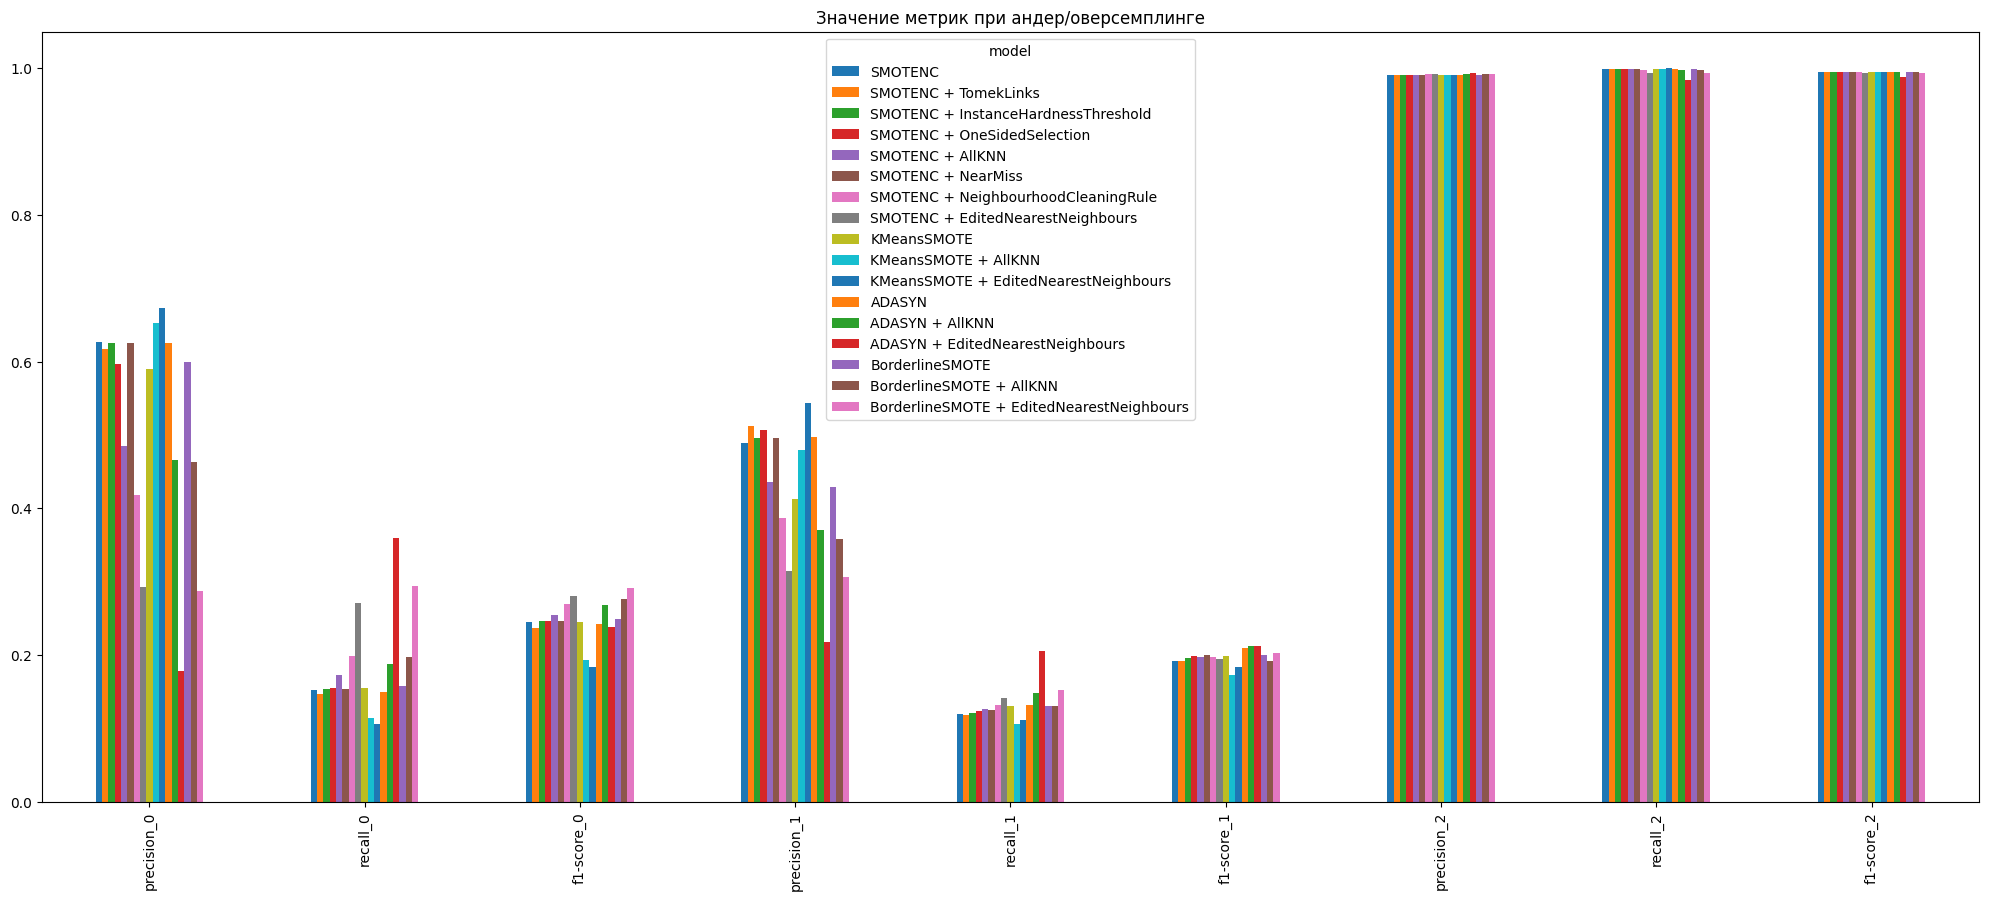

In [137]:
report_df.to_csv('data/report_df.csv')
t_report_df = report_df.set_index('model').T
fig, axes = plt.subplots(1, 1, figsize=(25, 10))
plot = t_report_df.plot.bar(ax=axes)
plt.title('Значение метрик при андер/оверсемплинге')

plt.show()

Наиболее сбалансированным сочетанием оказалось BorderlineSMOTE + EditedNearestNeighbours  
Выполним преобразование и сохраним результат на диск для дальнейшего использования.  

In [138]:
ower_under_dict = {'BorderlineSMOTE': ['EditedNearestNeighbours']}
# процедура выполняющая по параметрам из справочника ower_under_dict
# андерсемплинг и оверсемплинга, печатающая результат расчёта метрик
# и сохраняющая результаты преобразований на диск
under_ower_test(ower_under_dict, report_df == pd.DataFrame(),
                X_train, y_train, X_valid, y_valid, 1, 0)

Загрузим результаты преобразования данных и оценим результаты

In [139]:
# подготовим словарь для преобразования типов переменных
# признаков для сокращения объёма занимаемой памяти
load_dict = dict()
with open('data/columns_dict.pkl', 'rb') as f:
    columns_dict = pickle.load(f)

load_dict = dict()
for key, value in columns_dict.items():
    for item in value:
        load_dict[item] = key
# загрузим данные
X_train = pd.read_csv(
    'data/X_res_BorderlineSMOTE + EditedNearestNeighbours.csv', dtype=load_dict)
y_train = pd.read_csv(
    'data/y_res_BorderlineSMOTE + EditedNearestNeighbours.csv', dtype='int8')
X_valid = pd.read_csv('data/X_valid.csv', dtype=load_dict)
y_valid = pd.read_csv('data/y_valid.csv', dtype='int8')

Протестируем эффективность метода ближайших соседей на преобразованных данных

In [140]:
# создаем модель
neigh = KNeighborsClassifier(n_neighbors=5)
# выполним обучение
neigh.fit(X_train, y_train)
# выполним предсказание и получим результат расчёта метрики
print(metrics.classification_report(y_valid, neigh.predict(X_valid)))
print('roc_auc_score на тестовом наборе: {:.2f}'.format(metrics.roc_auc_score(
    y_valid, neigh.predict_proba(X_valid), multi_class='ovr')))

              precision    recall  f1-score   support

           0       0.05      0.69      0.10      1247
           1       0.04      0.30      0.06       224
           2       1.00      0.87      0.93    135686

    accuracy                           0.87    137157
   macro avg       0.36      0.62      0.36    137157
weighted avg       0.99      0.87      0.92    137157

roc_auc_score на тестовом наборе: 0.77


Результат не удовлетворительный

Подберем при помощи Optuna оптимальные гиперпараметры для классификатора XGBClassifier, ранее показавшего наилучшие результаты среди протестированных моделей.

In [141]:
def optuna_xgb(trial):

  # задаем пространства поиска гиперпараметров
    n_estimators = trial.suggest_int('n_estimators', 1700, 4000, 50)
    max_depth = trial.suggest_int('max_depth', 20, 40, 1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10, 1)
    learning_rate = trial.suggest_float('learning_rate', 0.05, 0.1)
    min_child_weight = trial.suggest_float('min_child_weight', 0.1, 5.0)

  # создаем модель
    model = xgb.XGBClassifier(tree_method="hist",
                              objective='multi:softprob',
                              eval_metric='auc',
                              max_bin=512,
                              n_job=-1,
                              learning_rate=learning_rate,
                              n_estimators=n_estimators,
                              max_depth=max_depth,
                              min_samples_leaf=min_samples_leaf,
                              min_child_weight=min_child_weight,
                              random_state=RANDOM_STATE)
  # обучаем модель
    model.fit(X_train, y_train)
  # вычислим скор
    score = metrics.roc_auc_score(
        y_valid, model.predict_proba(X_valid), multi_class='ovr')

    return score

In [142]:
% % time
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="xgb", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_xgb, n_trials=7)

[I 2024-05-19 16:56:07,146] A new study created in memory with name: xgb
[I 2024-05-19 19:40:06,291] Trial 0 finished with value: 0.9551539280561817 and parameters: {'n_estimators': 1900, 'max_depth': 39, 'min_samples_leaf': 2, 'learning_rate': 0.07408707940520987, 'min_child_weight': 0.983696923704064}. Best is trial 0 with value: 0.9551539280561817.
[I 2024-05-19 22:34:42,313] Trial 1 finished with value: 0.9544004613949176 and parameters: {'n_estimators': 2500, 'max_depth': 38, 'min_samples_leaf': 6, 'learning_rate': 0.14910057126009857, 'min_child_weight': 1.6295556866797893}. Best is trial 0 with value: 0.9551539280561817.
[I 2024-05-20 00:36:02,415] Trial 2 finished with value: 0.954306547223668 and parameters: {'n_estimators': 1750, 'max_depth': 40, 'min_samples_leaf': 1, 'learning_rate': 0.18337830260866517, 'min_child_weight': 2.757153333597665}. Best is trial 0 with value: 0.9551539280561817.
[I 2024-05-20 03:53:17,240] Trial 3 finished with value: 0.9538575557380685 and para

Сохраним результат обучения на диск для дальнейшего использования

In [143]:
with open('data/study.pkl', 'wb') as f:
    pickle.dump(study, f)

Оценим процесс подбора параметров по графикам.

In [144]:
# визуализируем изменнение метрики в процессе обучения
optuna.visualization.plot_optimization_history(
    study, target_name="roc_auc_score")

График важности гиперпараметров - помогает понять, какие гиперпараметры вносят больший вклад в минимизацию/максимизацию метрики.

In [145]:
optuna.visualization.plot_param_importances(study, target_name="roc_auc_score")

Оценим связь между различными комбинациями гиперпараметров и значение метрики для этих комбинаций по графикам контура отношений гиперпараметров.

In [146]:
optuna.visualization.plot_contour(study, params=["max_depth", "learning_rate", "n_estimators", "min_child_weight", "min_samples_leaf"],
                                  target_name="roc_auc_score")

Разница в полученных значениях метрик не существенна или отсутствует, на основании графиков значимости и сочетания гиперпараметров можно видеть, что оптимальное значение в целом соответствует набору параметров, показавшему лучший результат метрики.  
  
С лучшими параметрами построим модель, выполним ее обучение и рассчитаем результат метрик.

In [147]:
# создаем модель
model = xgb.XGBClassifier(**study.best_params,
                          tree_method="hist",
                          objective='multi:softprob',
                          eval_metric='auc',
                          max_bin=512,
                          n_job=-1,
                          random_state=RANDOM_STATE
                          )
# обучаем модель
model.fit(X_train, y_train)
# выполним предсказание и выведем результат
y_pred = model.predict(X_valid)
print(metrics.classification_report(y_valid, y_pred))

y_dense = LabelBinarizer().fit_transform(y_train)
y_pred2 = model.predict(X_train)
y_pr = LabelBinarizer().fit_transform(y_pred2)

print('f1_score на тестовом наборе: {:.2f}'.format(
    metrics.f1_score(y_dense, y_pr, average='samples')))
print('roc_auc_score на тестовом наборе: {:.2f}'.format(metrics.roc_auc_score(
    y_valid, model.predict_proba(X_valid), multi_class='ovr')))

print("Наилучшие значения гиперпараметров {}".format(study.best_params))

              precision    recall  f1-score   support

           0       0.20      0.51      0.29      3741
           1       0.28      0.26      0.27       671
           2       0.99      0.98      0.99    407057

    accuracy                           0.98    411469
   macro avg       0.49      0.59      0.52    411469
weighted avg       0.99      0.98      0.98    411469

f1_score на тестовом наборе: 1.00
roc_auc_score на тестовом наборе: 0.95
Наилучшие значения гиперпараметров {'n_estimators': 2000, 'max_depth': 32, 'min_samples_leaf': 6, 'learning_rate': 0.06961511303704385, 'min_child_weight': 2.9043305893463502}


сохраним полученную модель

In [148]:
with open('data/model_xgb_MEE.pkl', 'rb') as f:
    model = pickle.load(f)

Выполним предсказание на кроссвалидации и построим ROC кривую для визуальной оценки эффективности работы классификатора.

In [149]:
# Создаём кросс-валидатор k-fold со стратификацией
skf = StratifiedKFold(n_splits=5)
y = y_valid['MEE'].values
# Делаем предсказание вероятностей на кросс-валидации
y_cv_proba_pred = cross_val_predict(
    model, X_valid, y, cv=skf, method='predict_proba')

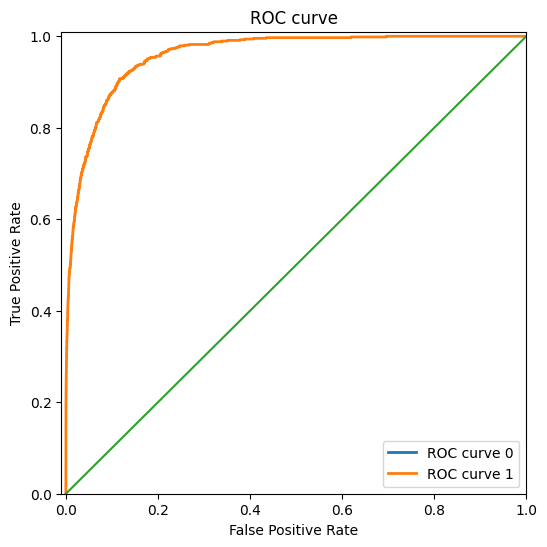

In [150]:
y_test_0 = y_valid['MEE'].apply(lambda x: 2 if x == 1 else x)
y_test_1 = y_valid['MEE'].apply(lambda x: 2 if x == 0 else x)
y_pred_0 = y_cv_proba_pred[:, 0]
y_pred_1 = y_cv_proba_pred[:, 1]

fpr0, tpr0, _ = metrics.roc_curve(y_test_0, y_pred_0, pos_label=1)
fpr1, tpr1, _ = metrics.roc_curve(y_test_1, y_pred_1, pos_label=1)
lw = 2

plt.subplots(figsize=(6, 6))
plt.plot(fpr0, tpr0, lw=lw, label='ROC curve 0')
plt.plot(fpr1, tpr1, lw=lw, label='ROC curve 1')
plt.plot([0, 1], [0, 1])
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc='best')

plt.show()

По графику и числовому значению метрики roc_auc_score = 0.95 можно говорить о удовлетворительном уровне работы классификатора не смортря на выраженный  классов целевой переменной.  
Посмотрим можно ли увеличить метрику, подобрав пороговое значение классификации.

Построим Precision-recall curve

Класс 0
Best threshold = 0.93, F1-Score = 0.32
Класс 1
Best threshold = 0.68, F1-Score = 0.27


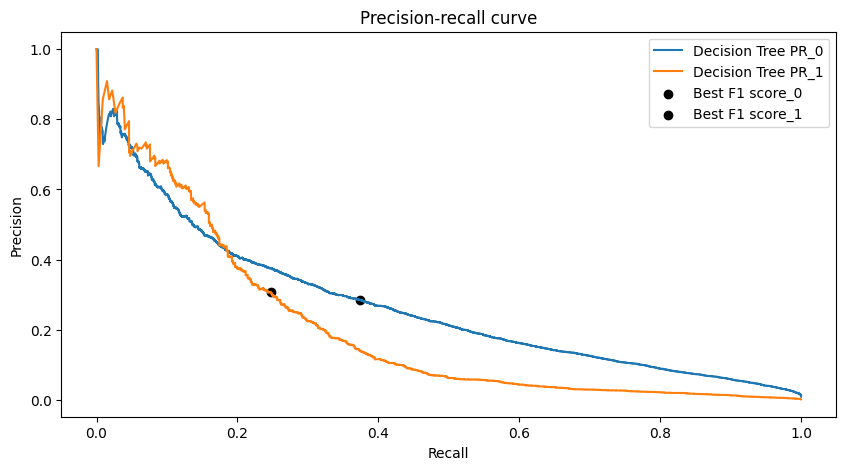

In [151]:
proba_pred_0 = model.predict_proba(X_valid)[:, 0]
proba_pred_1 = model.predict_proba(X_valid)[:, 1]
y_dense_0 = LabelBinarizer().fit_transform(y_valid)[:, 0]
y_dense_1 = LabelBinarizer().fit_transform(y_valid)[:, 1]
# Вычисляем координаты PR-кривой
precision_0, recall_0, thresholds_0 = metrics.precision_recall_curve(
    y_dense_0, proba_pred_0)
precision_1, recall_1, thresholds_1 = metrics.precision_recall_curve(
    y_dense_1, proba_pred_1)
# Вычисляем F1-меру при различных threshold
f1_scores_0 = (2 * precision_0 * recall_0) / (precision_0 + recall_0)
f1_scores_1 = (2 * precision_1 * recall_1) / (precision_1 + recall_1)
# Определяем индекс максимума
idx_0 = np.argmax(f1_scores_0)
idx_1 = np.argmax(f1_scores_1)
print('Класс 0')
print('Best threshold = {:.2f}, F1-Score = {:.2f}'.format(
    thresholds_0[idx_0], f1_scores_0[idx_0]))
print('Класс 1')
print('Best threshold = {:.2f}, F1-Score = {:.2f}'.format(
    thresholds_1[idx_1], f1_scores_1[idx_1]))
# Строим PR-кривую
fig, ax = plt.subplots(figsize=(10, 5))  # фигура + координатная плоскость
# Строим линейный график зависимости precision от recall
ax.plot(recall_0, precision_0, label='Decision Tree PR_0')
ax.plot(recall_1, precision_1, label='Decision Tree PR_1')
# Отмечаем точку максимума F1
ax.scatter(recall_0[idx_0], precision_0[idx_0], marker='o',
           color='black', label='Best F1 score_0')
ax.scatter(recall_1[idx_1], precision_1[idx_1], marker='o',
           color='red', label='Best F1 score_1')
# Даем графику название и подписи осям
ax.set_title('Precision-recall curve')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
# Отображаем легенду
ax.legend()

Форма кривых говорит о не высоком значении класификторов. Однако учитывая резко вырахенный дисбаланс с базовым значением мало отличимым от нулевого (доля класса 0 - 0.91%, доля класса 1 - 0.16% от общего количества примеров) бесполезной модель назвать нельзя.

При оптимальных пороговых значениях значение F1-Score либо не меняется для класса "1" либо не значительно увеличилось для класса "0". Однако такое увеличение порога приведет к заметному падению полноты.  
Учитывая всё это во внедряемой модели в качестве результата классификации будет предлагаться вероятность принадлежности к каждому классу. По итогам тестовой эксплуатации, совместно с врачами экспертами можно будет определить практически значимы порг, который в дальнейшем можно будет использовать при классификации.

Протестируем эффективность работы нейросети, в качестве классификатора возьмем 3-х слойную сеть с активацией "relu", 97 входными параметрами.

In [152]:
from keras import metrics

# подготовим данные
y_train_oh = keras.utils.to_categorical(y_train, 3)
y_val_oh = keras.utils.to_categorical(y_valid, 3)

# создаем модель
K.clear_session()
model = M.Sequential()
model.add(L.InputLayer(input_shape=(97,)))
model.add(L.Dense(768, activation='relu'))
model.add(L.Dense(768, activation='relu'))
model.add(L.Dense(512, activation='relu'))
model.add(L.Dense(3, activation='softmax'))

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=[keras.metrics.AUC()]
)

# параметры модели
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 768)            │        75,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 768)            │       590,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       393,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,061,123 (4.05 MB)

 Trainable params: 1,061,123 (4.05 MB)

 Non-trainable params: 0 (0.00 B)

In [153]:
# обучим модель
history = model.fit(
    X_train,
    y_train_oh,
    batch_size=8192,
    epochs=10,
    validation_data=(X_valid, y_val_oh))

Epoch 1/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 103s 684ms/step - auc: 0.9333 - loss: 0.4696 - val_auc: 0.9393 - val_loss: 0.6018
Epoch 2/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 139s 660ms/step - auc: 0.9900 - loss: 0.1839 - val_auc: 0.9727 - val_loss: 0.3739
Epoch 3/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 83s 577ms/step - auc: 0.9937 - loss: 0.1442 - val_auc: 0.9600 - val_loss: 0.4914
Epoch 4/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 95s 662ms/step - auc: 0.9946 - loss: 0.1322 - val_auc: 0.9737 - val_loss: 0.3791
Epoch 5/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 146s 690ms/step - auc: 0.9959 - loss: 0.1141 - val_auc: 0.9581 - val_loss: 0.5282
Epoch 6/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 143s 697ms/step - auc: 0.9964 - loss: 0.1053 - val_auc: 0.9756 - val_loss: 0.3697
Epoch 7/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 146s 725ms/step - auc: 0.9960 - loss: 0.1102 - val_auc: 0.9723 - val_loss: 0.4056
Epoch 8/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 110s 770ms/step - auc: 0.9969 - loss: 0.0951 - val_auc: 0.9731 - val_loss: 0.3887
Epoch 9/10
143/143 ━━━━━━━

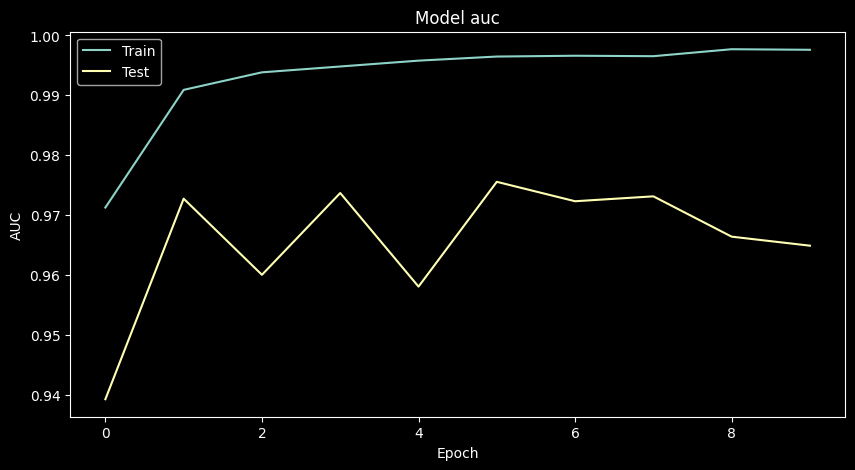

In [154]:
# построим кривые изменения метрик в процессе обучения
plt.style.use(['dark_background'])
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('Model auc')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [155]:
from sklearn import metrics

# произведем предсказание и рассчитаем значение метрик
y_pred = model.predict(X_valid)
df_y_pred = pd.DataFrame(y_pred, columns=['0', '1', '2'])
pred_list = []
for num, row in df_y_pred.iterrows():
    if row['0'] > row['1'] and row['0'] > row['2']:
        pred_list.append(0)
    elif row['1'] > row['2']:
        pred_list.append(1)
    else:
        pred_list.append(2)

df_y_pred_t = pd.DataFrame(pred_list, columns=['MEE'])

print(metrics.classification_report(y_valid, df_y_pred_t))
print(metrics.roc_auc_score(y_valid, y_pred, multi_class='ovr'))

8573/8573 ━━━━━━━━━━━━━━━━━━━━ 32s 4ms/step
              precision    recall  f1-score   support

           0       0.06      0.72      0.11      2494
           1       0.03      0.38      0.06       448
           2       1.00      0.88      0.93    271371

    accuracy                           0.87    274313
   macro avg       0.36      0.66      0.37    274313
weighted avg       0.99      0.87      0.92    274313

0.8999827749207073


Эффективность не высокая, без GPU эффективную сеть обучить не получилось.  
Так же неэффективным оказался и стекинг древовидной модели XGBClassifier, линейной регрессии и метода ближайших соседей с результрируюшей моделью SVM.

## 3.2 Предсказание вероятности дефектов ЭКМП

Дисбаланс классов для экспертиз ЭКМП ещё больше, чем для МЕЕ. А значит рационально будет ограничить поиск вараинтов построения модели предсказания наиболее эффективными методами, выявленными на предыдущем этапе для экспертизы МЕЕ и ограничиться следующими шагами:  
1. Подобрать порог для удаления малозначимых признаков.
2. Определить наиболее эффективное сочетание методов андер/оверсемплинга
3. Протестировать эффективность классификаторов XGBClassifier и нейронной сети
4. Подобрать оптимальные параметры классификаторов при помощи Optuna

Загрузим данные и подберем порог для удаления малозначимых признаков.

In [156]:
corr_final_MEE = pd.read_csv('data/corr_final_EKMP.csv')
with open('data/columns_dict.pkl', 'rb') as f:
    columns_dict = pickle.load(f)

load_dict = dict()
for key, value in columns_dict.items():
    for item in value:
        load_dict[item] = key

X = pd.read_csv('data/X_EKMP_train.csv', dtype=load_dict)
y = pd.read_csv('data/y_EKMP_train.csv', dtype='int8')
y = y['EKMP'].apply(lambda x: 2 if x == -1 else x)

with open('data/imp_cat_EKMP.pkl', 'rb') as f:
    imp_cat = pickle.load(f)
with open('data/imp_num_EKMP.pkl', 'rb') as f:
    imp_num = pickle.load(f)

In [157]:
for i in range(4,10):
    drop_coeff = 0.001*(i)
    print('Порог = ',drop_coeff)
    drop_list_cat = list(imp_cat[imp_cat<drop_coeff].index)
    drop_list_num = list(imp_num[imp_num<drop_coeff].index)
    drop_list = drop_list_cat + drop_list_num

    X_drop_imp = X.drop(drop_list, axis=1)
    X_train, X_valid, y_train, y_valid= train_test_split(X_drop_imp, 
                                                     y, 
                                                     stratify=y, 
                                                     random_state = RANDOM_STATE, 
                                                     test_size = 0.20)
    print(i)
    lgbm_calc(X_train,y_train,X_valid,y_valid)

Порог =  0.004
4
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.121988 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3571
[LightGBM] [Info] Number of data points in the train set: 2743123, number of used features: 85
[LightGBM] [Info] Start training from score -5.992458
[LightGBM] [Info] Start training from score -6.201794
[LightGBM] [Info] Start training from score -0.004534
              precision    recall  f1-score   support

           0       0.07      0.21      0.10      1713
           1       0.27      0.26      0.27      1389
           2       1.00      0.99      0.99    682679

    accuracy                           0.99    685781
   macro avg       0.45      0.49      0.45    685781
weighted avg       0.99      0.99      0.99    685781

Порог

Оптимальным значением признаем 0.005  

#### тест сочетания оверсемплинга и андерсемплинга  
попробуем протестировать эффективность оверсемплинга и сочетание оверсемплинга с различными вариантами андерсемплинга над полученными при андерсемплинге данными.

In [158]:
# датафрейм для хранения результатов расчётов метрик
report_df = pd.DataFrame(columns=['model', 'precision_0', 'recall_0', 'f1-score_0',
                         'precision_1', 'recall_1', 'f1-score_1', 'precision_2', 'recall_2', 'f1-score_2'])
# удалим малозначимые признаки
drop_list_cat = list(imp_cat[imp_cat < 0.005].index)
drop_list_num = list(imp_num[imp_num < 0.005].index)
drop_list = drop_list_cat + drop_list_num
X_train = X_train.drop(drop_list, axis=1)
X_valid = X_valid.drop(drop_list, axis=1)
# справочник с различными сочетаниями методов оверсемплинга и андерсемплинга
ower_under_dict = {'SMOTENC': ['AllKNN', 'EditedNearestNeighbours'],
                   'KMeansSMOTE': ['AllKNN', 'EditedNearestNeighbours'],
                   'ADASYN': ['AllKNN', 'EditedNearestNeighbours'],
                   'BorderlineSMOTE': ['AllKNN', 'EditedNearestNeighbours']
                   }
# процедура выполняющая по параметрам из справочника ower_under_dict
# андерсемплинг и оверсемплинга, печатающая результат расчёта метрик
# и заполняющая датафрейм результатами расчёта метрик
under_ower_test(ower_under_dict, report_df, X_train, y_train, X_valid, y_valid)

SMOTENC
              precision    recall  f1-score   support

           0       0.50      0.20      0.28      3211
           1       0.48      0.25      0.33      2605
           2       1.00      1.00      1.00   1280023

    accuracy                           1.00   1285839
   macro avg       0.66      0.48      0.54   1285839
weighted avg       0.99      1.00      0.99   1285839

AllKNN
              precision    recall  f1-score   support

           0       0.43      0.24      0.30      3211
           1       0.38      0.27      0.32      2605
           2       1.00      1.00      1.00   1280023

    accuracy                           1.00   1285839
   macro avg       0.60      0.50      0.54   1285839
weighted avg       0.99      1.00      0.99   1285839

EditedNearestNeighbours
              precision    recall  f1-score   support

           0       0.24      0.33      0.28      3211
           1       0.20      0.40      0.26      2605
           2       1.00      0.99   

model  precision_0  recall_0  \
0                                     SMOTENC     0.504000  0.196201   
1                            SMOTENC + AllKNN     0.430682  0.236064   
2           SMOTENC + EditedNearestNeighbours     0.237428  0.332295   
3                                 KMeansSMOTE     0.481626  0.191841   
4                        KMeansSMOTE + AllKNN     0.500537  0.145126   
5       KMeansSMOTE + EditedNearestNeighbours     0.522565  0.137029   
6                                      ADASYN     0.519337  0.204921   
7                             ADASYN + AllKNN     0.509769  0.178761   
8            ADASYN + EditedNearestNeighbours     0.503497  0.179383   
9                             BorderlineSMOTE     0.435419  0.203675   
10                   BorderlineSMOTE + AllKNN     0.392549  0.226409   
11  BorderlineSMOTE + EditedNearestNeighbours     0.292899  0.299284   

    f1-score_0  precision_1  recall_1  f1-score_1  precision_2  recall_2  \
0     0.282448     0.480626  0.247601    0.326831     0.996664  0.999174   
1     0.304969     0.375723  0.274472    0.317214     0.996850  0.998527   
2     0.276963     0.195917  0.401536    0.263343     0.997470  0.994340   
3     0.274388     0.479514  0.242610    0.322202     0.996641  0.999148   
4     0.225012     0.503953  0.195777    0.282002     0.996391  0.999406   
5     0.217123     0.505972  0.178887    0.264322     0.996325  0.999480   
6     0.293881     0.494182  0.244530    0.327170     0.996677  0.999216   
7     0.264699     0.511668  0.227255    0.314726     0.996567  0.999317   
8     0.264524     0.497922  0.229942    0.314601     0.996567  0.999268   
9     0.277530     0.443528  0.268330    0.334370     0.996752  0.998884   
10    0.287182     0.360906  0.281382    0.316221     0.996877  0.998382   
11    0.296057     0.231226  0.373512    0.285630     0.997307  0.996003   

    f1-score_2  
0     0.997918  
1     0.997688  
2     0.995903  
3     0.997893  
4     0.997897  
5     0.997900  
6     0.997945  
7     0.997940  
8     0.997916  
9     0.997816  
10    0.997629  
11    0.996655

Визуализируем результаты 

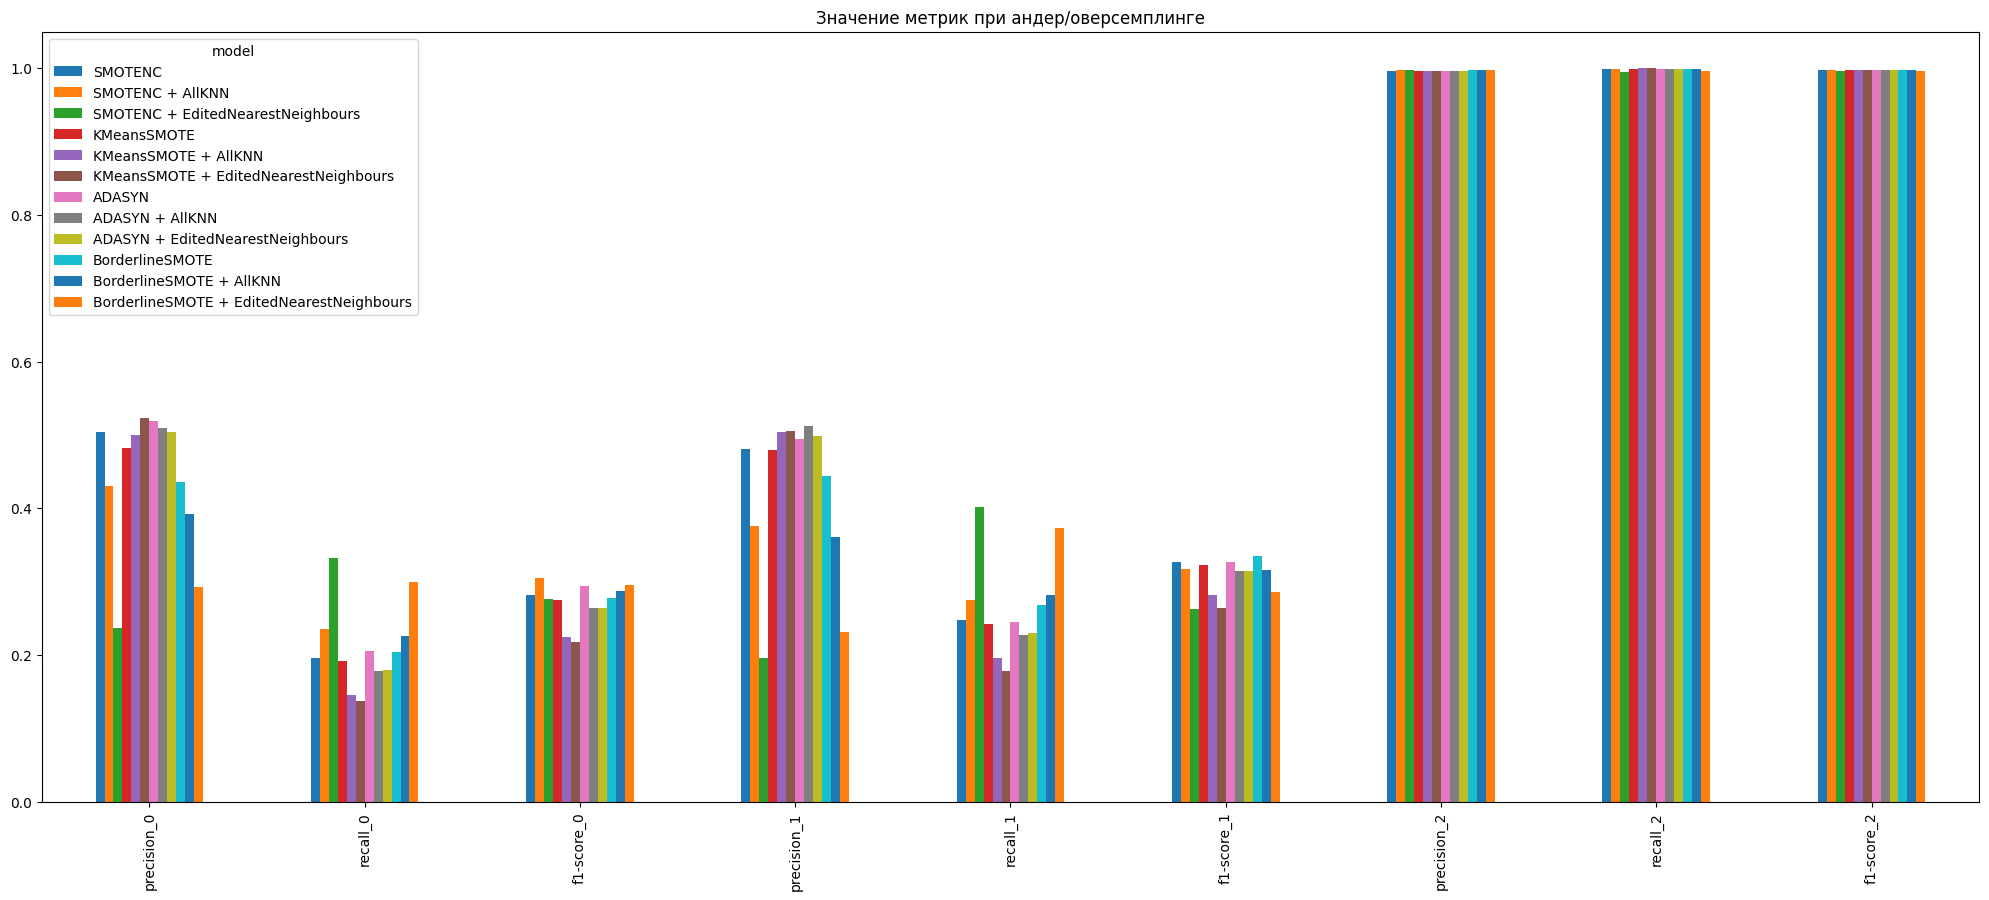

In [160]:
t_report_df = report_df.set_index('model').T
fig, axes = plt.subplots(1, 1, figsize=(25, 10))
plot = t_report_df.plot.bar(ax=axes)
plt.title('Значение метрик при андер/оверсемплинге')

plt.show()

наиболее сбалансированной оказалась комбинация SMOTENC + EditedNearestNeighbours  
сохраним ее для дальнейшей работы

In [161]:
report_df = pd.DataFrame()
# процедура стратифицированно разделяющая датасет на тестовую
# и валидационную выборки в переданной пропорции
# с удалением малозначимых переменных
X_train, X_valid, y_train, y_valid = get_train_valid_file(
    X_train, y_train, imp_cat, imp_num, 0.005, 0.20)
# справочник с различными сочетаниями методов оверсемплинга и андерсемплинга
ower_under_dict = {'SMOTENC': ['EditedNearestNeighbours']}
# процедура выполняющая по параметрам из справочника ower_under_dict
# андерсемплинг и оверсемплинга, печатающая результат расчёта метрик
# и заполняющая датафрейм результатами расчёта метрик
under_ower_test(ower_under_dict, report_df == pd.DataFrame(),
                X_train, y_train, X_valid, y_valid, 1, 0)

SMOTENC
EditedNearestNeighbours
1


Empty DataFrame
Columns: []
Index: []

Для дальнейшего использования сохраним валидационные датасеты

In [163]:
X_valid.to_csv('data/X_valid_EKMP.csv', index=False)
y_valid.to_csv('data/y_valid_EKMP.csv', index=False)

Загрузим данные, полученные в результате преобразований

In [164]:
load_dict = dict()
with open('data/columns_dict.pkl', 'rb') as f:
    columns_dict = pickle.load(f)

load_dict = dict()
for key, value in columns_dict.items():
    for item in value:
        load_dict[item] = key

X_train = pd.read_csv(
    'data/X_res_SMOTENC + EditedNearestNeighbours.csv', dtype=load_dict)
y_train = pd.read_csv(
    'data/y_res_SMOTENC + EditedNearestNeighbours.csv', dtype='int8')
X_valid = pd.read_csv('data/X_valid_EKMP.csv', dtype=load_dict)
y_valid = pd.read_csv('data/y_valid_EKMP.csv', dtype='int8')

Протестируем эффективность классификатора XGBClassifier

In [165]:
# создаем модель
model = xgb.XGBClassifier(tree_method="hist",
                          objective='multi:softprob',
                          eval_metric='auc',
                          max_bin=512,
                          n_job=-1,
                          random_state=RANDOM_STATE)
# обучаем модель
model.fit(X_train, y_train)
# выполним предсказание
y_pred = model.predict(X_valid)
# рассчитаем метрики
print('Метрика roc_auc_score = ', metrics.roc_auc_score(
    y_valid, model.predict_proba(X_valid), multi_class='ovr'))
print(metrics.classification_report(y_valid, y_pred))

Метрика roc_auc_score =  0.9753821820050149
              precision    recall  f1-score   support

           0       0.25      0.33      0.28       685
           1       0.26      0.44      0.32       556
           2       1.00      1.00      1.00    273072

    accuracy                           0.99    274313
   macro avg       0.50      0.59      0.53    274313
weighted avg       0.99      0.99      0.99    274313



Протестируем эффективность нейронной сети. Используем трехслойную сеть с активацией "relu" и 82 входными параметрами.

In [166]:
# подготовим данные
y_train_oh = keras.utils.to_categorical(y_train, 3)
y_val_oh = keras.utils.to_categorical(y_valid, 3)
# создадим модель
K.clear_session()
model = M.Sequential()
model.add(L.InputLayer(input_shape=(82,)))
model.add(L.Dense(768, activation='relu'))
model.add(L.Dense(1024, activation='relu'))
model.add(L.Dense(768, activation='relu'))
model.add(L.Dense(3, activation='softmax'))

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=[keras.metrics.AUC()]
)
# параметры модели
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 768)            │        63,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1024)           │       787,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 768)            │       787,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │         2,307 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,640,707 (6.26 MB)

 Trainable params: 1,640,707 (6.26 MB)

 Non-trainable params: 0 (0.00 B)

In [167]:
# обучим модель
history = model.fit(
    X_train,
    y_train_oh,
    batch_size=8192,
    epochs=10,
    validation_data=(X_valid, y_val_oh))

Epoch 1/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 138s 878ms/step - auc: 0.9254 - loss: 0.4924 - val_auc: 0.9933 - val_loss: 0.1598
Epoch 2/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 130s 846ms/step - auc: 0.9866 - loss: 0.2132 - val_auc: 0.9855 - val_loss: 0.2693
Epoch 3/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 149s 889ms/step - auc: 0.9938 - loss: 0.1416 - val_auc: 0.9846 - val_loss: 0.2769
Epoch 4/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 134s 835ms/step - auc: 0.9954 - loss: 0.1168 - val_auc: 0.9911 - val_loss: 0.1841
Epoch 5/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 129s 836ms/step - auc: 0.9965 - loss: 0.1000 - val_auc: 0.9914 - val_loss: 0.1783
Epoch 6/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 131s 854ms/step - auc: 0.9973 - loss: 0.0848 - val_auc: 0.9894 - val_loss: 0.2133
Epoch 7/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 151s 909ms/step - auc: 0.9976 - loss: 0.0786 - val_auc: 0.9906 - val_loss: 0.1954
Epoch 8/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 139s 904ms/step - auc: 0.9973 - loss: 0.0826 - val_auc: 0.9905 - val_loss: 0.1951
Epoch 9/10
154/154 ━━━━━

Построим кривые изменения метрик в процессе обучения

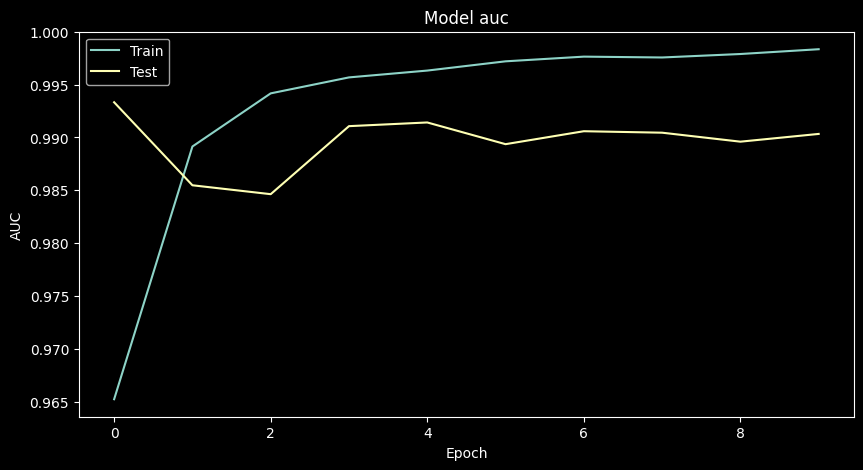

In [168]:
plt.style.use(['dark_background'])
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('Model auc')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [169]:
# выполним предсказание
y_pred = model.predict(X_valid)
df_y_pred = pd.DataFrame(y_pred, columns=['0', '1', '2'])
pred_list = []
for num, row in df_y_pred.iterrows():
    if row['0'] > row['1'] and row['0'] > row['2']:
        pred_list.append(0)
    elif row['1'] > row['2']:
        pred_list.append(1)
    else:
        pred_list.append(2)

df_y_pred_t = pd.DataFrame(pred_list, columns=['MEE'])

# рассчитаем и выведем метрики
print(metrics.classification_report(y_valid, df_y_pred_t))
print(metrics.roc_auc_score(y_valid, y_pred, multi_class='ovr'))

8573/8573 ━━━━━━━━━━━━━━━━━━━━ 38s 4ms/step
              precision    recall  f1-score   support

           0       0.03      0.60      0.06       685
           1       0.07      0.42      0.11       556
           2       1.00      0.94      0.97    273072

    accuracy                           0.94    274313
   macro avg       0.37      0.65      0.38    274313
weighted avg       0.99      0.94      0.97    274313

0.9237468737068356


Протестируем эффективность метода ближайших соседей.  
Тестировать линейную реграессию не имеет смысла, признаки очевидно линейно не разделимы.

In [170]:
# создаем модель
neigh = KNeighborsClassifier(n_neighbors=5)
# выполним обучение
neigh.fit(X_train, y_train)
# выполним предсказание и получим результат расчёта метрики
print(metrics.classification_report(y_valid, neigh.predict(X_valid)))
print('roc_auc_score на тестовом наборе: {:.2f}'.format(metrics.roc_auc_score(
    y_valid, neigh.predict_proba(X_valid), multi_class='ovr')))

              precision    recall  f1-score   support

           0       0.03      0.40      0.05       685
           1       0.04      0.42      0.07       556
           2       1.00      0.94      0.97    273072

    accuracy                           0.94    274313
   macro avg       0.35      0.59      0.36    274313
weighted avg       0.99      0.94      0.96    274313

roc_auc_score на тестовом наборе: 0.75


Наиболее эффективным классификатором оказался XGBClassifier  
Подберем оптимальные параметры при помощи Optuna

In [171]:
def optuna_xgb(trial):

  # задаем пространства поиска гиперпараметров
    n_estimators = trial.suggest_int('n_estimators', 1700, 4000, 50)
    max_depth = trial.suggest_int('max_depth', 20, 40, 1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10, 1)
    learning_rate = trial.suggest_float('learning_rate', 0.05, 0.1)
    min_child_weight = trial.suggest_float('min_child_weight', 0.1, 5.0)

  # создаем модель
    model = xgb.XGBClassifier(tree_method="hist",
                              objective='multi:softprob',
                              eval_metric='auc',
                              max_bin=512,
                              n_job=-1,
                              learning_rate=learning_rate,
                              n_estimators=n_estimators,
                              max_depth=max_depth,
                              min_samples_leaf=min_samples_leaf,
                              min_child_weight=min_child_weight,
                              random_state=RANDOM_STATE)
  # обучаем модель
    model.fit(X_train, y_train)
    score = metrics.roc_auc_score(
        y_valid, model.predict_proba(X_valid), multi_class='ovr')

    return score

In [172]:
% % time
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="xgb", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_xgb, n_trials=10)

[I 2024-05-24 21:20:33,020] A new study created in memory with name: xgb
[I 2024-05-24 22:42:47,519] Trial 0 finished with value: 0.9824847148624892 and parameters: {'n_estimators': 3650, 'max_depth': 21, 'min_samples_leaf': 4, 'learning_rate': 0.0917334550179687, 'min_child_weight': 0.7990580695942219}. Best is trial 0 with value: 0.9824847148624892.
[I 2024-05-25 00:00:35,097] Trial 1 finished with value: 0.9829083340620701 and parameters: {'n_estimators': 3100, 'max_depth': 40, 'min_samples_leaf': 8, 'learning_rate': 0.0598974068225654, 'min_child_weight': 0.8091501354979683}. Best is trial 1 with value: 0.9829083340620701.
[I 2024-05-25 00:58:30,879] Trial 2 finished with value: 0.9826650257899794 and parameters: {'n_estimators': 2550, 'max_depth': 27, 'min_samples_leaf': 7, 'learning_rate': 0.06500341935794023, 'min_child_weight': 4.253117113085284}. Best is trial 1 with value: 0.9829083340620701.
[I 2024-05-25 01:41:59,653] Trial 3 finished with value: 0.9827828925220429 and para

CPU times: total: 1d 8h 32min 57s
Wall time: 11h 8min 9s


Сохраним результат подбора параметров

In [173]:
with open('data/study_EKMP.pkl', 'wb') as f:
    pickle.dump(study, f)

Оценим результаты оптимизации по графикам.

In [174]:
optuna.visualization.plot_optimization_history(study, target_name="roc_auc_score")

График важности гиперпараметров - помогает понять, какие гиперпараметры вносят больший вклад в минимизацию/максимизацию метрики.

In [175]:
optuna.visualization.plot_param_importances(study, target_name="roc_auc_score")

Оценим связь между различными комбинациями гиперпараметров и значение метрики для этих комбинаций по графикам контура отношений гиперпараметров.

In [176]:
optuna.visualization.plot_contour(study, params=["n_estimators", "learning_rate", "min_child_weight", "max_depth", "min_samples_leaf"],
                                  target_name="roc_auc_score")

Разница в полученных значениях метрик не существенна или отсутствует, на основании графиков значимости и сочетания гиперпараметров можно видеть, что оптимальное значение в целом соответствует набору параметров, показавшему лучший результат метрики.

С лучшими параметрами построим модель, выполним ее обучение и рассчитаем результат метрик.

In [177]:
# создаем модель
model = xgb.XGBClassifier(**study.best_params,
                          tree_method="hist",
                          objective='multi:softprob',
                          eval_metric='auc',
                          max_bin=512,
                          n_job=-1,
                          random_state=RANDOM_STATE
                          )
# обучаем модель
model.fit(X_train, y_train)
# выполним предсказание и рассчитаем метрики
y_pred = model.predict(X_valid)
print(metrics.classification_report(y_valid, y_pred))

y_dense = LabelBinarizer().fit_transform(y_train)
y_pred2 = model.predict(X_train)
y_pr = LabelBinarizer().fit_transform(y_pred2)

print('f1_score на тестовом наборе: {:.2f}'.format(
    metrics.f1_score(y_dense, y_pr, average='samples')))
print('roc_auc_score на тестовом наборе: {:.2f}'.format(metrics.roc_auc_score(
    y_valid, model.predict_proba(X_valid), multi_class='ovr')))

print("Наилучшие значения гиперпараметров {}".format(study.best_params))

              precision    recall  f1-score   support

           0       0.39      0.33      0.36       685
           1       0.37      0.42      0.39       556
           2       1.00      1.00      1.00    273072

    accuracy                           0.99    274313
   macro avg       0.59      0.58      0.58    274313
weighted avg       0.99      0.99      0.99    274313

f1_score на тестовом наборе: 1.00
roc_auc_score на тестовом наборе: 0.98
Наилучшие значения гиперпараметров {'n_estimators': 3100, 'max_depth': 40, 'min_samples_leaf': 8, 'learning_rate': 0.0598974068225654, 'min_child_weight': 0.8091501354979683}


Сохраним модель для использования в предсказании

In [178]:
with open('data/model_xgb_EKMP.pkl', 'wb') as f:
    pickle.dump(model, f)

Выполним предсказание на кроссвалидации и построим ROC кривую для визуальной оценки эффективности работы классификатора.

In [179]:
# Создаём кросс-валидатор k-fold со стратификацией
skf = StratifiedKFold(n_splits=5)
y = y_valid['EKMP'].values
# Делаем предсказание вероятностей на кросс-валидации
y_cv_proba_pred = cross_val_predict(
    model, X_valid, y, cv=skf, method='predict_proba')

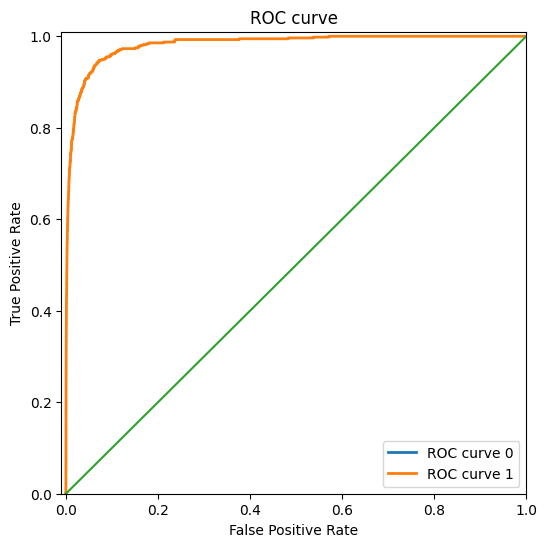

In [180]:
y_test_0 = y_valid['EKMP'].apply(lambda x: 2 if x == 1 else x)
y_test_1 = y_valid['EKMP'].apply(lambda x: 2 if x == 0 else x)
y_pred_0 = y_cv_proba_pred[:, 0]
y_pred_1 = y_cv_proba_pred[:, 1]

fpr0, tpr0, _ = metrics.roc_curve(y_test_0, y_pred_0, pos_label=1)
fpr1, tpr1, _ = metrics.roc_curve(y_test_1, y_pred_1, pos_label=1)
lw = 2

plt.subplots(figsize=(6, 6))
plt.plot(fpr0, tpr0, lw=lw, label='ROC curve 0')
plt.plot(fpr1, tpr1, lw=lw, label='ROC curve 1')
plt.plot([0, 1], [0, 1])
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc='best')

plt.show()

По графику и числовому значению метрики roc_auc_score = 0.98 можно говорить о удовлетворительном уровне работы классификатора не смортря на выраженный  классов целевой переменной.  
Посомтрим можно ли увеличить метрику подобрав пороговое значение классификации.

Класс 0
Best threshold = 0.37, F1-Score = 0.37
Класс 1
Best threshold = 0.48, F1-Score = 0.40


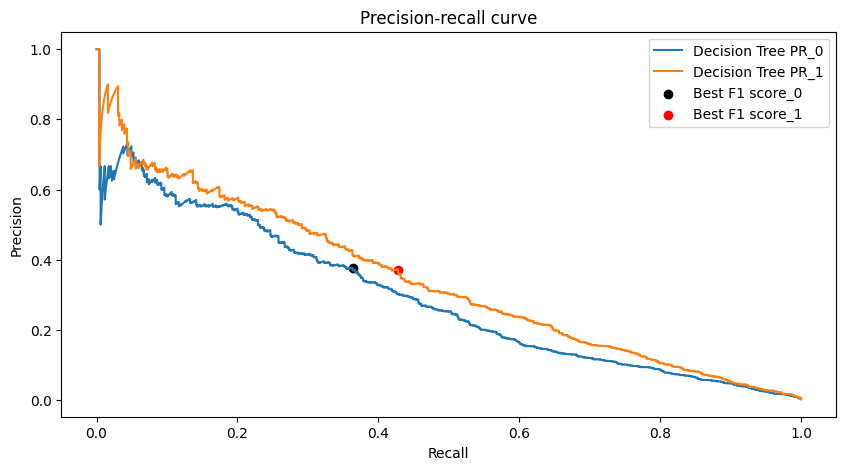

In [181]:
pred_proba = model.predict_proba(X_valid)
trans_valid = LabelBinarizer().fit_transform(y_valid)
proba_pred_0 = pred_proba[:, 0]
proba_pred_1 = pred_proba[:, 1]
y_dense_0 = trans_valid[:, 0]
y_dense_1 = trans_valid[:, 1]
# Вычисляем координаты PR-кривой
precision_0, recall_0, thresholds_0 = metrics.precision_recall_curve(
    y_dense_0, proba_pred_0)
precision_1, recall_1, thresholds_1 = metrics.precision_recall_curve(
    y_dense_1, proba_pred_1)
# Вычисляем F1-меру при различных threshold
f1_scores_0 = (2 * precision_0 * recall_0) / (precision_0 + recall_0)
f1_scores_1 = (2 * precision_1 * recall_1) / (precision_1 + recall_1)
# Определяем индекс максимума
idx_0 = np.argmax(f1_scores_0)
idx_1 = np.argmax(f1_scores_1)
print('Класс 0')
print('Best threshold = {:.2f}, F1-Score = {:.2f}'.format(
    thresholds_0[idx_0], f1_scores_0[idx_0]))
print('Класс 1')
print('Best threshold = {:.2f}, F1-Score = {:.2f}'.format(
    thresholds_1[idx_1], f1_scores_1[idx_1]))
# Строим PR-кривую
fig, ax = plt.subplots(figsize=(10, 5))  # фигура + координатная плоскость
# Строим линейный график зависимости precision от recall
ax.plot(recall_0, precision_0, label='Decision Tree PR_0')
ax.plot(recall_1, precision_1, label='Decision Tree PR_1')
# Отмечаем точку максимума F1
ax.scatter(recall_0[idx_0], precision_0[idx_0], marker='o',
           color='black', label='Best F1 score_0')
ax.scatter(recall_1[idx_1], precision_1[idx_1], marker='o',
           color='red', label='Best F1 score_1')
# Даем графику название и подписи осям
ax.set_title('Precision-recall curve')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
# Отображаем легенду
ax.legend()

Форма кривых говорит о не высоком значении класификторов. Однако учитывая резко выраженный дисбаланс с базовым значением мало отличимым от нулевого (доля класса 0 - 0.25%, доля класса 1 - 0.20% от общего количества примеров) бесполезной модель назвать нельзя.

Пороговый уровень для обоих миноритарных классов близок к 0.5 и друг другу, попробуем как скажется его использование на результатах классификации.

In [182]:
test_pred_proba = model.predict_proba(X_valid)


def pred_opt(test_pred_proba):
    ret_pred = []
    for _, item in enumerate(test_pred_proba):
        if item[0] > 0.37:
            ret_pred.append(0)
        elif item[1] > 0.48:
            ret_pred.append(1)
        else:
            ret_pred.append(2)
    return ret_pred


y_test_pred = pred_opt(test_pred_proba)
y_dense = LabelBinarizer().fit_transform(y_test_pred)
print(metrics.roc_auc_score(y_valid, y_dense, multi_class='ovr'))
print(metrics.classification_report(y_valid, y_test_pred))

0.7061601883326528
              precision    recall  f1-score   support

           0       0.38      0.36      0.37       685
           1       0.37      0.43      0.40       556
           2       1.00      1.00      1.00    273072

    accuracy                           0.99    274313
   macro avg       0.58      0.60      0.59    274313
weighted avg       0.99      0.99      0.99    274313



При оптимальных пороговых значениях значение F1-Score не значительно увеличилось. Такое увеличение порога так же незначительно влияет на полноту и точность. однако значительно снижает значение метрики roc_auc_score.  
Поэтому так же во внедряемой модели в качестве результата классификации будет предлагаться вероятность принадлежности к каждому классу. По итогам тестовой эксплуатации, совместно с врачами экспертами можно будет определить практически значимы порг, который в дальнейшем можно будет использовать при классификации.

# 4. Общий вывод

В результате проведенной работы проанализированы и преобразованы данные, отобраны значимые признаки.  
Проведено преобразование признаков для снижения влияния дисбаланса классов целевых переменных.
Построены и протестированы модели классификации различной природы, отобрана наиболее эффективная.  
Наиболее эффективной моделью для задач предсказания вероятности дефектов и проведения экспертизы МЕЕ и ЭКМП  
оказалась модель XGBClassifier. Для последней подобраны оптимальные параметры.  
На основании полученных моделей разработано Web приложение для проведения тестовой эксплуатации полученного 
классификатора совместно с врачами - экспертами отдела Защиты прав застрахованных.  
По итогам тестовой эксплуатации будет принято решение о дальнейшем внедрении.